# CNN + MaxPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests 'MEAN'.

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Show pretty pictures.

10-fold cross-validation.

Compute the sample standard deviation.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-07 15:12:25.481003
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'THE_MEAN'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-07 15:12:52.341878
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def place_discriminant(self,minRCI,maxRCI,mean1,var1,wgt1,mean2,var2,wgt2):
        bests = []
        left = None
        middle = None
        std1 = np.sqrt(var1)
        std2 = np.sqrt(var2)
        zmin = max(mean1-2*std1,mean2-2*std2)
        zmax = min(mean1+2*std1,mean2+2*std2)
        zrange = (zmax-zmin)
        for i in range(101):
            if left is None:
                x = zrange * (i-1)/100.0 + zmin
                p1 = ss.norm(mean1,var1).pdf(x)*wgt1
                p2 = ss.norm(mean2,var2).pdf(x)*wgt2
                left = p1-p2
            if middle is None:
                x = zrange * (i)/100.0 + zmin 
                p1 = ss.norm(mean1,var1).pdf(x)*wgt1
                p2 = ss.norm(mean2,var2).pdf(x)*wgt2
                middle = p1-p2
            x = zrange * (i+1)/100.0 + zmin 
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            right = p1-p2
            if left * right < 0.0:
                bests.append(x)
            left = middle
            middle = right
        if len(bests)==0:
            return None
        print('Bests',bests)
        return np.mean(bests)

    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            discrim = self.place_discriminant(
                min(rci_values),max(rci_values),
                gmm2.means_[0],gmm2.covariances_[0],gmm2.weights_[0],
                gmm2.means_[1],gmm2.covariances_[1],gmm2.weights_[1])
            if discrim is None:
                discrim = np.mean(rci_values)
                print('WARNING: discrim not found, using mean!')
        elif RCI_THRESHOLD_MECHANISM == 'THE_MEAN':
            discrim = np.mean(rci_values)
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_train = self.get_X_y(train_index)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            train_based_rci_mean = np.mean(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            X_valid,y_valid = self.get_X_y(valid_index)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI mean derived from training set:',train_based_rci_mean)
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-07 15:12:56.164859
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-07 15:13:11.284161
splitting
Fold 1
RCI mean derived from training set: -0.07263865964057306
RCI threshold derived from training set: -0.07263865964057306
FIT
2023-02-07 15:13:13.518909
PREDICT
2023-02-07 15:13:30.833471


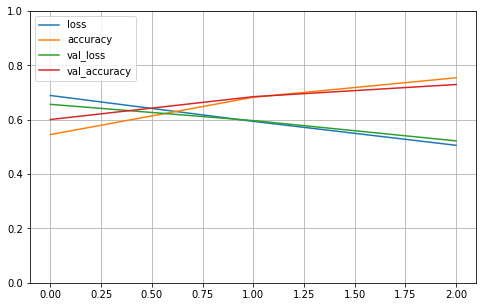

Train set ones/size 4200 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 452 / 869
Range of scores: 0.0069451765 to 0.9754426
Score threshold 0.5
Prediction set ones/size 439 / 869


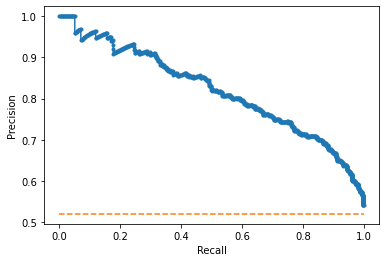

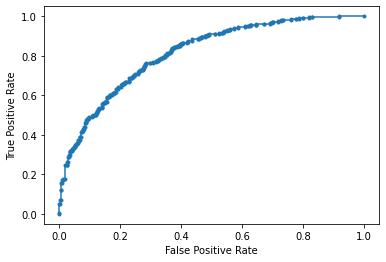

Accuracy: 72.96% Precision: 74.72% Recall: 72.57%
F1: 73.63% AUPRC: 82.10% AUROC: 81.48%
2023-02-07 15:13:31.594101
Fold 2
RCI mean derived from training set: -0.08890415963673573
RCI threshold derived from training set: -0.08890415963673573
FIT
2023-02-07 15:13:35.226867
PREDICT
2023-02-07 15:13:46.496689


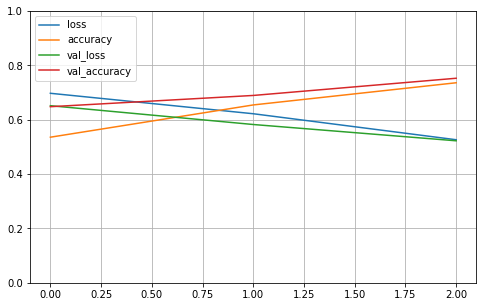

Train set ones/size 4246 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 506 / 869
Range of scores: 0.015757063 to 0.98359495
Score threshold 0.5
Prediction set ones/size 491 / 869


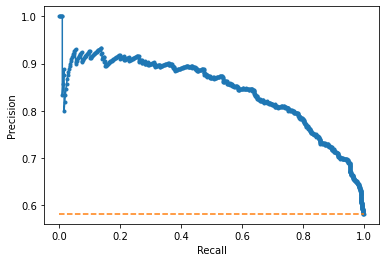

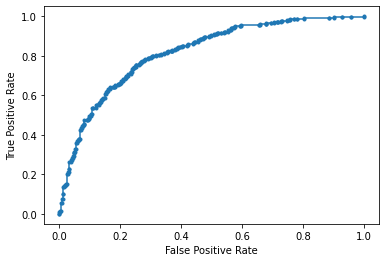

Accuracy: 75.26% Precision: 79.63% Recall: 77.27%
F1: 78.44% AUPRC: 84.25% AUROC: 81.72%
2023-02-07 15:13:47.188474
Fold 3
RCI mean derived from training set: -0.08061058532361218
RCI threshold derived from training set: -0.08061058532361218
FIT
2023-02-07 15:13:50.800459
PREDICT
2023-02-07 15:14:00.052753


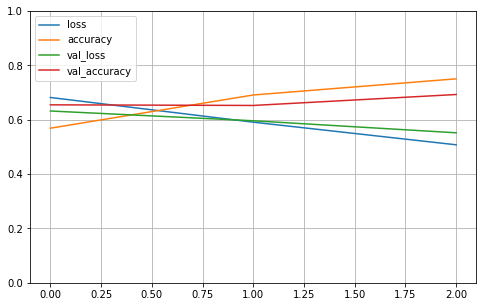

Train set ones/size 4200 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 461 / 869
Range of scores: 0.0073524774 to 0.9763342
Score threshold 0.5
Prediction set ones/size 286 / 869


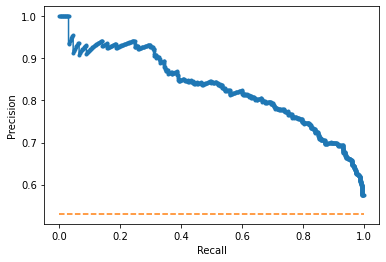

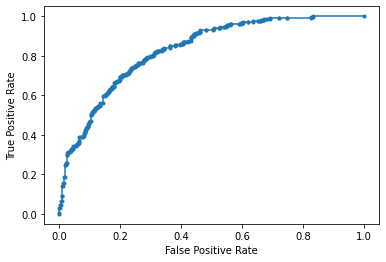

Accuracy: 69.28% Precision: 83.92% Recall: 52.06%
F1: 64.26% AUPRC: 83.19% AUROC: 83.10%
2023-02-07 15:14:01.067069
Fold 4
RCI mean derived from training set: -0.07163159574827323
RCI threshold derived from training set: -0.07163159574827323
FIT
2023-02-07 15:14:04.672393
PREDICT
2023-02-07 15:14:13.310600


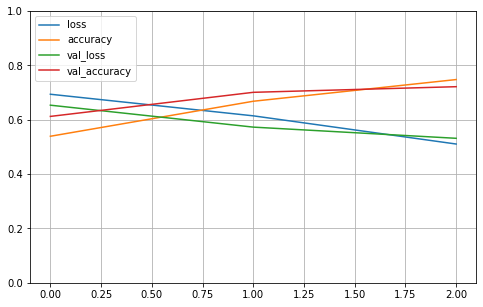

Train set ones/size 4211 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 441 / 869
Range of scores: 0.007504424 to 0.98673856
Score threshold 0.5
Prediction set ones/size 425 / 869


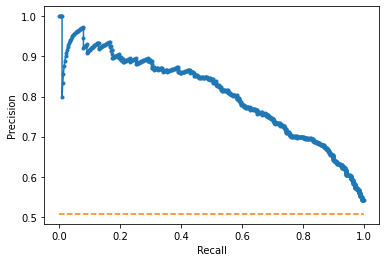

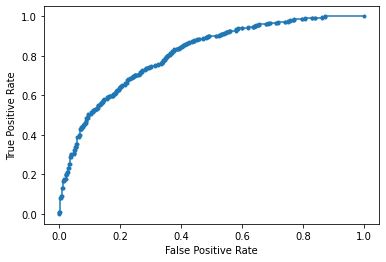

Accuracy: 72.15% Precision: 73.41% Recall: 70.75%
F1: 72.06% AUPRC: 80.42% AUROC: 80.96%
2023-02-07 15:14:13.938169
Fold 5
RCI mean derived from training set: -0.07909441939498593
RCI threshold derived from training set: -0.07909441939498593
FIT
2023-02-07 15:14:17.536167
PREDICT
2023-02-07 15:14:28.793196


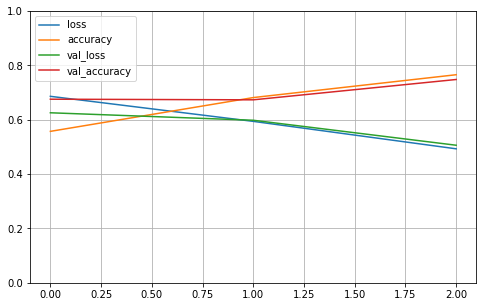

Train set ones/size 4186 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 475 / 869
Range of scores: 0.0068427995 to 0.991926
Score threshold 0.5
Prediction set ones/size 476 / 869


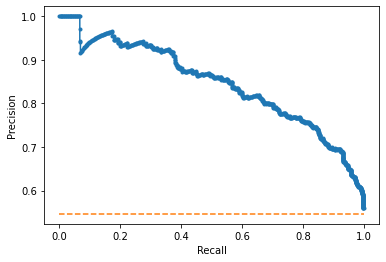

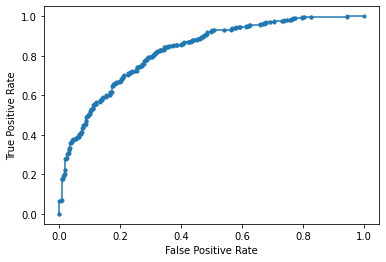

Accuracy: 74.80% Precision: 76.89% Recall: 77.05%
F1: 76.97% AUPRC: 84.64% AUROC: 82.75%
2023-02-07 15:14:29.434924
Fold 6
RCI mean derived from training set: -0.08340265725249423
RCI threshold derived from training set: -0.08340265725249423
FIT
2023-02-07 15:14:33.040170
PREDICT
2023-02-07 15:14:44.647208


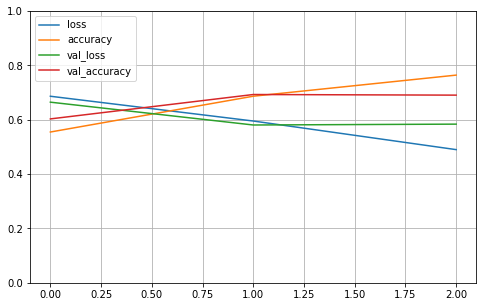

Train set ones/size 4204 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 457 / 869
Range of scores: 0.0069545093 to 0.9967704
Score threshold 0.5
Prediction set ones/size 590 / 869


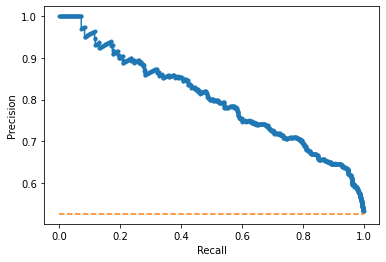

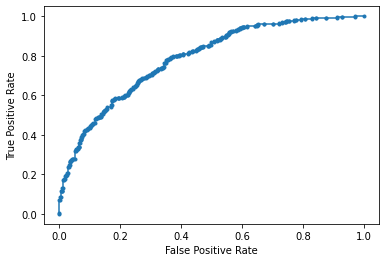

Accuracy: 69.04% Precision: 65.93% Recall: 85.12%
F1: 74.31% AUPRC: 80.09% AUROC: 78.74%
2023-02-07 15:14:45.305553
Fold 7
RCI mean derived from training set: -0.07222989336019443
RCI threshold derived from training set: -0.07222989336019443
FIT
2023-02-07 15:14:49.058549
PREDICT
2023-02-07 15:14:57.769882


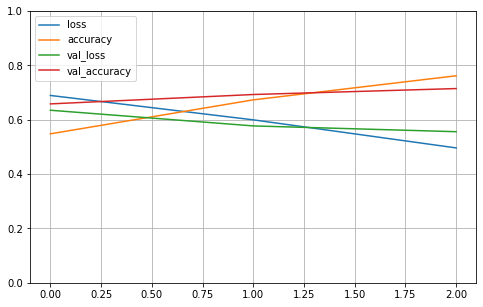

Train set ones/size 4172 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 480 / 869
Range of scores: 0.0019258802 to 0.9854837
Score threshold 0.5
Prediction set ones/size 424 / 869


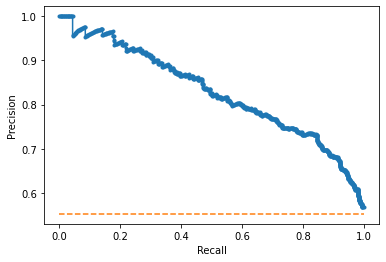

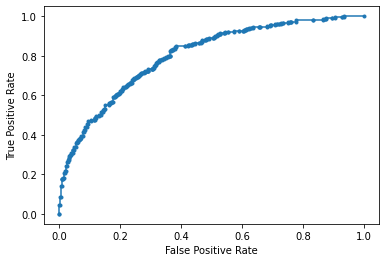

Accuracy: 71.46% Precision: 77.36% Recall: 68.33%
F1: 72.57% AUPRC: 82.93% AUROC: 80.07%
2023-02-07 15:14:58.386245
Fold 8
RCI mean derived from training set: -0.07443658561580764
RCI threshold derived from training set: -0.07443658561580764
FIT
2023-02-07 15:15:02.085043
PREDICT
2023-02-07 15:15:10.898842


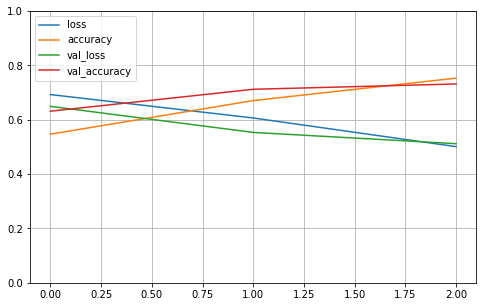

Train set ones/size 4194 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 458 / 868
Range of scores: 0.022374228 to 0.9973464
Score threshold 0.5
Prediction set ones/size 529 / 868


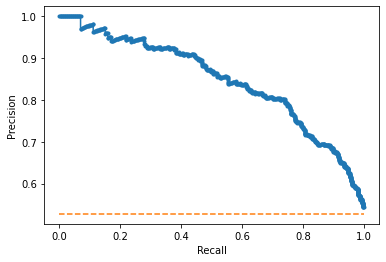

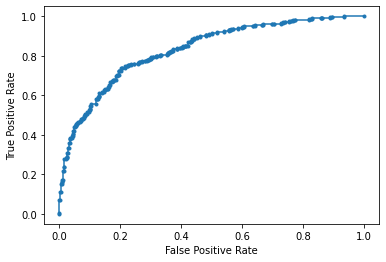

Accuracy: 73.16% Precision: 71.27% Recall: 82.31%
F1: 76.39% AUPRC: 84.82% AUROC: 83.10%
2023-02-07 15:15:11.572279
Fold 9
RCI mean derived from training set: -0.08124539040798057
RCI threshold derived from training set: -0.08124539040798057
FIT
2023-02-07 15:15:15.199225
PREDICT
2023-02-07 15:15:23.995889


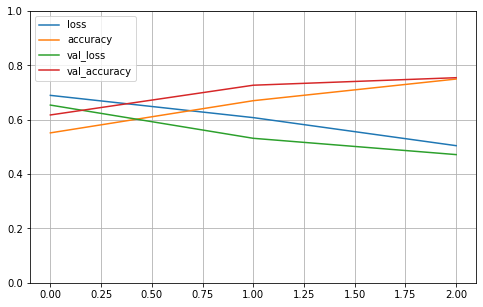

Train set ones/size 4190 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 471 / 868
Range of scores: 0.0018897743 to 0.9932713
Score threshold 0.5
Prediction set ones/size 490 / 868


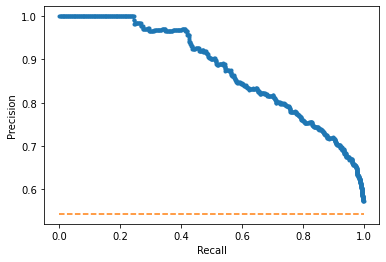

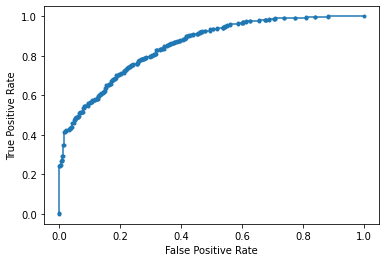

Accuracy: 75.46% Precision: 76.33% Recall: 79.41%
F1: 77.84% AUPRC: 87.84% AUROC: 85.18%
2023-02-07 15:15:24.644167
Fold 10
RCI mean derived from training set: -0.07852757553011895
RCI threshold derived from training set: -0.07852757553011895
FIT
2023-02-07 15:15:28.298897
PREDICT
2023-02-07 15:15:37.081727


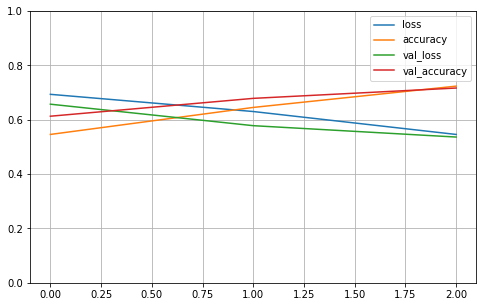

Train set ones/size 4192 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 469 / 868
Range of scores: 0.013646922 to 0.9860832
Score threshold 0.5
Prediction set ones/size 419 / 868


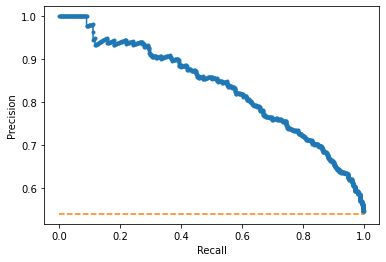

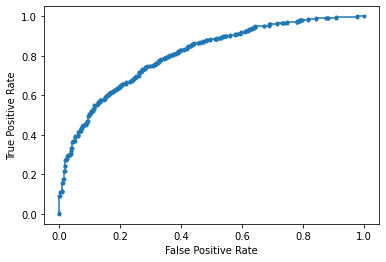

Accuracy: 71.66% Precision: 76.61% Recall: 68.44%
F1: 72.30% AUPRC: 83.37% AUROC: 80.73%
2023-02-07 15:15:37.743579

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.52% +/- 2.27
 precision mean 75.61% +/- 4.83
 recall mean 73.33% +/- 9.40
 F1 mean 73.87% +/- 4.12
 AUPRC mean 83.36% +/- 2.25
 AUROC mean 81.78% +/- 1.83
Finished cell Line 0 A549

2023-02-07 15:15:39.138073
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-07 15:16:05.610241
splitting
Fold 1
RCI mean derived from training set: -0.2860503863035882
RCI threshold derived from training set: -0.2860503863035882
FIT
2023-02-07 15:16:10.506052
PREDICT
2023-02-07 15:16:26.277559


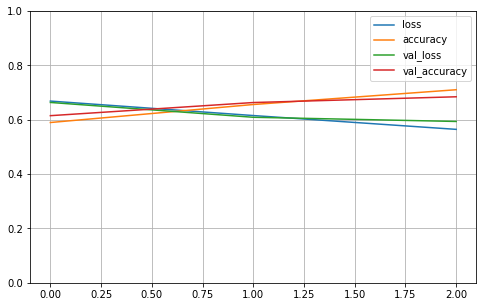

Train set ones/size 7436 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 828 / 1654
Range of scores: 0.008405554 to 0.9937471
Score threshold 0.5
Prediction set ones/size 610 / 1654


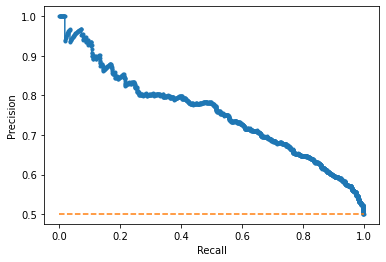

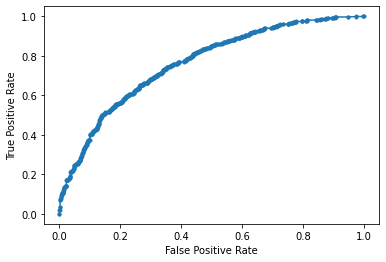

Accuracy: 68.44% Precision: 75.08% Recall: 55.31%
F1: 63.70% AUPRC: 75.53% AUROC: 76.28%
2023-02-07 15:16:27.071061
Fold 2
RCI mean derived from training set: -0.2767828940834565
RCI threshold derived from training set: -0.2767828940834565
FIT
2023-02-07 15:16:32.805881
PREDICT
2023-02-07 15:16:48.266670


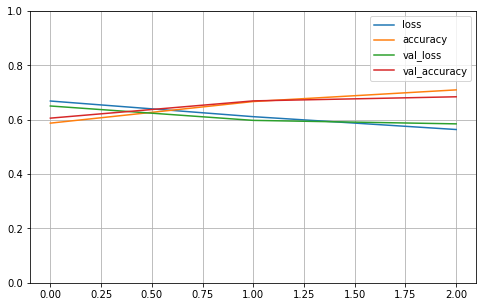

Train set ones/size 7472 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 789 / 1654
Range of scores: 0.012691057 to 0.9890176
Score threshold 0.5
Prediction set ones/size 573 / 1654


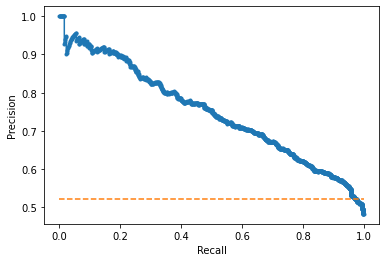

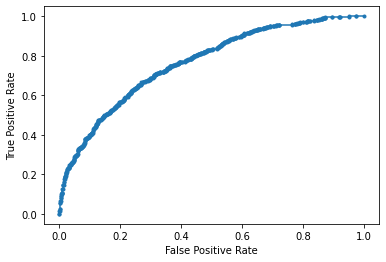

Accuracy: 68.44% Precision: 73.30% Recall: 53.23%
F1: 61.67% AUPRC: 74.98% AUROC: 76.61%
2023-02-07 15:16:49.136974
Fold 3
RCI mean derived from training set: -0.2846416293146083
RCI threshold derived from training set: -0.2846416293146083
FIT
2023-02-07 15:16:55.566814
PREDICT
2023-02-07 15:17:17.520794


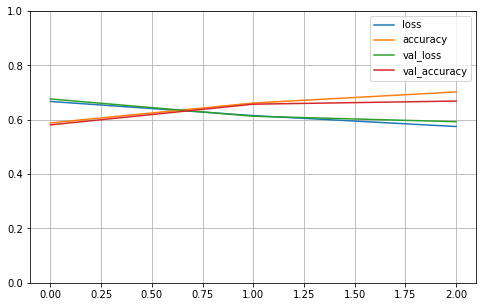

Train set ones/size 7418 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 846 / 1654
Range of scores: 0.02416497 to 0.98684895
Score threshold 0.5
Prediction set ones/size 918 / 1654


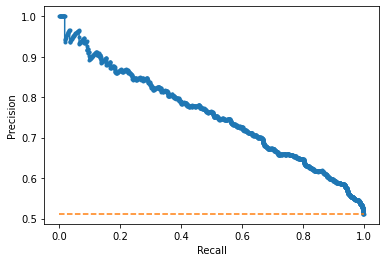

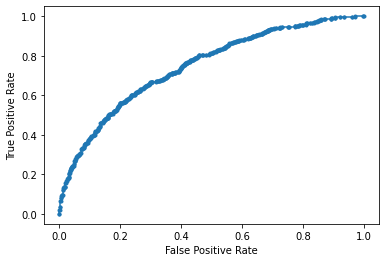

Accuracy: 66.87% Precision: 66.23% Recall: 71.87%
F1: 68.93% AUPRC: 75.59% AUROC: 74.77%
2023-02-07 15:17:18.307697
Fold 4
RCI mean derived from training set: -0.2841060262625991
RCI threshold derived from training set: -0.2841060262625991
FIT
2023-02-07 15:17:24.008499
PREDICT
2023-02-07 15:17:45.975959


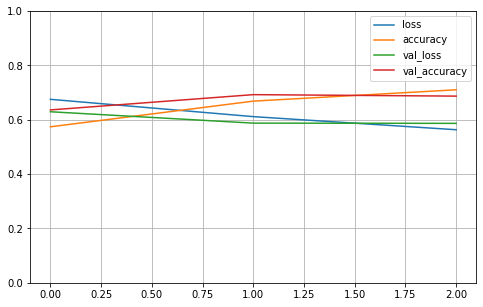

Train set ones/size 7416 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 848 / 1654
Range of scores: 0.061864264 to 0.9962729
Score threshold 0.5
Prediction set ones/size 1088 / 1654


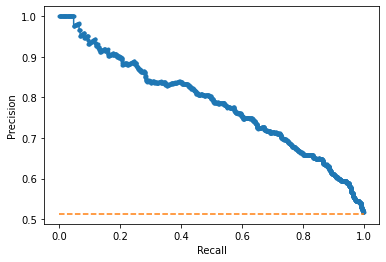

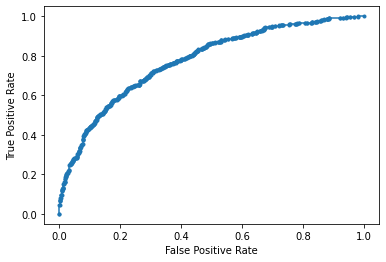

Accuracy: 68.68% Precision: 65.17% Recall: 83.61%
F1: 73.24% AUPRC: 78.39% AUROC: 77.49%
2023-02-07 15:17:46.890492
Fold 5
RCI mean derived from training set: -0.2888123344866282
RCI threshold derived from training set: -0.2888123344866282
FIT
2023-02-07 15:17:52.634395
PREDICT
2023-02-07 15:18:14.988993


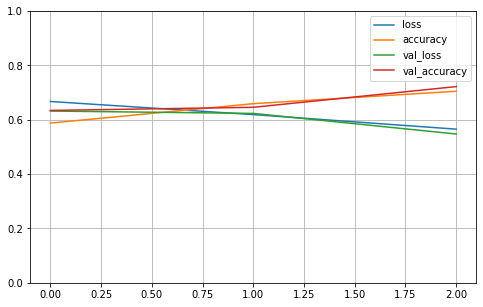

Train set ones/size 7408 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 856 / 1654
Range of scores: 0.02334474 to 0.9858137
Score threshold 0.5
Prediction set ones/size 840 / 1654


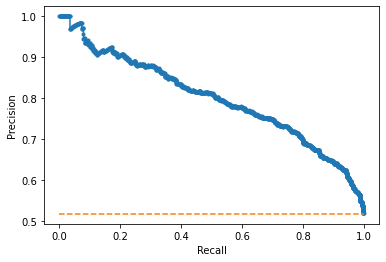

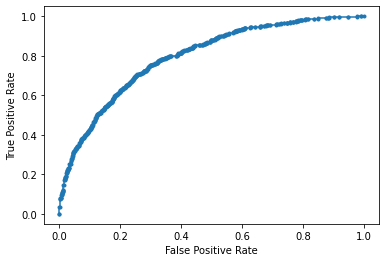

Accuracy: 72.19% Precision: 73.57% Recall: 72.20%
F1: 72.88% AUPRC: 79.98% AUROC: 79.53%
2023-02-07 15:18:15.789453
Fold 6
RCI mean derived from training set: -0.2858548136823007
RCI threshold derived from training set: -0.2858548136823007
FIT
2023-02-07 15:18:23.070564
PREDICT
2023-02-07 15:18:45.028970


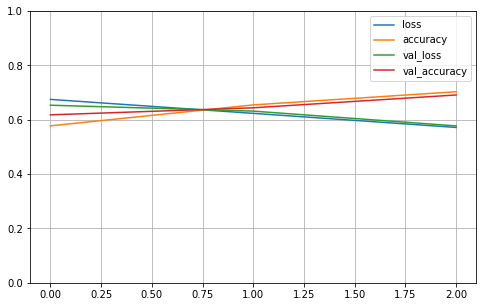

Train set ones/size 7422 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 842 / 1654
Range of scores: 0.015973033 to 0.97523457
Score threshold 0.5
Prediction set ones/size 903 / 1654


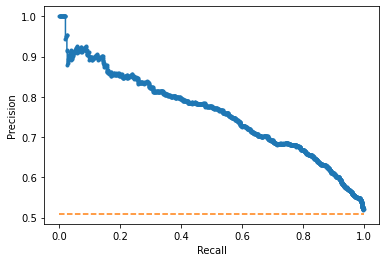

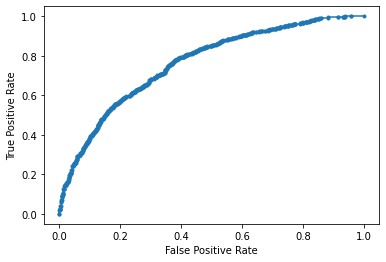

Accuracy: 69.11% Precision: 68.33% Recall: 73.28%
F1: 70.72% AUPRC: 75.98% AUROC: 76.36%
2023-02-07 15:18:45.917803
Fold 7
RCI mean derived from training set: -0.28354508167439363
RCI threshold derived from training set: -0.28354508167439363
FIT
2023-02-07 15:18:52.286409
PREDICT
2023-02-07 15:19:07.680524


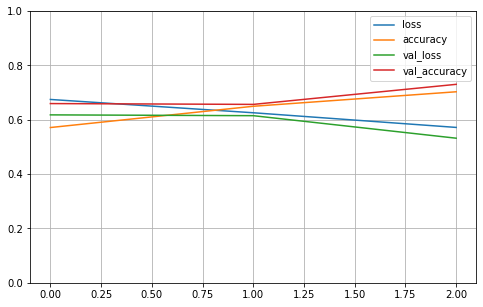

Train set ones/size 7446 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 818 / 1653
Range of scores: 0.0027274182 to 0.99192625
Score threshold 0.5
Prediction set ones/size 854 / 1653


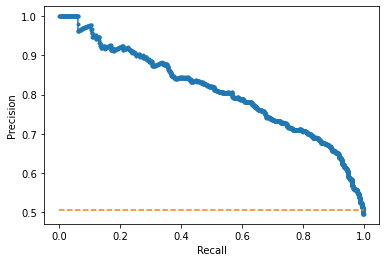

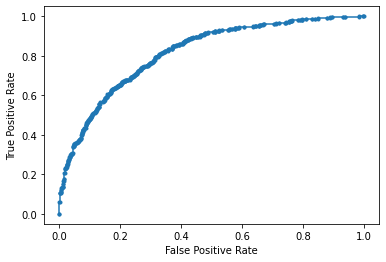

Accuracy: 73.02% Precision: 71.78% Recall: 74.94%
F1: 73.33% AUPRC: 80.88% AUROC: 81.66%
2023-02-07 15:19:08.436158
Fold 8
RCI mean derived from training set: -0.27972968674662363
RCI threshold derived from training set: -0.27972968674662363
FIT
2023-02-07 15:19:15.721937
PREDICT
2023-02-07 15:19:31.090198


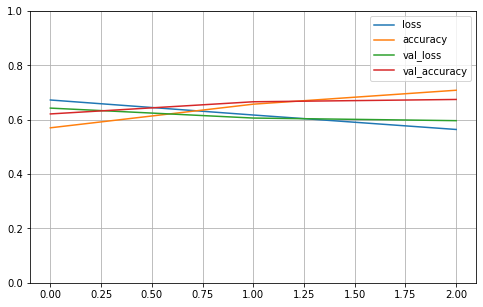

Train set ones/size 7448 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 813 / 1653
Range of scores: 0.023626728 to 0.9957467
Score threshold 0.5
Prediction set ones/size 1041 / 1653


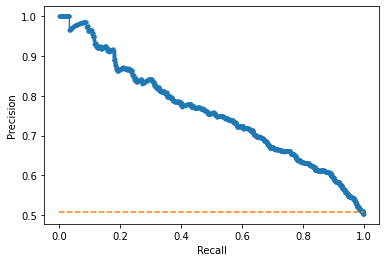

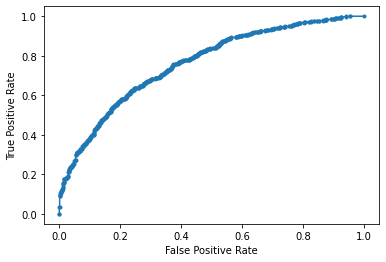

Accuracy: 67.45% Precision: 63.21% Recall: 80.93%
F1: 70.98% AUPRC: 75.89% AUROC: 76.18%
2023-02-07 15:19:31.834242
Fold 9
RCI mean derived from training set: -0.2802676957286837
RCI threshold derived from training set: -0.2802676957286837
FIT
2023-02-07 15:19:37.601874
PREDICT
2023-02-07 15:19:53.159794


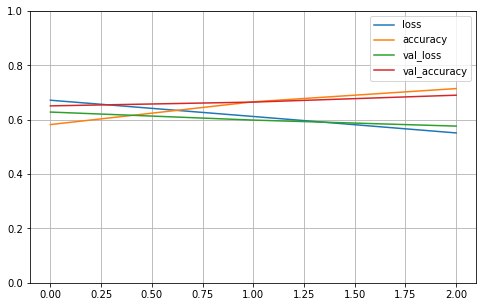

Train set ones/size 7456 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 805 / 1653
Range of scores: 0.014954656 to 0.993561
Score threshold 0.5
Prediction set ones/size 1043 / 1653


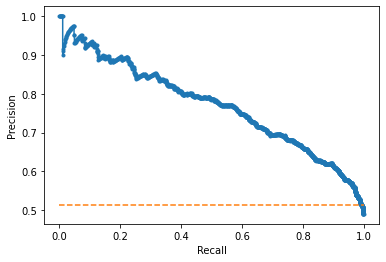

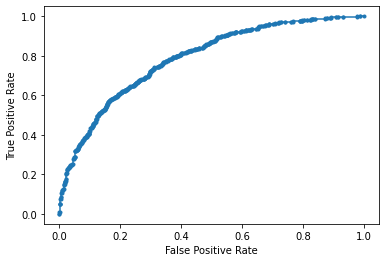

Accuracy: 69.03% Precision: 64.05% Recall: 82.98%
F1: 72.29% AUPRC: 77.10% AUROC: 78.68%
2023-02-07 15:19:54.297096
Fold 10
RCI mean derived from training set: -0.28432212661761747
RCI threshold derived from training set: -0.28432212661761747
FIT
2023-02-07 15:20:00.334650
PREDICT
2023-02-07 15:20:22.287907


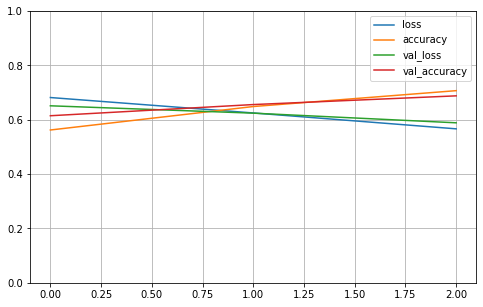

Train set ones/size 7445 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 819 / 1653
Range of scores: 0.019141397 to 0.99344516
Score threshold 0.5
Prediction set ones/size 1025 / 1653


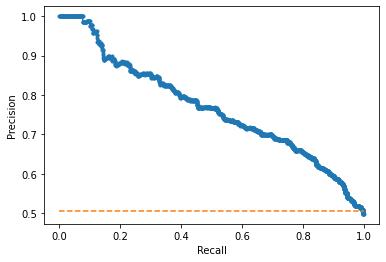

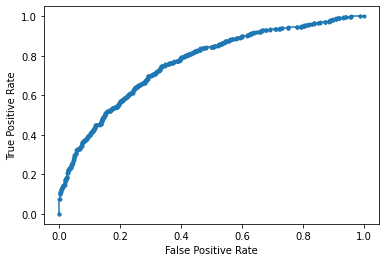

Accuracy: 68.78% Precision: 64.78% Recall: 81.07%
F1: 72.02% AUPRC: 76.81% AUROC: 76.60%
2023-02-07 15:20:23.078177

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.20% +/- 1.93
 precision mean 68.55% +/- 4.48
 recall mean 72.94% +/- 10.80
 F1 mean 69.98% +/- 4.09
 AUPRC mean 77.11% +/- 2.01
 AUROC mean 77.41% +/- 2.01
Finished cell Line 1 H1.hESC

2023-02-07 15:20:24.657092
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-07 15:20:33.179563
splitting
Fold 1
RCI mean derived from training set: -1.283539943874046
RCI threshold derived from training set: -1.283539943874046
FIT
2023-02-07 15:20:36.004447
PREDICT
2023-02-07 15:20:42.069262


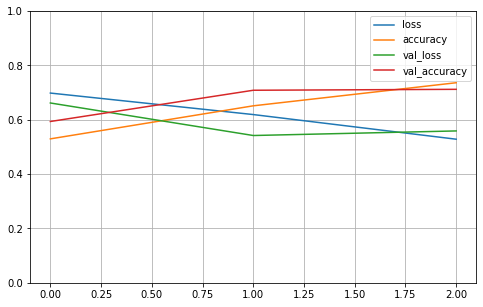

Train set ones/size 2529 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 277 / 583
Range of scores: 0.00247407 to 0.94960797
Score threshold 0.5
Prediction set ones/size 135 / 583


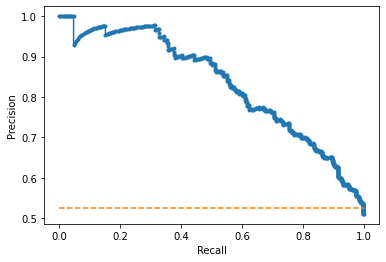

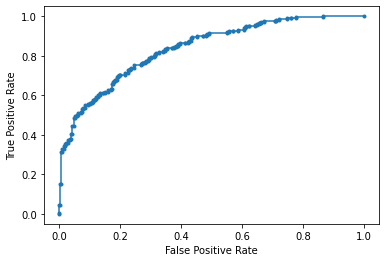

Accuracy: 71.18% Precision: 90.37% Recall: 44.04%
F1: 59.22% AUPRC: 83.40% AUROC: 83.83%
2023-02-07 15:20:42.704571
Fold 2
RCI mean derived from training set: -1.2804343327099237
RCI threshold derived from training set: -1.2804343327099237
FIT
2023-02-07 15:20:45.541173
PREDICT
2023-02-07 15:20:56.951040


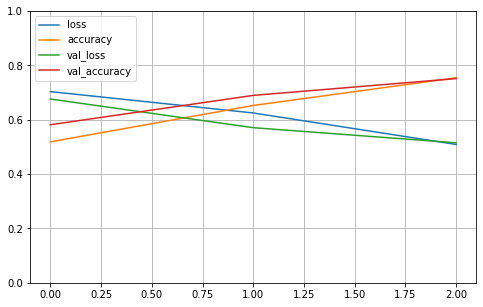

Train set ones/size 2532 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 274 / 583
Range of scores: 0.0023392544 to 0.98020065
Score threshold 0.5
Prediction set ones/size 219 / 583


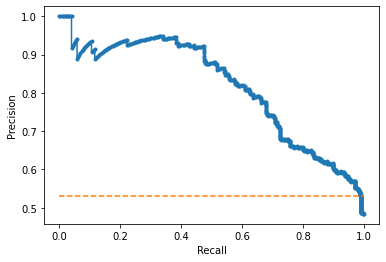

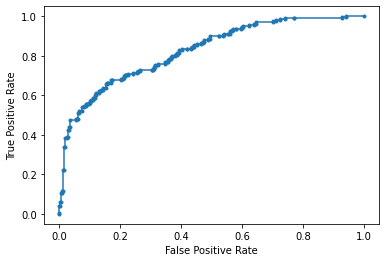

Accuracy: 75.13% Precision: 79.45% Recall: 63.50%
F1: 70.59% AUPRC: 81.67% AUROC: 82.61%
2023-02-07 15:20:57.570299
Fold 3
RCI mean derived from training set: -1.2776195288549619
RCI threshold derived from training set: -1.2776195288549619
FIT
2023-02-07 15:21:01.397638
PREDICT
2023-02-07 15:21:07.733178


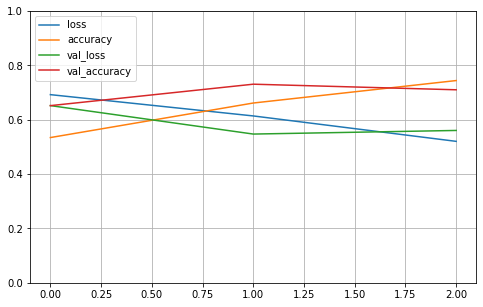

Train set ones/size 2501 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 265 / 583
Range of scores: 0.0047467924 to 0.9540628
Score threshold 0.5
Prediction set ones/size 132 / 583


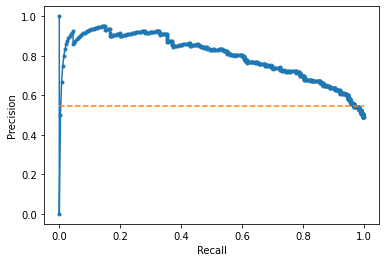

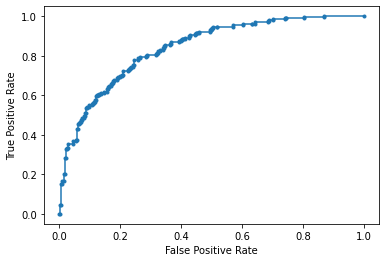

Accuracy: 71.01% Precision: 86.36% Recall: 43.02%
F1: 57.43% AUPRC: 79.79% AUROC: 84.06%
2023-02-07 15:21:08.368031
Fold 4
RCI mean derived from training set: -1.2759836982064492
RCI threshold derived from training set: -1.2759836982064492
FIT
2023-02-07 15:21:11.185488
PREDICT
2023-02-07 15:21:17.542749


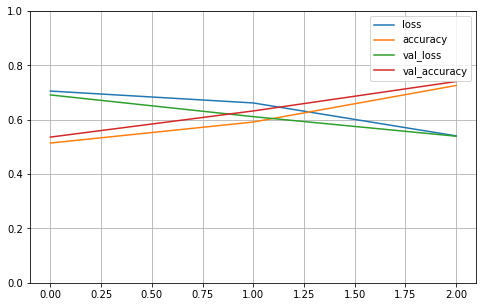

Train set ones/size 2508 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 258 / 582
Range of scores: 0.0093581 to 0.97620183
Score threshold 0.5
Prediction set ones/size 183 / 582


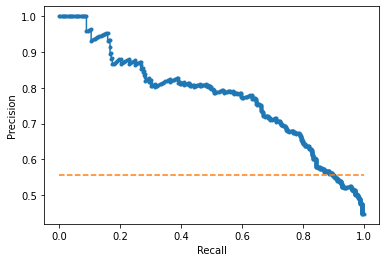

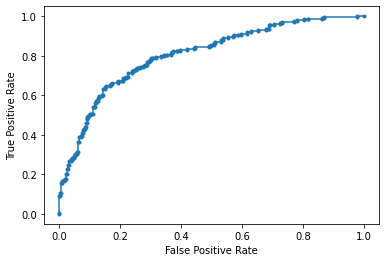

Accuracy: 74.05% Precision: 79.23% Recall: 56.20%
F1: 65.76% AUPRC: 77.38% AUROC: 80.64%
2023-02-07 15:21:18.170451
Fold 5
RCI mean derived from training set: -1.2879645047891624
RCI threshold derived from training set: -1.2879645047891624
FIT
2023-02-07 15:21:21.007653
PREDICT
2023-02-07 15:21:32.137924


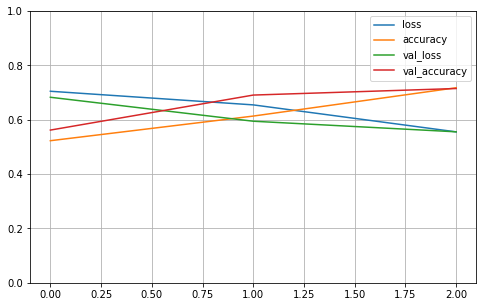

Train set ones/size 2523 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 284 / 582
Range of scores: 0.005680755 to 0.9494636
Score threshold 0.5
Prediction set ones/size 166 / 582


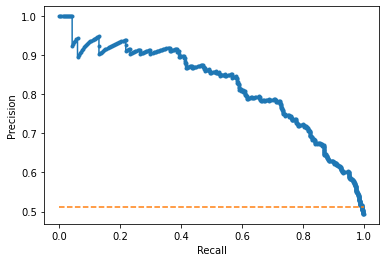

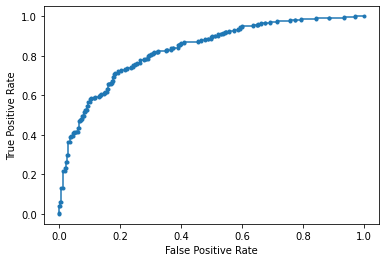

Accuracy: 71.48% Precision: 85.54% Recall: 50.00%
F1: 63.11% AUPRC: 82.25% AUROC: 83.12%
2023-02-07 15:21:32.721276
Fold 6
RCI mean derived from training set: -1.285638432093112
RCI threshold derived from training set: -1.285638432093112
FIT
2023-02-07 15:21:35.571536
PREDICT
2023-02-07 15:21:41.718152


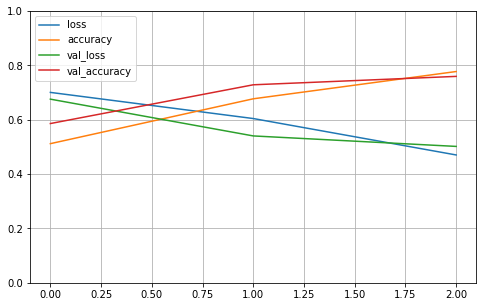

Train set ones/size 2525 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 282 / 582
Range of scores: 0.0068999296 to 0.9923873
Score threshold 0.5
Prediction set ones/size 308 / 582


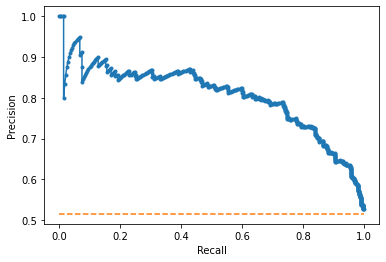

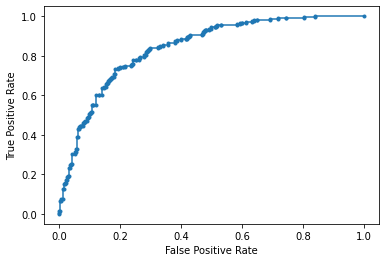

Accuracy: 75.95% Precision: 73.05% Recall: 79.79%
F1: 76.27% AUPRC: 80.48% AUROC: 84.08%
2023-02-07 15:21:42.294491
Fold 7
RCI mean derived from training set: -1.3007761754245373
RCI threshold derived from training set: -1.3007761754245373
FIT
2023-02-07 15:21:45.141197
PREDICT
2023-02-07 15:21:51.176860


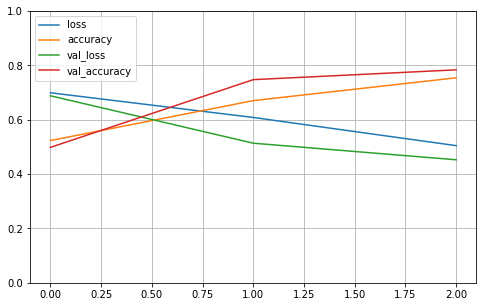

Train set ones/size 2520 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 303 / 582
Range of scores: 0.011471191 to 0.99416685
Score threshold 0.5
Prediction set ones/size 323 / 582


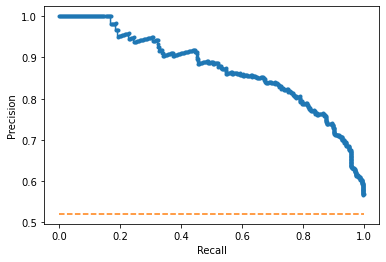

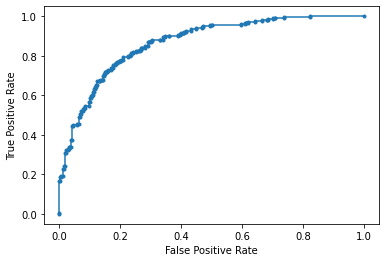

Accuracy: 78.35% Precision: 77.40% Recall: 82.51%
F1: 79.87% AUPRC: 87.23% AUROC: 86.75%
2023-02-07 15:21:51.751698
Fold 8
RCI mean derived from training set: -1.278800849303568
RCI threshold derived from training set: -1.278800849303568
FIT
2023-02-07 15:21:55.281885
PREDICT
2023-02-07 15:22:01.163150


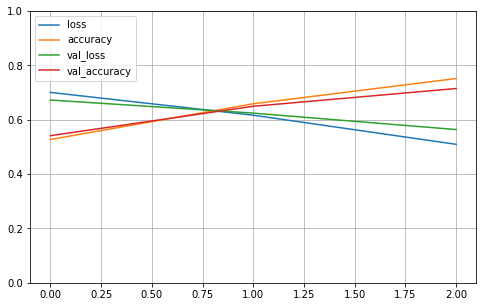

Train set ones/size 2529 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 277 / 582
Range of scores: 0.0018422182 to 0.97047645
Score threshold 0.5
Prediction set ones/size 225 / 582


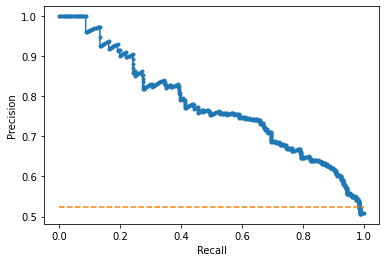

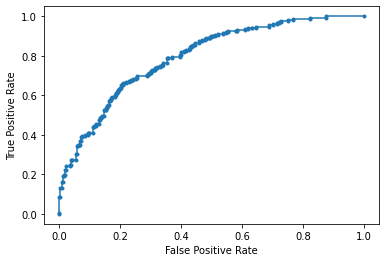

Accuracy: 71.48% Precision: 74.67% Recall: 60.65%
F1: 66.93% AUPRC: 77.66% AUROC: 79.43%
2023-02-07 15:22:01.744882
Fold 9
RCI mean derived from training set: -1.2968693947910706
RCI threshold derived from training set: -1.2968693947910706
FIT
2023-02-07 15:22:04.696718
PREDICT
2023-02-07 15:22:11.051000


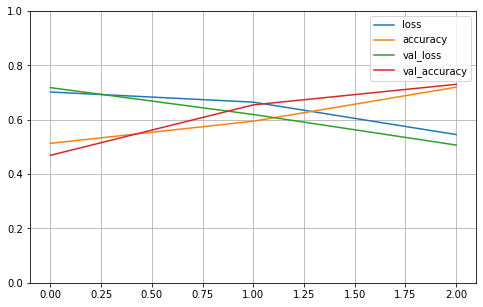

Train set ones/size 2498 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 309 / 582
Range of scores: 0.014394995 to 0.9770183
Score threshold 0.5
Prediction set ones/size 294 / 582


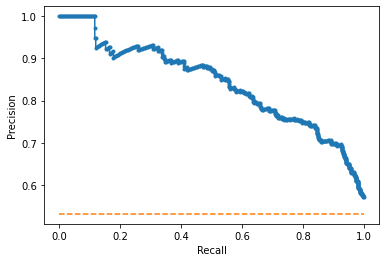

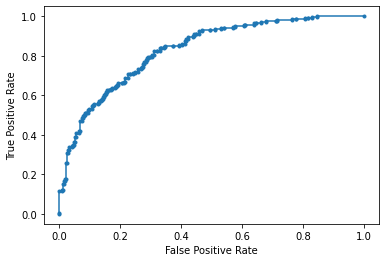

Accuracy: 73.02% Precision: 75.85% Recall: 72.17%
F1: 73.96% AUPRC: 84.11% AUROC: 83.04%
2023-02-07 15:22:11.677751
Fold 10
RCI mean derived from training set: -1.2907133534439992
RCI threshold derived from training set: -1.2907133534439992
FIT
2023-02-07 15:22:14.520472
PREDICT
2023-02-07 15:22:25.659438


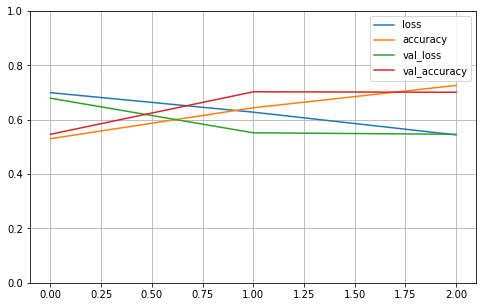

Train set ones/size 2534 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 273 / 582
Range of scores: 0.009224035 to 0.9312226
Score threshold 0.5
Prediction set ones/size 179 / 582


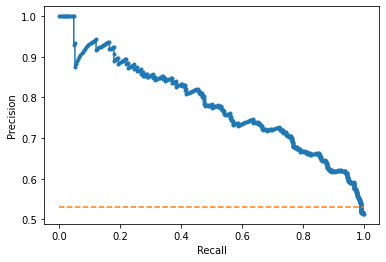

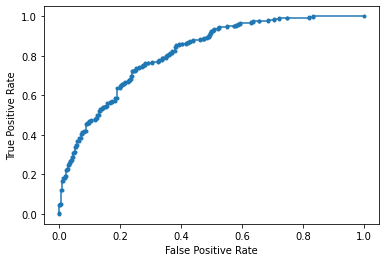

Accuracy: 70.10% Precision: 77.65% Recall: 50.92%
F1: 61.50% AUPRC: 78.29% AUROC: 81.52%
2023-02-07 15:22:26.269357

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.18% +/- 2.64
 precision mean 79.96% +/- 5.64
 recall mean 60.28% +/- 14.13
 F1 mean 67.47% +/- 7.53
 AUPRC mean 81.22% +/- 3.14
 AUROC mean 82.91% +/- 2.05
Finished cell Line 2 HeLa.S3

2023-02-07 15:22:27.594314
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-07 15:22:41.165194
splitting
Fold 1
RCI mean derived from training set: -1.0839654720302832
RCI threshold derived from training set: -1.0839654720302832
FIT
2023-02-07 15:22:43.379417
PREDICT
2023-02-07 15:22:51.939395


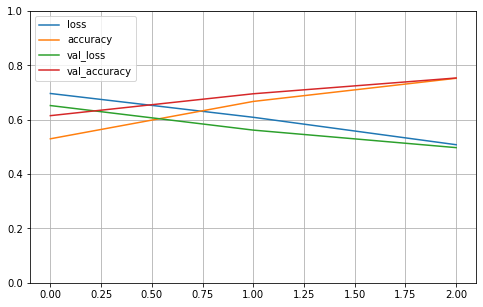

Train set ones/size 3643 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 415 / 844
Range of scores: 0.00063672196 to 0.9920719
Score threshold 0.5
Prediction set ones/size 433 / 844


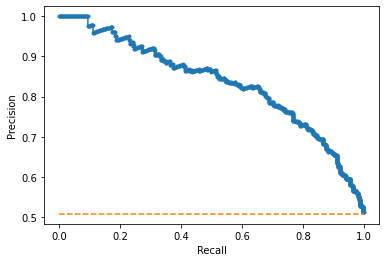

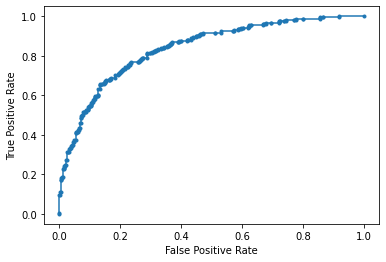

Accuracy: 75.36% Precision: 73.90% Recall: 77.11%
F1: 75.47% AUPRC: 83.52% AUROC: 83.82%
2023-02-07 15:22:52.577393
Fold 2
RCI mean derived from training set: -1.0801516686556945
RCI threshold derived from training set: -1.0801516686556945
FIT
2023-02-07 15:22:56.129772
PREDICT
2023-02-07 15:23:07.423763


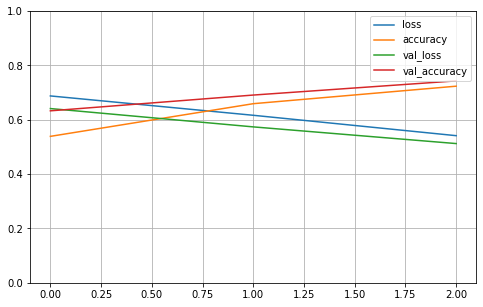

Train set ones/size 3642 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 400 / 844
Range of scores: 0.006428383 to 0.9687459
Score threshold 0.5
Prediction set ones/size 351 / 844


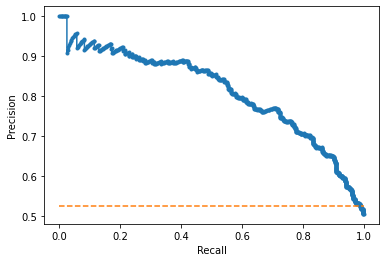

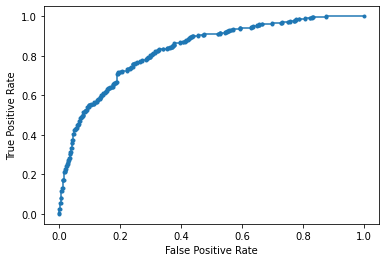

Accuracy: 74.29% Precision: 76.07% Recall: 66.75%
F1: 71.11% AUPRC: 81.14% AUROC: 83.21%
2023-02-07 15:23:08.070397
Fold 3
RCI mean derived from training set: -1.0755342854325212
RCI threshold derived from training set: -1.0755342854325212
FIT
2023-02-07 15:23:11.910033
PREDICT
2023-02-07 15:23:23.516109


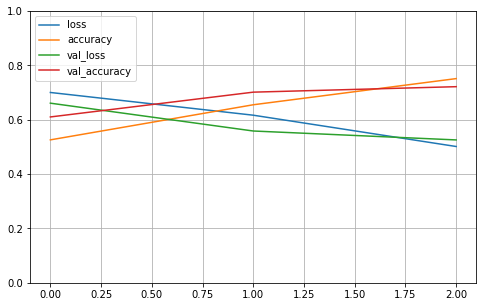

Train set ones/size 3656 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 386 / 844
Range of scores: 0.0020181166 to 0.97930235
Score threshold 0.5
Prediction set ones/size 285 / 844


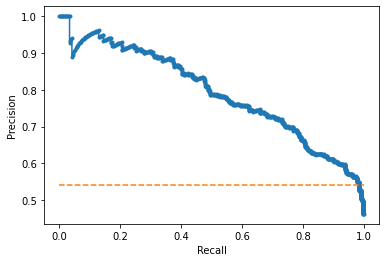

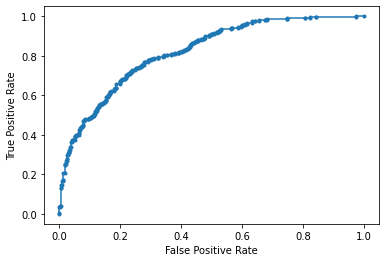

Accuracy: 72.16% Precision: 76.49% Recall: 56.48%
F1: 64.98% AUPRC: 79.29% AUROC: 82.12%
2023-02-07 15:23:24.155874
Fold 4
RCI mean derived from training set: -1.07985061436208
RCI threshold derived from training set: -1.07985061436208
FIT
2023-02-07 15:23:28.535451
PREDICT
2023-02-07 15:23:36.613829


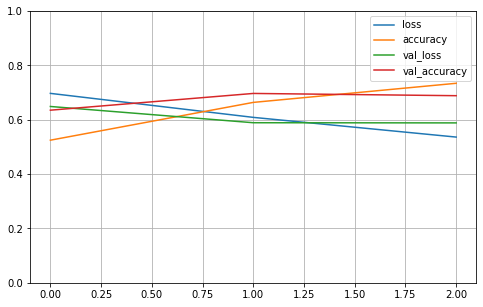

Train set ones/size 3646 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 396 / 844
Range of scores: 0.034803357 to 0.9864417
Score threshold 0.5
Prediction set ones/size 565 / 844


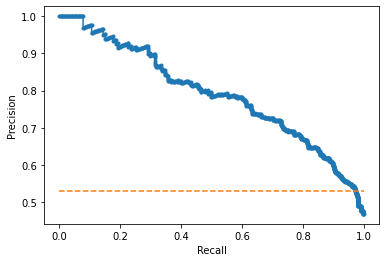

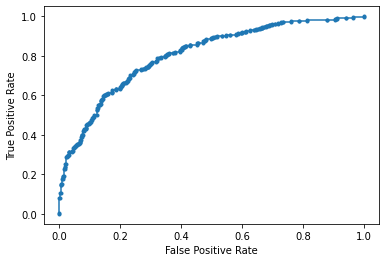

Accuracy: 68.84% Precision: 61.77% Recall: 88.13%
F1: 72.63% AUPRC: 79.25% AUROC: 80.54%
2023-02-07 15:23:37.271827
Fold 5
RCI mean derived from training set: -1.0818529347004608
RCI threshold derived from training set: -1.0818529347004608
FIT
2023-02-07 15:23:41.559748
PREDICT
2023-02-07 15:23:49.598470


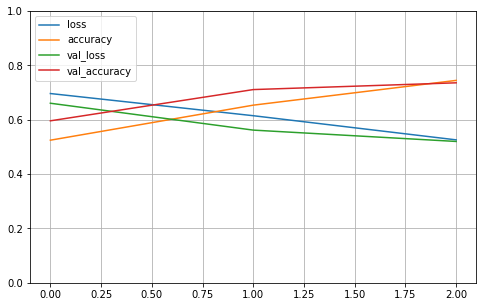

Train set ones/size 3631 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 418 / 844
Range of scores: 0.011503382 to 0.98759043
Score threshold 0.5
Prediction set ones/size 459 / 844


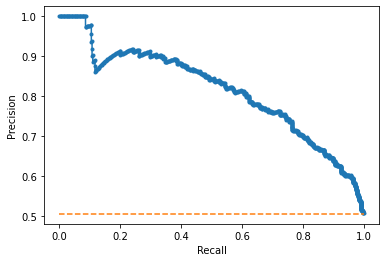

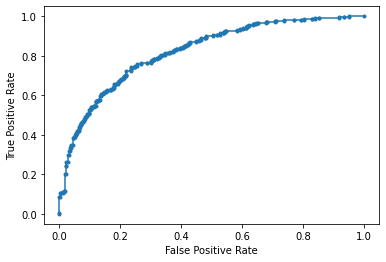

Accuracy: 73.58% Precision: 71.24% Recall: 78.23%
F1: 74.57% AUPRC: 81.59% AUROC: 82.16%
2023-02-07 15:23:50.257204
Fold 6
RCI mean derived from training set: -1.0809142119407504
RCI threshold derived from training set: -1.0809142119407504
FIT
2023-02-07 15:23:54.497717
PREDICT
2023-02-07 15:24:05.777703


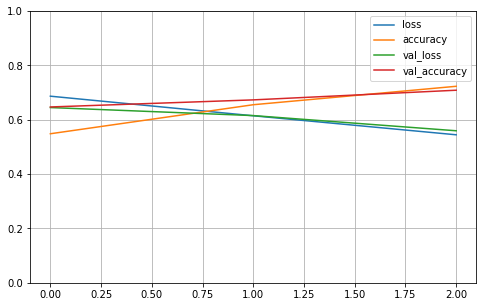

Train set ones/size 3622 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 420 / 844
Range of scores: 0.012035621 to 0.9812151
Score threshold 0.5
Prediction set ones/size 452 / 844


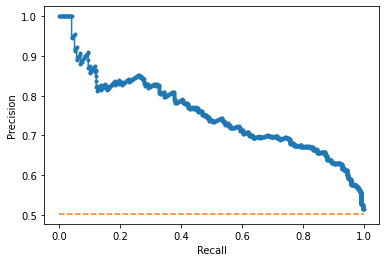

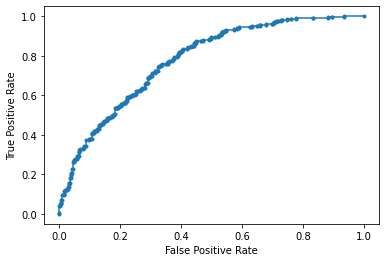

Accuracy: 70.85% Precision: 69.25% Recall: 74.52%
F1: 71.79% AUPRC: 75.51% AUROC: 77.82%
2023-02-07 15:24:06.423136
Fold 7
RCI mean derived from training set: -1.0826895800434497
RCI threshold derived from training set: -1.0826895800434497
FIT
2023-02-07 15:24:09.977741
PREDICT
2023-02-07 15:24:21.265016


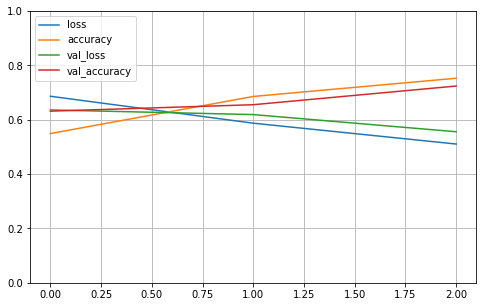

Train set ones/size 3656 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 393 / 844
Range of scores: 0.0037956673 to 0.97093743
Score threshold 0.5
Prediction set ones/size 310 / 844


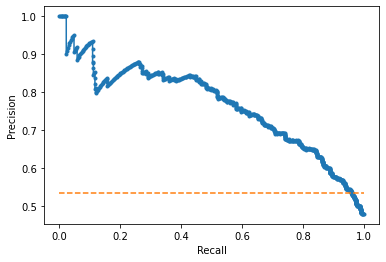

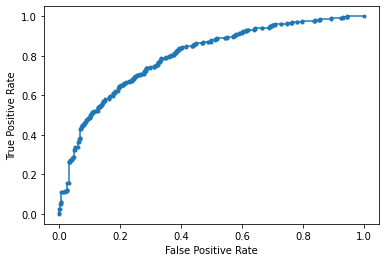

Accuracy: 72.39% Precision: 75.81% Recall: 59.80%
F1: 66.86% AUPRC: 76.60% AUROC: 79.77%
2023-02-07 15:24:21.912102
Fold 8
RCI mean derived from training set: -1.0882789068571428
RCI threshold derived from training set: -1.0882789068571428
FIT
2023-02-07 15:24:25.477155
PREDICT
2023-02-07 15:24:36.779317


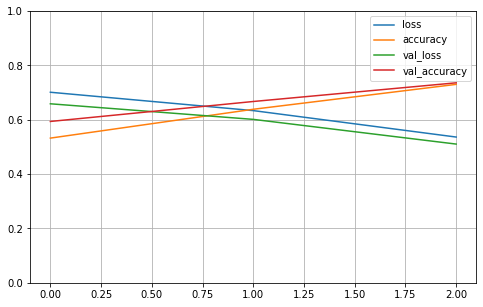

Train set ones/size 3649 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 409 / 844
Range of scores: 0.010413316 to 0.98172724
Score threshold 0.5
Prediction set ones/size 378 / 844


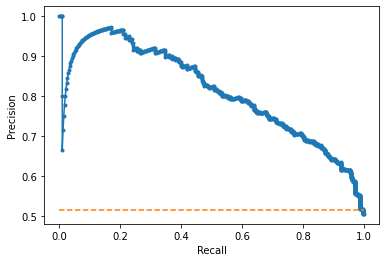

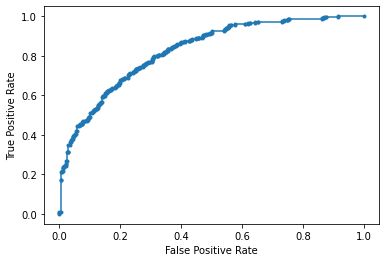

Accuracy: 73.58% Precision: 74.60% Recall: 68.95%
F1: 71.66% AUPRC: 81.16% AUROC: 82.70%
2023-02-07 15:24:37.408427
Fold 9
RCI mean derived from training set: -1.0822446985661618
RCI threshold derived from training set: -1.0822446985661618
FIT
2023-02-07 15:24:41.024072
PREDICT
2023-02-07 15:24:49.627080


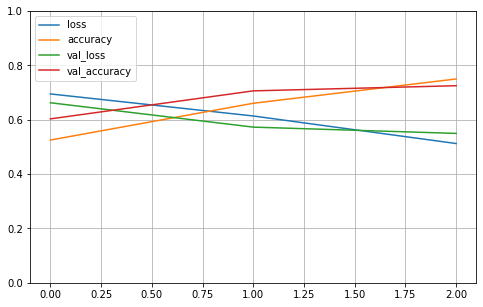

Train set ones/size 3641 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 408 / 844
Range of scores: 0.0028622972 to 0.9783577
Score threshold 0.5
Prediction set ones/size 266 / 844


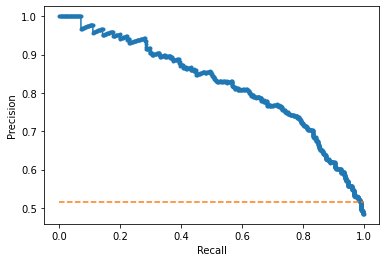

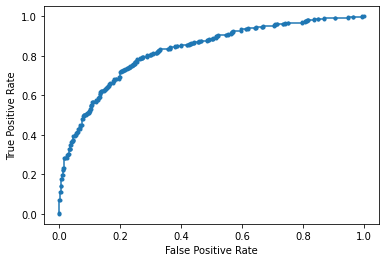

Accuracy: 72.51% Precision: 83.08% Recall: 54.17%
F1: 65.58% AUPRC: 82.31% AUROC: 82.54%
2023-02-07 15:24:50.267535
Fold 10
RCI mean derived from training set: -1.0828875017048445
RCI threshold derived from training set: -1.0828875017048445
FIT
2023-02-07 15:24:53.825858
PREDICT
2023-02-07 15:25:05.090363


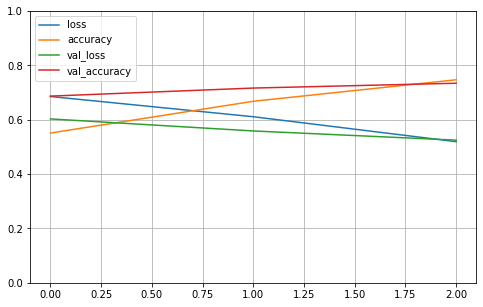

Train set ones/size 3650 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 408 / 843
Range of scores: 0.008981829 to 0.9761972
Score threshold 0.5
Prediction set ones/size 310 / 843


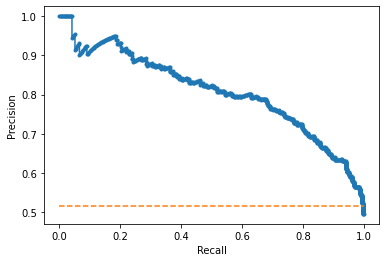

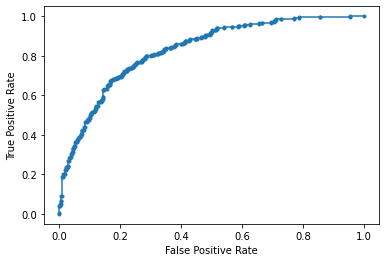

Accuracy: 73.43% Precision: 79.68% Recall: 60.54%
F1: 68.80% AUPRC: 80.87% AUROC: 82.91%
2023-02-07 15:25:05.730235

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.70% +/- 1.84
 precision mean 74.19% +/- 5.85
 recall mean 68.47% +/- 10.97
 F1 mean 70.35% +/- 3.65
 AUPRC mean 80.12% +/- 2.50
 AUROC mean 81.76% +/- 1.84
Finished cell Line 3 HepG2

2023-02-07 15:25:07.114447
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-07 15:25:18.783726
splitting
Fold 1
RCI mean derived from training set: -0.2837299268113891
RCI threshold derived from training set: -0.2837299268113891
FIT
2023-02-07 15:25:20.685354
PREDICT
2023-02-07 15:25:27.999080


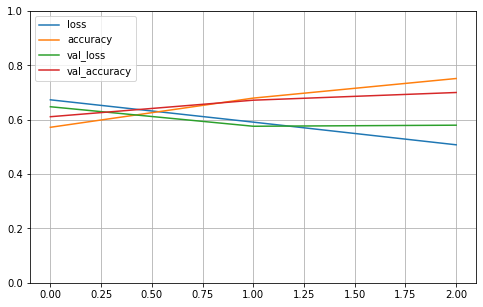

Train set ones/size 3056 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 341 / 707
Range of scores: 0.019409267 to 0.9959193
Score threshold 0.5
Prediction set ones/size 493 / 707


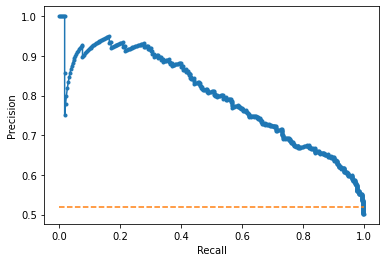

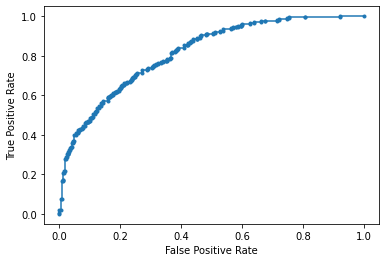

Accuracy: 70.01% Precision: 63.08% Recall: 91.20%
F1: 74.58% AUPRC: 79.65% AUROC: 81.59%
2023-02-07 15:25:28.589190
Fold 2
RCI mean derived from training set: -0.2753148000880919
RCI threshold derived from training set: -0.2753148000880919
FIT
2023-02-07 15:25:31.787113
PREDICT
2023-02-07 15:25:39.052906


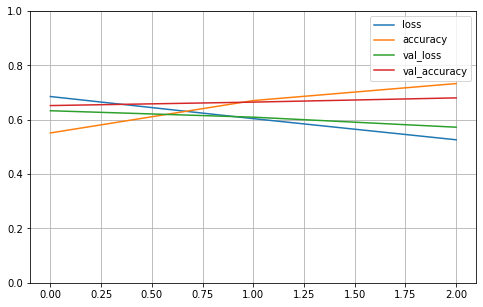

Train set ones/size 3063 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 327 / 707
Range of scores: 0.017356178 to 0.99067676
Score threshold 0.5
Prediction set ones/size 395 / 707


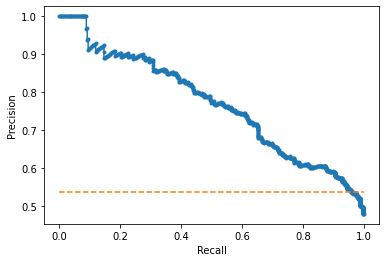

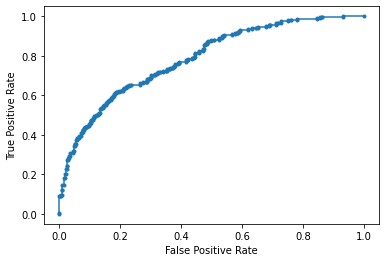

Accuracy: 68.03% Precision: 62.78% Recall: 75.84%
F1: 68.70% AUPRC: 76.93% AUROC: 78.73%
2023-02-07 15:25:39.700088
Fold 3
RCI mean derived from training set: -0.2789730485228881
RCI threshold derived from training set: -0.2789730485228881
FIT
2023-02-07 15:25:42.851846
PREDICT
2023-02-07 15:25:54.046868


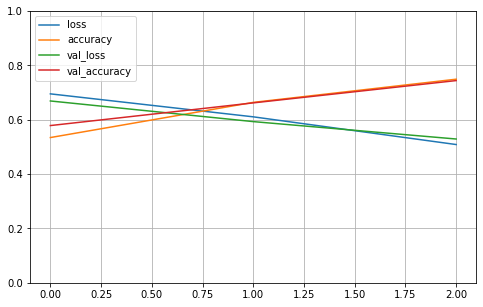

Train set ones/size 3051 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 340 / 707
Range of scores: 0.0030890666 to 0.99339336
Score threshold 0.5
Prediction set ones/size 455 / 707


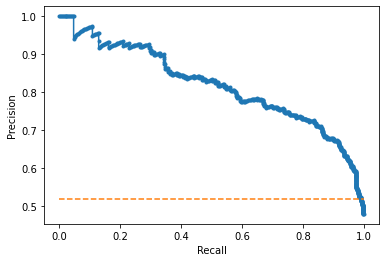

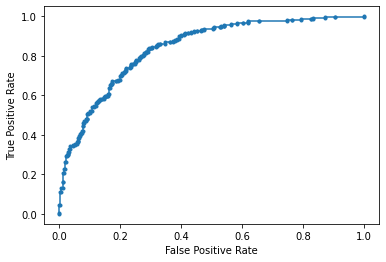

Accuracy: 74.40% Precision: 67.47% Recall: 90.29%
F1: 77.23% AUPRC: 81.96% AUROC: 83.96%
2023-02-07 15:25:54.650659
Fold 4
RCI mean derived from training set: -0.2888440364338524
RCI threshold derived from training set: -0.2888440364338524
FIT
2023-02-07 15:25:57.833754
PREDICT
2023-02-07 15:26:04.969927


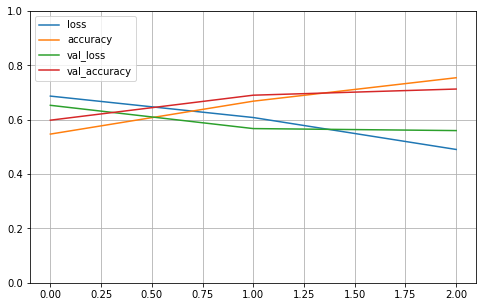

Train set ones/size 3042 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 358 / 707
Range of scores: 0.0018555155 to 0.99223
Score threshold 0.5
Prediction set ones/size 313 / 707


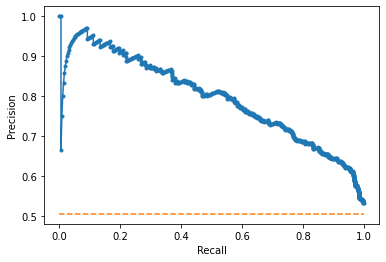

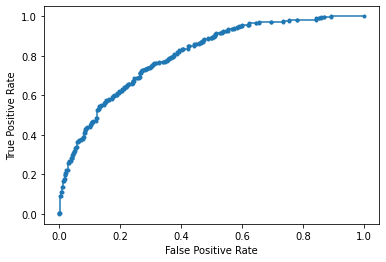

Accuracy: 71.29% Precision: 74.76% Recall: 65.36%
F1: 69.75% AUPRC: 79.62% AUROC: 80.35%
2023-02-07 15:26:05.619965
Fold 5
RCI mean derived from training set: -0.2832924759452658
RCI threshold derived from training set: -0.2832924759452658
FIT
2023-02-07 15:26:08.787865
PREDICT
2023-02-07 15:26:15.809081


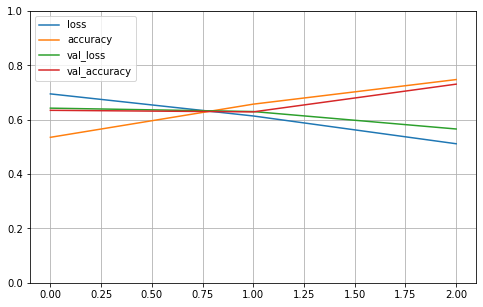

Train set ones/size 3058 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 339 / 706
Range of scores: 0.0029764315 to 0.977354
Score threshold 0.5
Prediction set ones/size 261 / 706


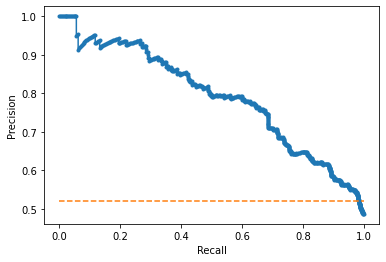

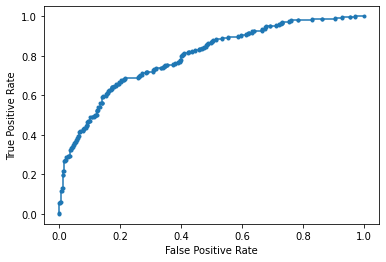

Accuracy: 73.09% Precision: 78.54% Recall: 60.47%
F1: 68.33% AUPRC: 79.23% AUROC: 79.60%
2023-02-07 15:26:16.659760
Fold 6
RCI mean derived from training set: -0.28163197472161056
RCI threshold derived from training set: -0.28163197472161056
FIT
2023-02-07 15:26:19.923744
PREDICT
2023-02-07 15:26:26.872534


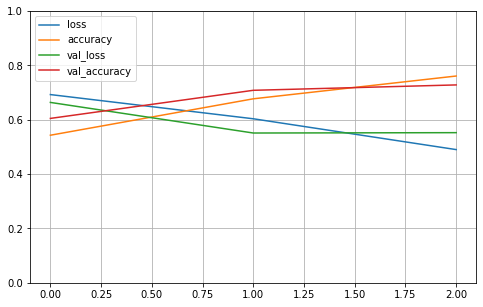

Train set ones/size 3057 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 340 / 706
Range of scores: 0.0013535015 to 0.9908749
Score threshold 0.5
Prediction set ones/size 268 / 706


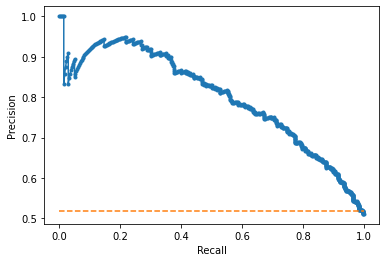

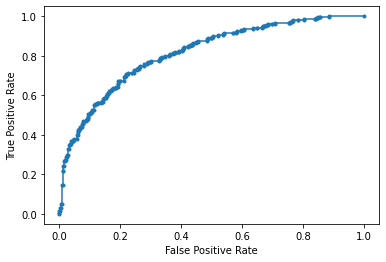

Accuracy: 72.80% Precision: 77.61% Recall: 61.18%
F1: 68.42% AUPRC: 80.05% AUROC: 81.45%
2023-02-07 15:26:27.523173
Fold 7
RCI mean derived from training set: -0.28862815410978293
RCI threshold derived from training set: -0.28862815410978293
FIT
2023-02-07 15:26:31.447180
PREDICT
2023-02-07 15:26:38.311862


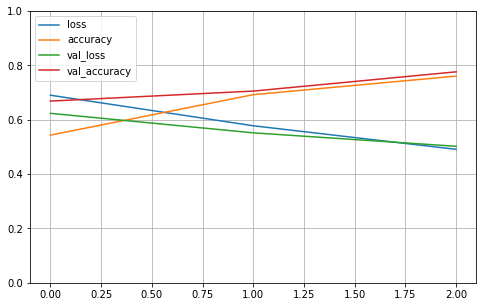

Train set ones/size 3046 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 354 / 706
Range of scores: 0.003973668 to 0.9969723
Score threshold 0.5
Prediction set ones/size 406 / 706


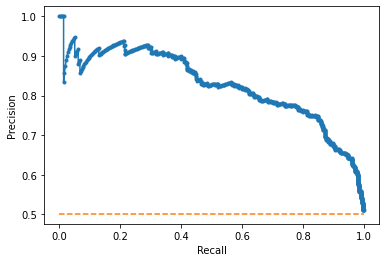

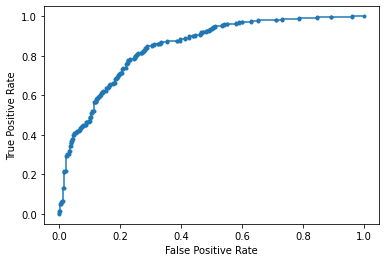

Accuracy: 77.62% Precision: 74.14% Recall: 85.03%
F1: 79.21% AUPRC: 82.60% AUROC: 84.39%
2023-02-07 15:26:38.956304
Fold 8
RCI mean derived from training set: -0.28006548551116706
RCI threshold derived from training set: -0.28006548551116706
FIT
2023-02-07 15:26:43.488798
PREDICT
2023-02-07 15:26:50.516847


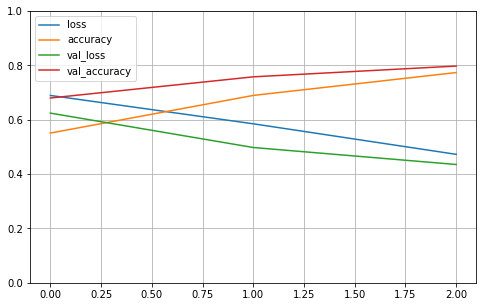

Train set ones/size 3072 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 320 / 706
Range of scores: 0.0047760177 to 0.996132
Score threshold 0.5
Prediction set ones/size 313 / 706


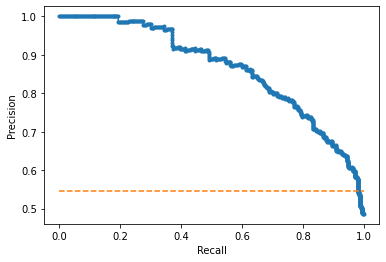

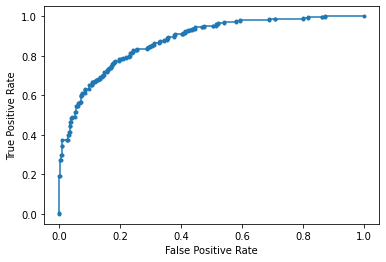

Accuracy: 79.75% Precision: 78.27% Recall: 76.56%
F1: 77.41% AUPRC: 86.61% AUROC: 87.78%
2023-02-07 15:26:51.122238
Fold 9
RCI mean derived from training set: -0.28685858487889276
RCI threshold derived from training set: -0.28685858487889276
FIT
2023-02-07 15:26:54.611737
PREDICT
2023-02-07 15:27:01.968803


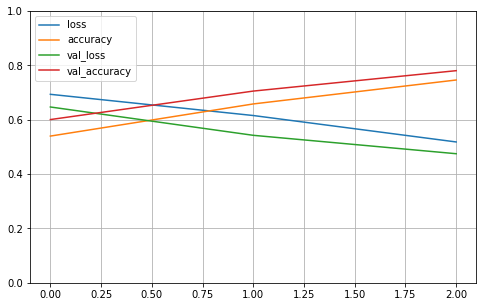

Train set ones/size 3067 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 333 / 706
Range of scores: 0.006657213 to 0.9845018
Score threshold 0.5
Prediction set ones/size 330 / 706


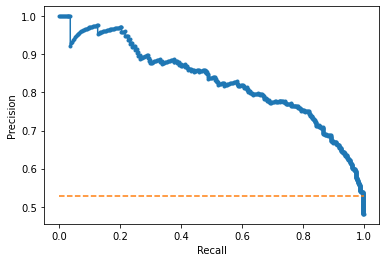

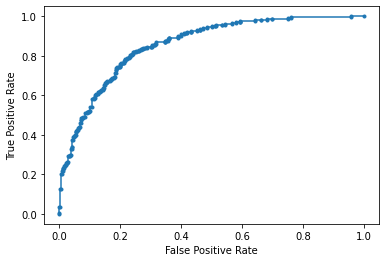

Accuracy: 78.05% Precision: 76.97% Recall: 76.28%
F1: 76.62% AUPRC: 83.14% AUROC: 85.59%
2023-02-07 15:27:02.604980
Fold 10
RCI mean derived from training set: -0.28572198597986787
RCI threshold derived from training set: -0.28572198597986787
FIT
2023-02-07 15:27:05.779323
PREDICT
2023-02-07 15:27:13.038324


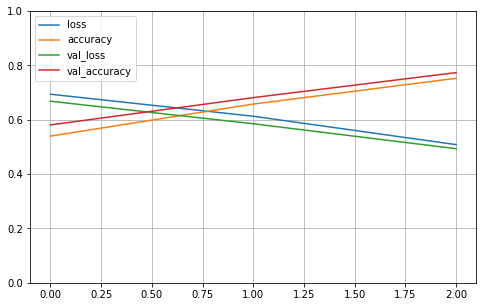

Train set ones/size 3053 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 344 / 706
Range of scores: 0.0046877414 to 0.9915746
Score threshold 0.5
Prediction set ones/size 350 / 706


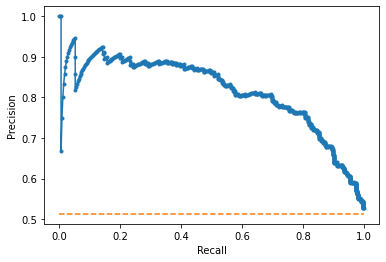

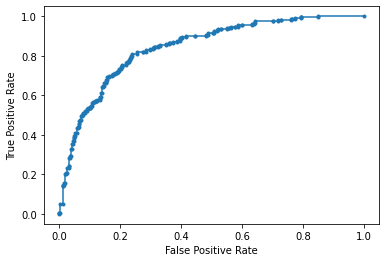

Accuracy: 77.34% Precision: 76.29% Recall: 77.62%
F1: 76.95% AUPRC: 81.48% AUROC: 84.34%
2023-02-07 15:27:13.632913

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.24% +/- 3.86
 precision mean 72.99% +/- 6.18
 recall mean 75.98% +/- 11.03
 F1 mean 73.72% +/- 4.39
 AUPRC mean 81.13% +/- 2.67
 AUROC mean 82.78% +/- 2.88
Finished cell Line 4 HT1080

2023-02-07 15:27:14.972674
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-07 15:27:30.075646
splitting
Fold 1
RCI mean derived from training set: -0.9598692552699883
RCI threshold derived from training set: -0.9598692552699883
FIT
2023-02-07 15:27:32.576326
PREDICT
2023-02-07 15:27:41.916069


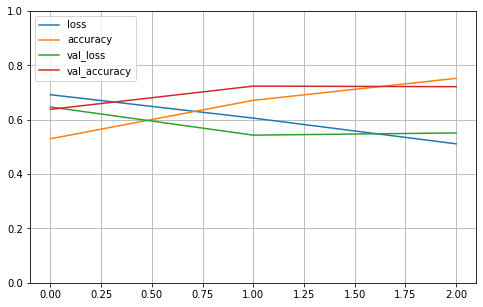

Train set ones/size 4431 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 505 / 959
Range of scores: 0.0016784493 to 0.9865086
Score threshold 0.5
Prediction set ones/size 358 / 959


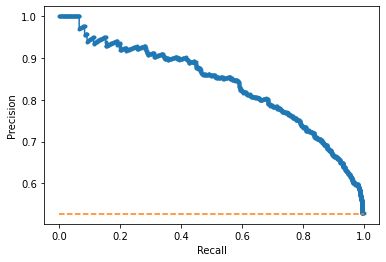

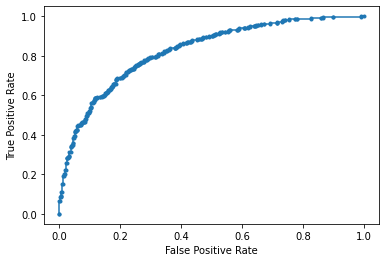

Accuracy: 72.16% Precision: 83.24% Recall: 59.01%
F1: 69.06% AUPRC: 83.74% AUROC: 82.56%
2023-02-07 15:27:42.569803
Fold 2
RCI mean derived from training set: -0.9636234434704518
RCI threshold derived from training set: -0.9636234434704518
FIT
2023-02-07 15:27:46.407755
PREDICT
2023-02-07 15:27:57.835282


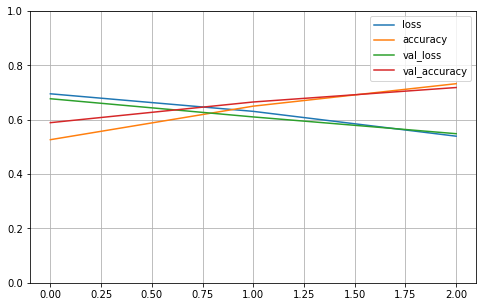

Train set ones/size 4424 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 512 / 959
Range of scores: 0.011101877 to 0.9847707
Score threshold 0.5
Prediction set ones/size 516 / 959


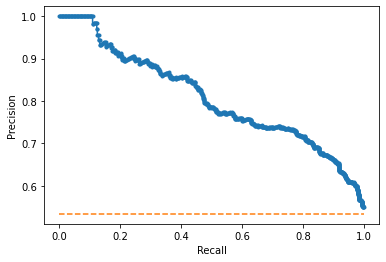

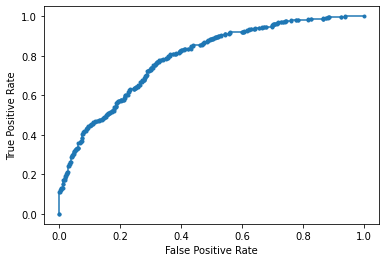

Accuracy: 71.85% Precision: 73.45% Recall: 74.02%
F1: 73.74% AUPRC: 80.82% AUROC: 78.88%
2023-02-07 15:27:58.490651
Fold 3
RCI mean derived from training set: -0.9593738715434531
RCI threshold derived from training set: -0.9593738715434531
FIT
2023-02-07 15:28:03.634967
PREDICT
2023-02-07 15:28:15.078023


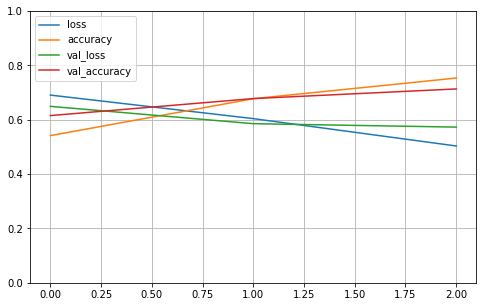

Train set ones/size 4440 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 496 / 959
Range of scores: 0.0045524407 to 0.97144777
Score threshold 0.5
Prediction set ones/size 381 / 959


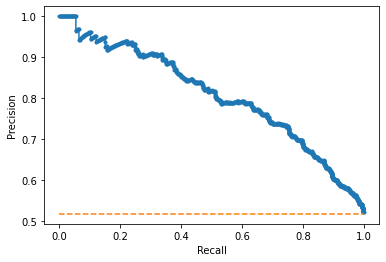

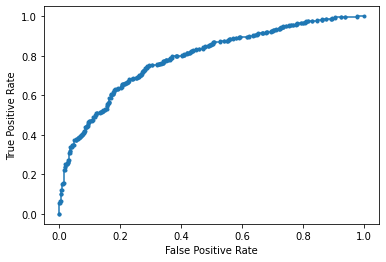

Accuracy: 71.32% Precision: 79.00% Recall: 60.69%
F1: 68.64% AUPRC: 80.71% AUROC: 78.89%
2023-02-07 15:28:16.090702
Fold 4
RCI mean derived from training set: -0.9491514312294321
RCI threshold derived from training set: -0.9491514312294321
FIT
2023-02-07 15:28:20.063571
PREDICT
2023-02-07 15:28:29.398186


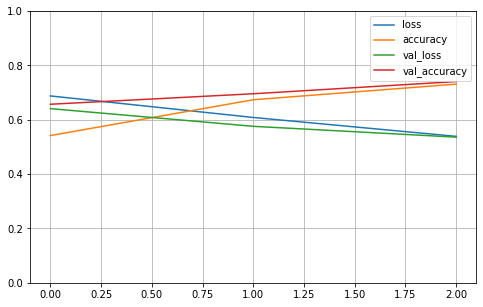

Train set ones/size 4419 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 457 / 959
Range of scores: 0.021430895 to 0.94833165
Score threshold 0.5
Prediction set ones/size 356 / 959


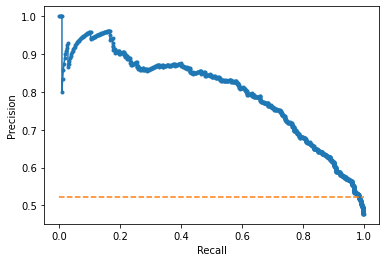

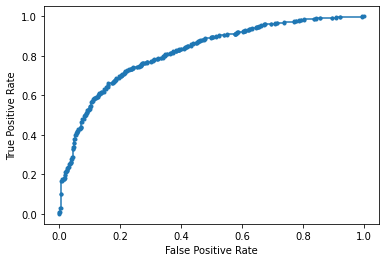

Accuracy: 74.04% Precision: 79.21% Recall: 61.71%
F1: 69.37% AUPRC: 80.08% AUROC: 81.89%
2023-02-07 15:28:30.296326
Fold 5
RCI mean derived from training set: -0.96778603597219
RCI threshold derived from training set: -0.96778603597219
FIT
2023-02-07 15:28:34.150624
PREDICT
2023-02-07 15:28:45.504239


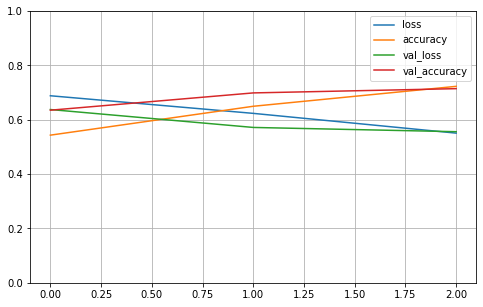

Train set ones/size 4423 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 528 / 959
Range of scores: 0.0043485956 to 0.9716366
Score threshold 0.5
Prediction set ones/size 356 / 959


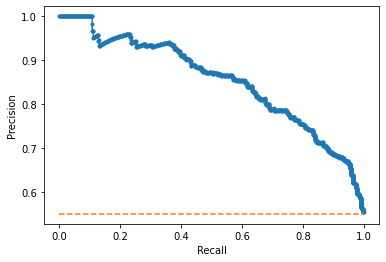

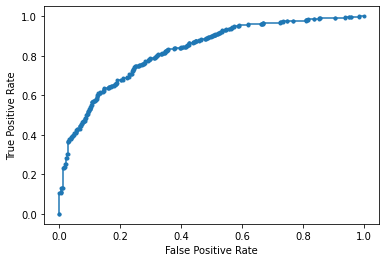

Accuracy: 71.43% Precision: 85.67% Recall: 57.77%
F1: 69.00% AUPRC: 85.41% AUROC: 82.62%
2023-02-07 15:28:46.148929
Fold 6
RCI mean derived from training set: -0.9634300983429895
RCI threshold derived from training set: -0.9634300983429895
FIT
2023-02-07 15:28:50.078010
PREDICT
2023-02-07 15:28:59.438505


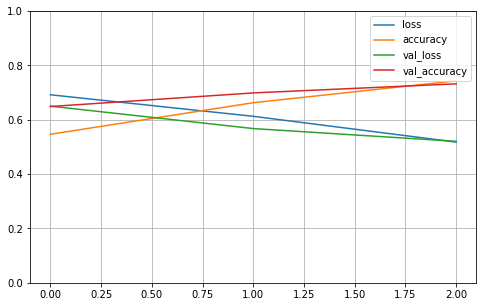

Train set ones/size 4450 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 486 / 959
Range of scores: 0.005018249 to 0.9771419
Score threshold 0.5
Prediction set ones/size 375 / 959


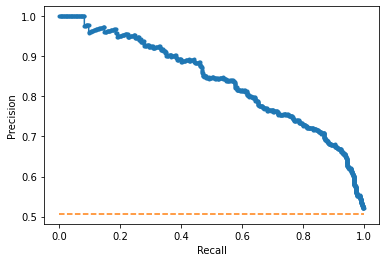

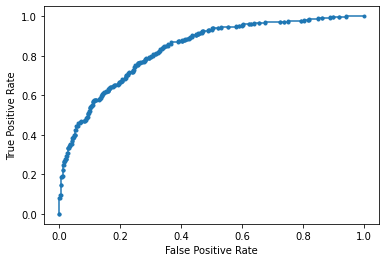

Accuracy: 73.20% Precision: 80.53% Recall: 62.14%
F1: 70.15% AUPRC: 83.87% AUROC: 83.44%
2023-02-07 15:29:00.091562
Fold 7
RCI mean derived from training set: -0.9433161291993047
RCI threshold derived from training set: -0.9433161291993047
FIT
2023-02-07 15:29:03.916474
PREDICT
2023-02-07 15:29:15.273247


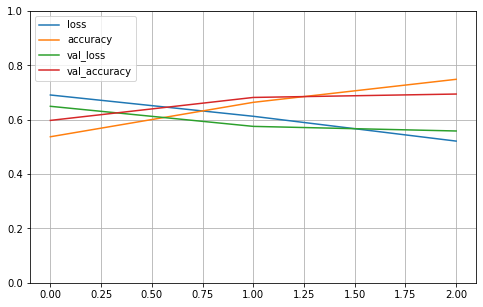

Train set ones/size 4382 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 460 / 959
Range of scores: 0.00197813 to 0.9946679
Score threshold 0.5
Prediction set ones/size 633 / 959


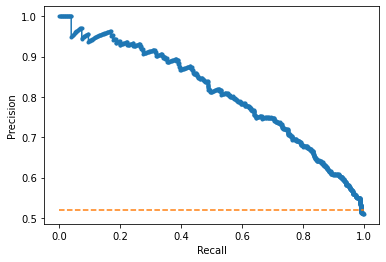

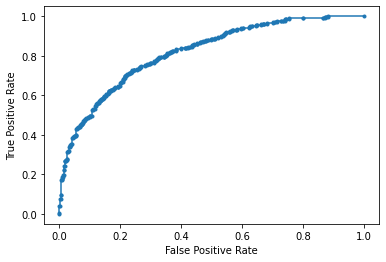

Accuracy: 69.45% Precision: 63.19% Recall: 86.96%
F1: 73.19% AUPRC: 80.96% AUROC: 81.82%
2023-02-07 15:29:15.914857
Fold 8
RCI mean derived from training set: -0.951527679225956
RCI threshold derived from training set: -0.951527679225956
FIT
2023-02-07 15:29:19.809012
PREDICT
2023-02-07 15:29:29.251258


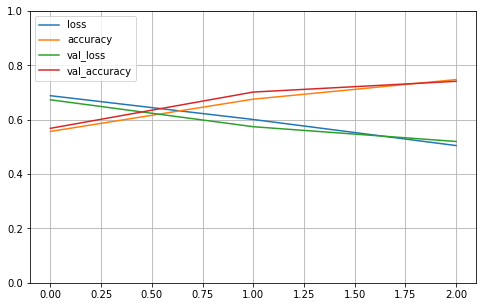

Train set ones/size 4391 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 486 / 959
Range of scores: 0.0012954823 to 0.981899
Score threshold 0.5
Prediction set ones/size 448 / 959


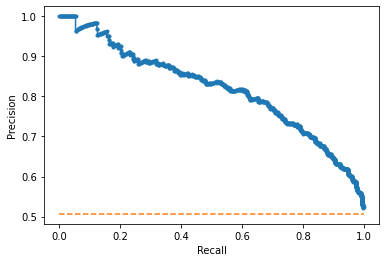

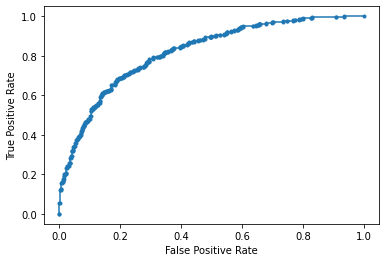

Accuracy: 74.14% Precision: 76.56% Recall: 70.58%
F1: 73.45% AUPRC: 81.97% AUROC: 81.91%
2023-02-07 15:29:29.910036
Fold 9
RCI mean derived from training set: -0.9602096008389339
RCI threshold derived from training set: -0.9602096008389339
FIT
2023-02-07 15:29:34.487741
PREDICT
2023-02-07 15:29:43.796789


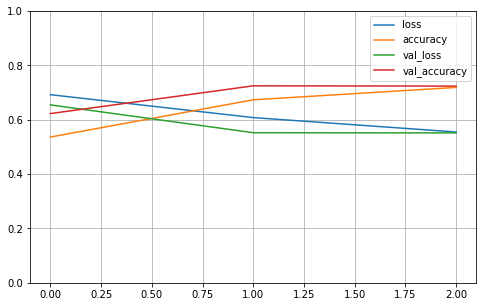

Train set ones/size 4434 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 502 / 959
Range of scores: 0.0028616362 to 0.96477646
Score threshold 0.5
Prediction set ones/size 389 / 959


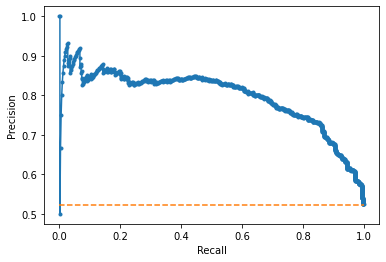

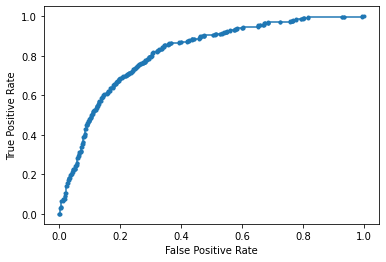

Accuracy: 72.37% Precision: 80.46% Recall: 62.35%
F1: 70.26% AUPRC: 79.67% AUROC: 81.52%
2023-02-07 15:29:44.452131
Fold 10
RCI mean derived from training set: -0.9577084034526707
RCI threshold derived from training set: -0.9577084034526707
FIT
2023-02-07 15:29:49.885707
PREDICT
2023-02-07 15:29:58.837927


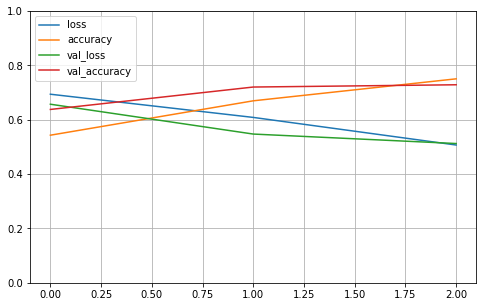

Train set ones/size 4456 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 477 / 958
Range of scores: 0.01197603 to 0.9881529
Score threshold 0.5
Prediction set ones/size 461 / 958


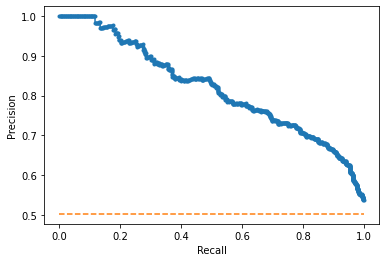

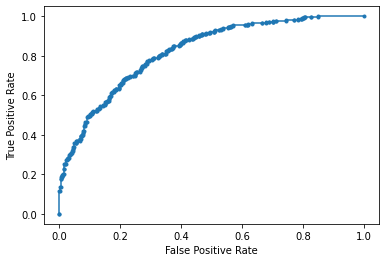

Accuracy: 72.86% Precision: 73.54% Recall: 71.07%
F1: 72.28% AUPRC: 81.93% AUROC: 82.17%
2023-02-07 15:29:59.500628

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.28% +/- 1.40
 precision mean 77.49% +/- 6.33
 recall mean 66.63% +/- 9.05
 F1 mean 70.91% +/- 2.03
 AUPRC mean 81.92% +/- 1.87
 AUROC mean 81.57% +/- 1.51
Finished cell Line 5 HUVEC

2023-02-07 15:30:00.991489
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-07 15:30:19.490707
splitting
Fold 1
RCI mean derived from training set: -1.1349753646536942
RCI threshold derived from training set: -1.1349753646536942
FIT
2023-02-07 15:30:22.501335
PREDICT
2023-02-07 15:30:34.025206


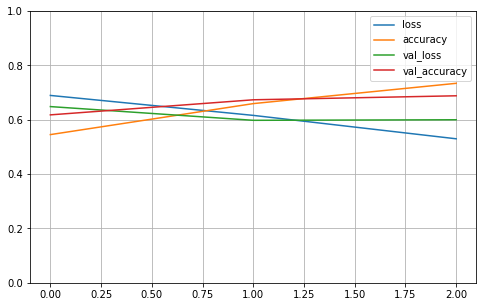

Train set ones/size 5288 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 631 / 1154
Range of scores: 0.0026340755 to 0.98760253
Score threshold 0.5
Prediction set ones/size 397 / 1154


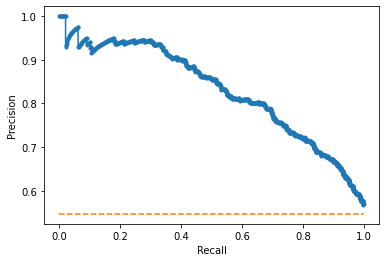

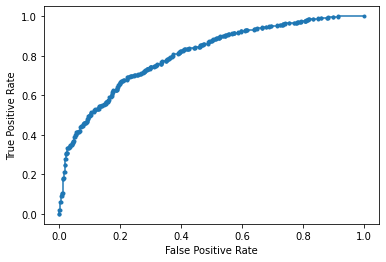

Accuracy: 68.80% Precision: 84.13% Recall: 52.93%
F1: 64.98% AUPRC: 83.19% AUROC: 80.40%
2023-02-07 15:30:34.888702
Fold 2
RCI mean derived from training set: -1.1299156250621327
RCI threshold derived from training set: -1.1299156250621327
FIT
2023-02-07 15:30:39.289493
PREDICT
2023-02-07 15:30:50.567781


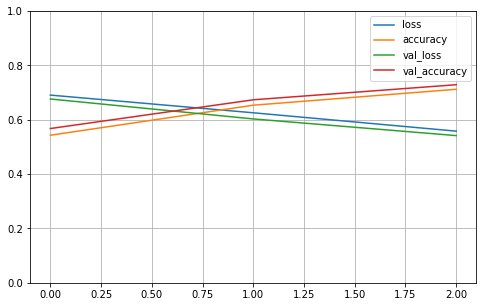

Train set ones/size 5322 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 597 / 1154
Range of scores: 0.009813139 to 0.99108183
Score threshold 0.5
Prediction set ones/size 524 / 1154


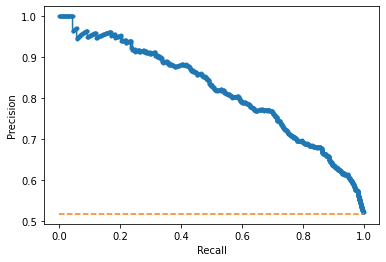

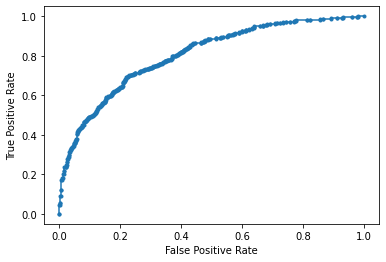

Accuracy: 72.88% Precision: 77.10% Recall: 67.67%
F1: 72.08% AUPRC: 81.87% AUROC: 80.50%
2023-02-07 15:30:51.277551
Fold 3
RCI mean derived from training set: -1.1188958279423948
RCI threshold derived from training set: -1.1188958279423948
FIT
2023-02-07 15:30:57.183134
PREDICT
2023-02-07 15:31:08.468870


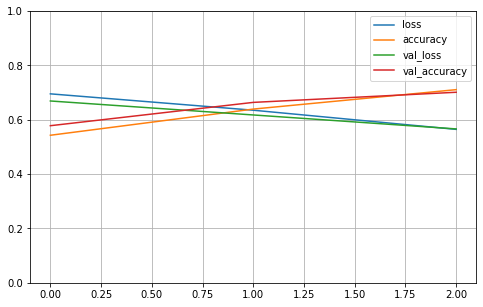

Train set ones/size 5316 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 579 / 1154
Range of scores: 0.023400934 to 0.97548497
Score threshold 0.5
Prediction set ones/size 634 / 1154


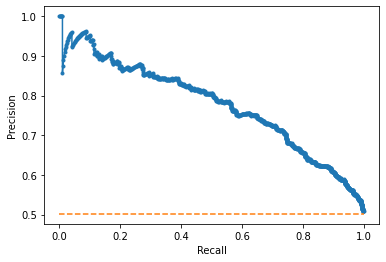

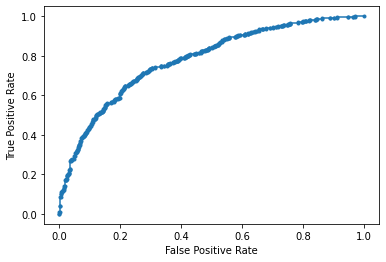

Accuracy: 70.10% Precision: 68.45% Recall: 74.96%
F1: 71.56% AUPRC: 77.79% AUROC: 78.02%
2023-02-07 15:31:09.545284
Fold 4
RCI mean derived from training set: -1.1232048012686637
RCI threshold derived from training set: -1.1232048012686637
FIT
2023-02-07 15:31:13.949883
PREDICT
2023-02-07 15:31:25.106973


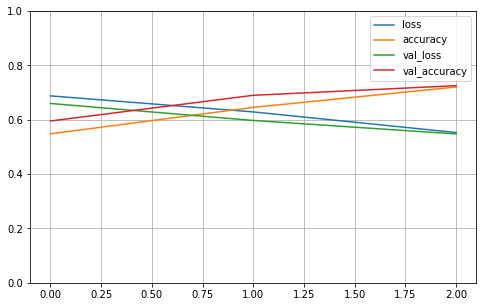

Train set ones/size 5318 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 596 / 1154
Range of scores: 0.009223727 to 0.9897194
Score threshold 0.5
Prediction set ones/size 697 / 1154


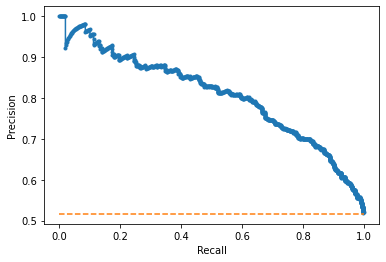

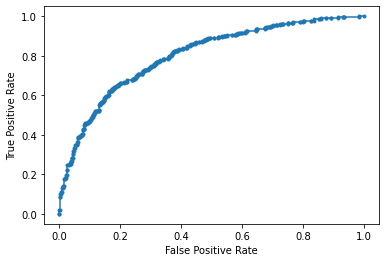

Accuracy: 72.53% Precision: 70.01% Recall: 81.88%
F1: 75.48% AUPRC: 80.80% AUROC: 80.14%
2023-02-07 15:31:25.814083
Fold 5
RCI mean derived from training set: -1.118375560225412
RCI threshold derived from training set: -1.118375560225412
FIT
2023-02-07 15:31:30.221025
PREDICT
2023-02-07 15:31:41.520129


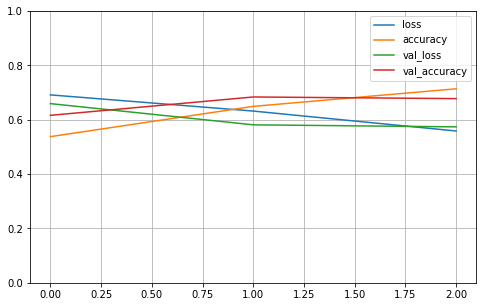

Train set ones/size 5335 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 560 / 1154
Range of scores: 0.026550513 to 0.9835622
Score threshold 0.5
Prediction set ones/size 780 / 1154


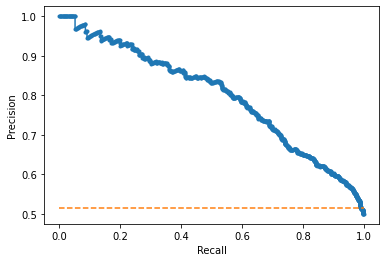

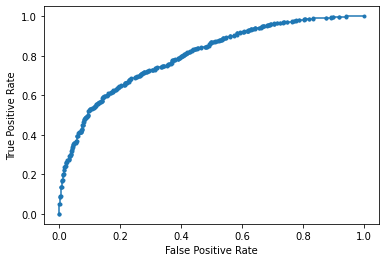

Accuracy: 67.76% Precision: 62.05% Recall: 86.43%
F1: 72.24% AUPRC: 79.95% AUROC: 80.03%
2023-02-07 15:31:42.230684
Fold 6
RCI mean derived from training set: -1.1163208856453477
RCI threshold derived from training set: -1.1163208856453477
FIT
2023-02-07 15:31:46.979538
PREDICT
2023-02-07 15:31:58.806795


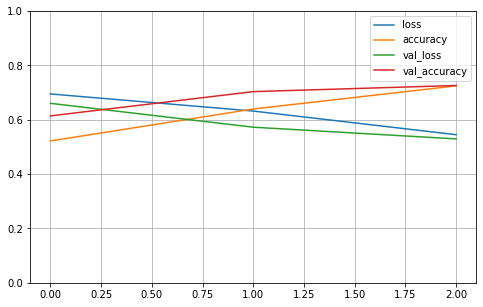

Train set ones/size 5321 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 573 / 1153
Range of scores: 0.007131 to 0.98233116
Score threshold 0.5
Prediction set ones/size 483 / 1153


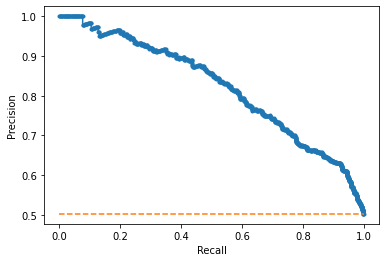

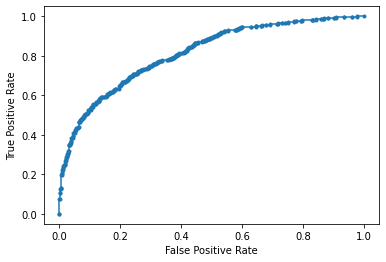

Accuracy: 72.59% Precision: 76.60% Recall: 64.57%
F1: 70.08% AUPRC: 82.22% AUROC: 81.38%
2023-02-07 15:31:59.588818
Fold 7
RCI mean derived from training set: -1.1271018489664804
RCI threshold derived from training set: -1.1271018489664804
FIT
2023-02-07 15:32:04.652601
PREDICT
2023-02-07 15:32:15.650402


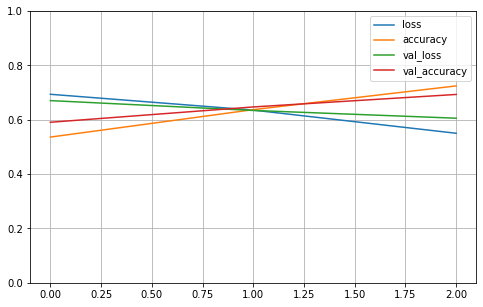

Train set ones/size 5323 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 591 / 1153
Range of scores: 0.011337771 to 0.9815205
Score threshold 0.5
Prediction set ones/size 745 / 1153


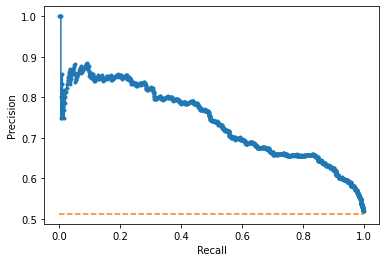

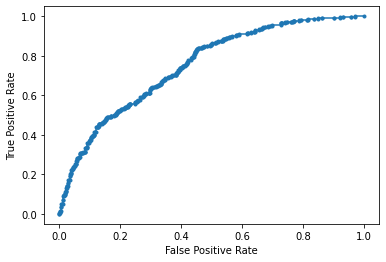

Accuracy: 69.30% Precision: 65.91% Recall: 83.08%
F1: 73.50% AUPRC: 74.07% AUROC: 75.16%
2023-02-07 15:32:16.348305
Fold 8
RCI mean derived from training set: -1.1243382103515702
RCI threshold derived from training set: -1.1243382103515702
FIT
2023-02-07 15:32:20.715781
PREDICT
2023-02-07 15:32:32.162078


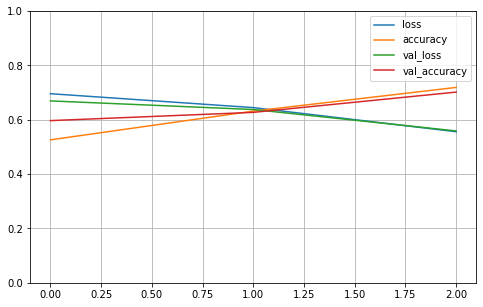

Train set ones/size 5314 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 600 / 1153
Range of scores: 0.011141524 to 0.991495
Score threshold 0.5
Prediction set ones/size 624 / 1153


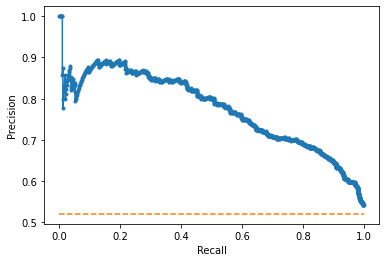

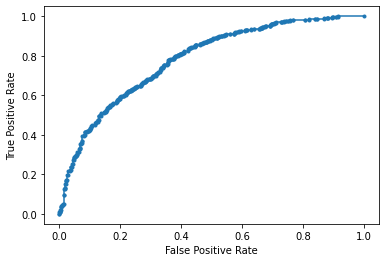

Accuracy: 70.16% Precision: 70.51% Recall: 73.33%
F1: 71.90% AUPRC: 77.52% AUROC: 78.23%
2023-02-07 15:32:32.879332
Fold 9
RCI mean derived from training set: -1.1209396478010016
RCI threshold derived from training set: -1.1209396478010016
FIT
2023-02-07 15:32:37.289691
PREDICT
2023-02-07 15:32:48.422836


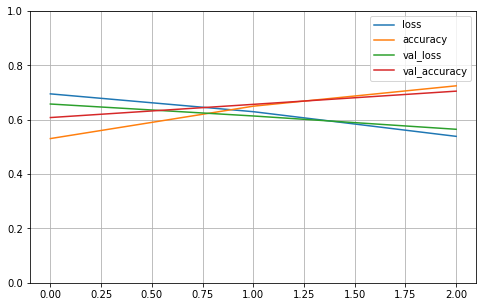

Train set ones/size 5305 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 591 / 1153
Range of scores: 0.0037320165 to 0.9715838
Score threshold 0.5
Prediction set ones/size 437 / 1153


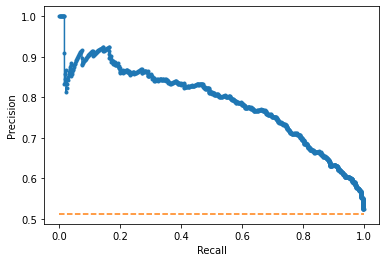

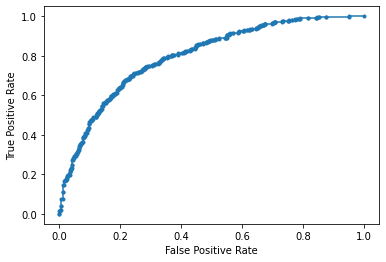

Accuracy: 70.51% Precision: 78.72% Recall: 58.21%
F1: 66.93% AUPRC: 78.89% AUROC: 79.79%
2023-02-07 15:32:49.139778
Fold 10
RCI mean derived from training set: -1.1235682388817185
RCI threshold derived from training set: -1.1235682388817185
FIT
2023-02-07 15:32:54.469461
PREDICT
2023-02-07 15:33:06.211287


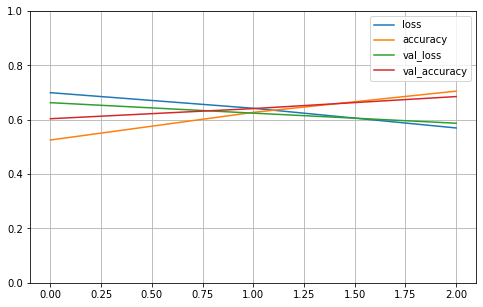

Train set ones/size 5325 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 589 / 1153
Range of scores: 0.0033626773 to 0.9778733
Score threshold 0.5
Prediction set ones/size 548 / 1153


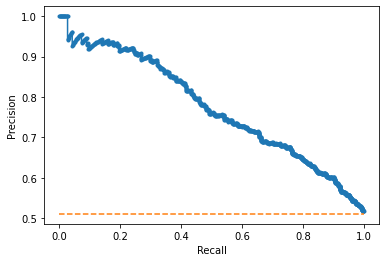

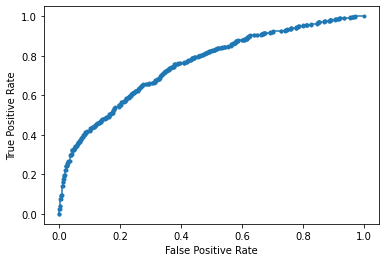

Accuracy: 68.52% Precision: 70.62% Recall: 65.70%
F1: 68.07% AUPRC: 77.59% AUROC: 75.69%
2023-02-07 15:33:07.351413

Completed cross validation 10 folds 3 epochs
 accuracy mean 70.32% +/- 1.82
 precision mean 72.41% +/- 6.62
 recall mean 70.88% +/- 11.02
 F1 mean 70.68% +/- 3.19
 AUPRC mean 79.39% +/- 2.76
 AUROC mean 78.93% +/- 2.11
Finished cell Line 6 MCF.7

2023-02-07 15:33:08.977380
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-07 15:33:16.205760
splitting
Fold 1
RCI mean derived from training set: -1.3083752442899723
RCI threshold derived from training set: -1.3083752442899723
FIT
2023-02-07 15:33:17.662430
PREDICT
2023-02-07 15:33:23.748085


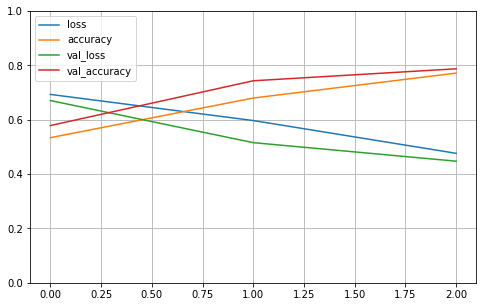

Train set ones/size 2408 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 267 / 522
Range of scores: 0.00749471 to 0.99802184
Score threshold 0.5
Prediction set ones/size 272 / 522


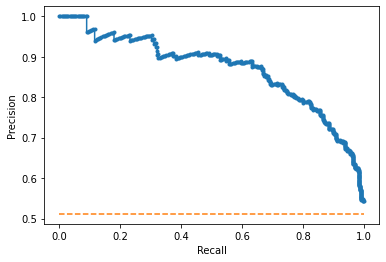

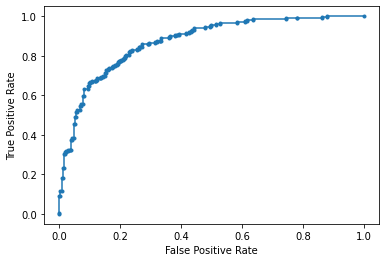

Accuracy: 78.74% Precision: 78.68% Recall: 80.15%
F1: 79.41% AUPRC: 87.03% AUROC: 87.18%
2023-02-07 15:33:24.349222
Fold 2
RCI mean derived from training set: -1.297517116314669
RCI threshold derived from training set: -1.297517116314669
FIT
2023-02-07 15:33:26.982303
PREDICT
2023-02-07 15:33:32.967623


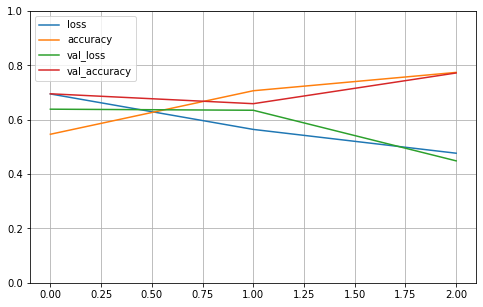

Train set ones/size 2421 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 254 / 522
Range of scores: 0.005276564 to 0.9862146
Score threshold 0.5
Prediction set ones/size 219 / 522


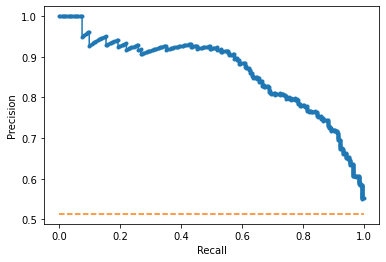

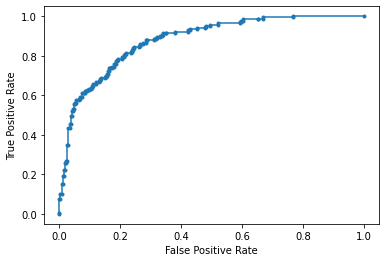

Accuracy: 77.20% Precision: 80.82% Recall: 69.69%
F1: 74.84% AUPRC: 86.50% AUROC: 87.94%
2023-02-07 15:33:33.909089
Fold 3
RCI mean derived from training set: -1.3034471971535022
RCI threshold derived from training set: -1.3034471971535022
FIT
2023-02-07 15:33:36.709203
PREDICT
2023-02-07 15:33:42.696185


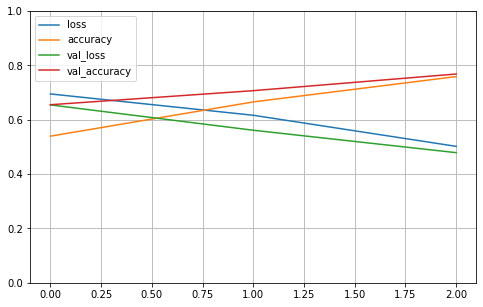

Train set ones/size 2413 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 262 / 522
Range of scores: 0.026089925 to 0.99903166
Score threshold 0.5
Prediction set ones/size 299 / 522


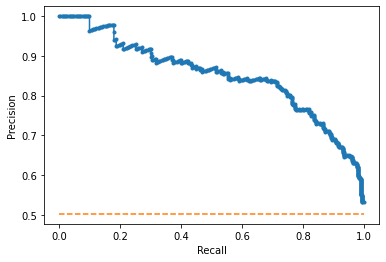

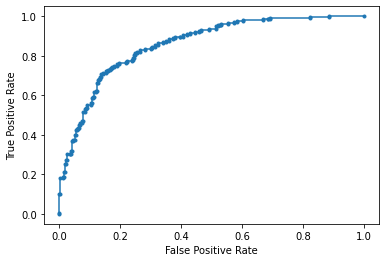

Accuracy: 76.82% Precision: 73.58% Recall: 83.97%
F1: 78.43% AUPRC: 85.13% AUROC: 85.87%
2023-02-07 15:33:43.303130
Fold 4
RCI mean derived from training set: -1.2912956771833086
RCI threshold derived from training set: -1.2912956771833086
FIT
2023-02-07 15:33:47.023087
PREDICT
2023-02-07 15:33:53.295785


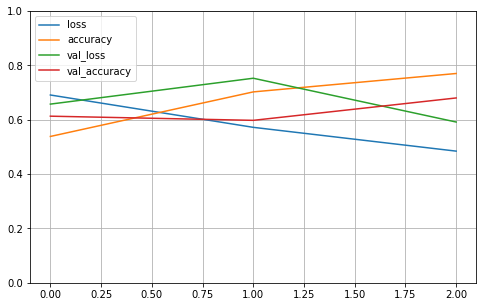

Train set ones/size 2418 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 255 / 522
Range of scores: 0.019925976 to 0.99997914
Score threshold 0.5
Prediction set ones/size 382 / 522


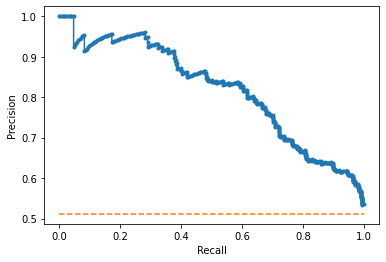

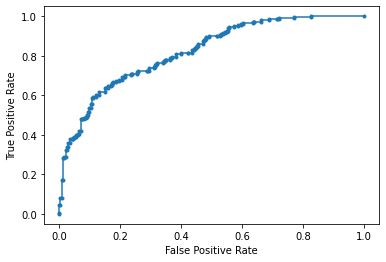

Accuracy: 68.01% Precision: 61.52% Recall: 92.16%
F1: 73.78% AUPRC: 81.87% AUROC: 82.22%
2023-02-07 15:33:53.901349
Fold 5
RCI mean derived from training set: -1.3037518440344902
RCI threshold derived from training set: -1.3037518440344902
FIT
2023-02-07 15:33:56.572299
PREDICT
2023-02-07 15:34:02.571171


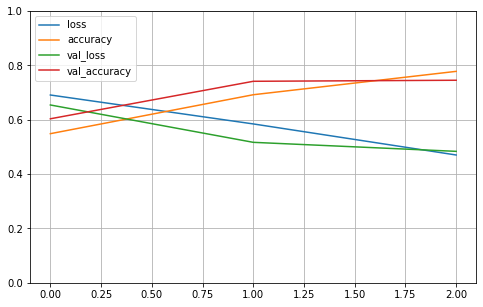

Train set ones/size 2409 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 266 / 522
Range of scores: 0.005986958 to 0.99780446
Score threshold 0.5
Prediction set ones/size 319 / 522


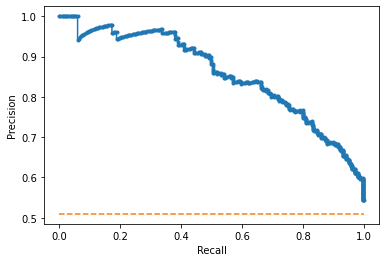

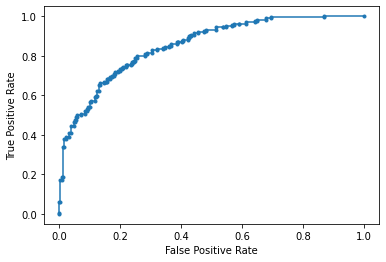

Accuracy: 74.52% Precision: 70.85% Recall: 84.96%
F1: 77.26% AUPRC: 85.86% AUROC: 85.34%
2023-02-07 15:34:03.176433
Fold 6
RCI mean derived from training set: -1.3049483705556737
RCI threshold derived from training set: -1.3049483705556737
FIT
2023-02-07 15:34:05.878365
PREDICT
2023-02-07 15:34:11.844607


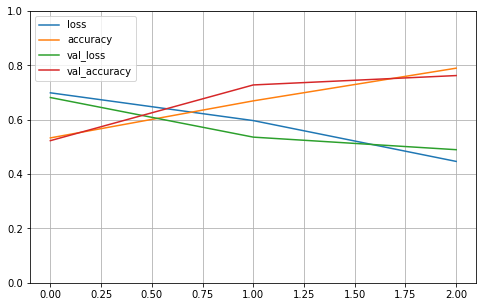

Train set ones/size 2414 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 261 / 522
Range of scores: 0.0025684617 to 0.9923414
Score threshold 0.5
Prediction set ones/size 191 / 522


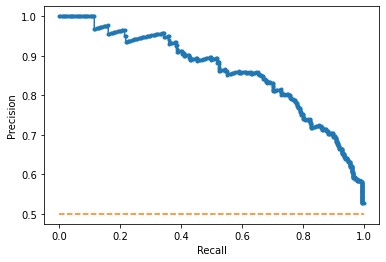

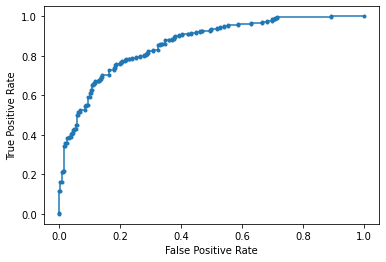

Accuracy: 76.25% Precision: 85.86% Recall: 62.84%
F1: 72.57% AUPRC: 86.14% AUROC: 86.06%
2023-02-07 15:34:12.749758
Fold 7
RCI mean derived from training set: -1.3032546083947198
RCI threshold derived from training set: -1.3032546083947198
FIT
2023-02-07 15:34:15.572695
PREDICT
2023-02-07 15:34:21.554221


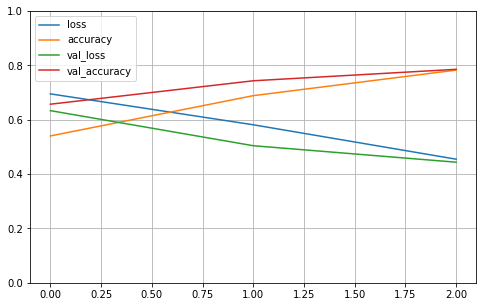

Train set ones/size 2406 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 269 / 522
Range of scores: 0.0046050847 to 0.99461585
Score threshold 0.5
Prediction set ones/size 285 / 522


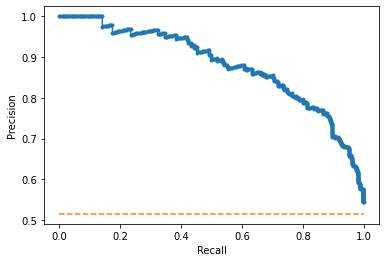

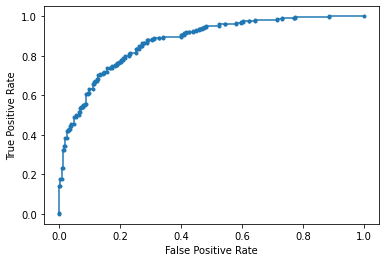

Accuracy: 78.54% Precision: 77.54% Recall: 82.16%
F1: 79.78% AUPRC: 88.09% AUROC: 87.40%
2023-02-07 15:34:22.160415
Fold 8
RCI mean derived from training set: -1.3093740925122417
RCI threshold derived from training set: -1.3093740925122417
FIT
2023-02-07 15:34:25.384812
PREDICT
2023-02-07 15:34:31.682220


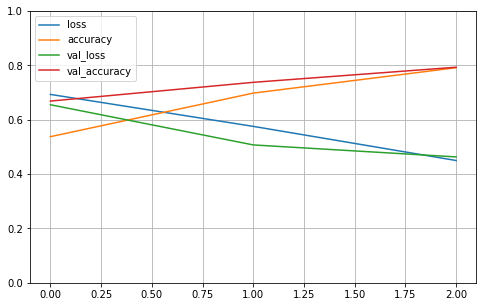

Train set ones/size 2406 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 269 / 522
Range of scores: 0.0036598444 to 0.997528
Score threshold 0.5
Prediction set ones/size 257 / 522


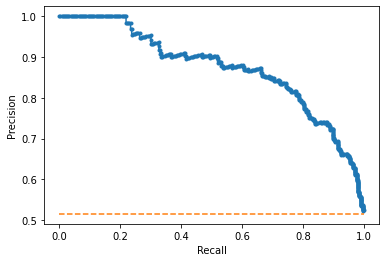

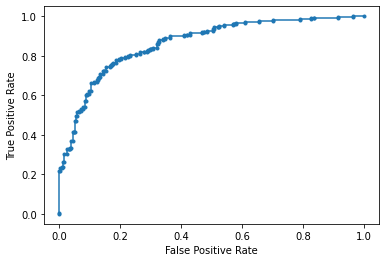

Accuracy: 79.31% Precision: 81.32% Recall: 77.70%
F1: 79.47% AUPRC: 87.33% AUROC: 86.41%
2023-02-07 15:34:32.304061
Fold 9
RCI mean derived from training set: -1.3158440667511175
RCI threshold derived from training set: -1.3158440667511175
FIT
2023-02-07 15:34:34.949285
PREDICT
2023-02-07 15:34:40.955235


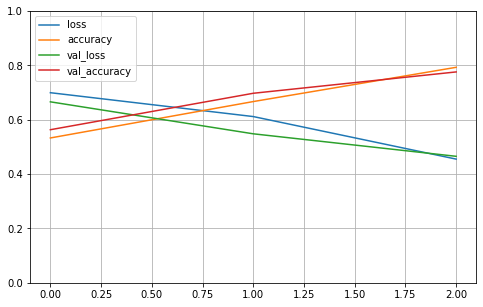

Train set ones/size 2387 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 289 / 522
Range of scores: 0.0027933419 to 0.9961163
Score threshold 0.5
Prediction set ones/size 312 / 522


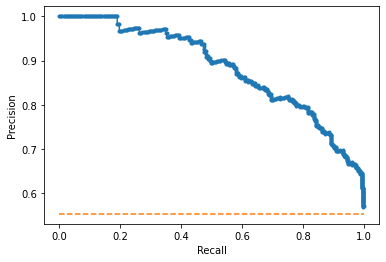

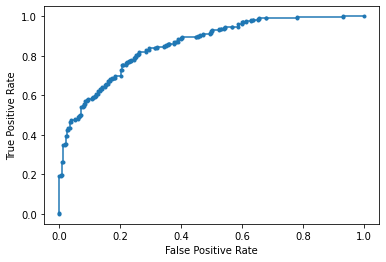

Accuracy: 77.59% Precision: 77.56% Recall: 83.74%
F1: 80.53% AUPRC: 88.36% AUROC: 85.57%
2023-02-07 15:34:41.566262
Fold 10
RCI mean derived from training set: -1.312804497835249
RCI threshold derived from training set: -1.312804497835249
FIT
2023-02-07 15:34:44.259104
PREDICT
2023-02-07 15:34:50.255107


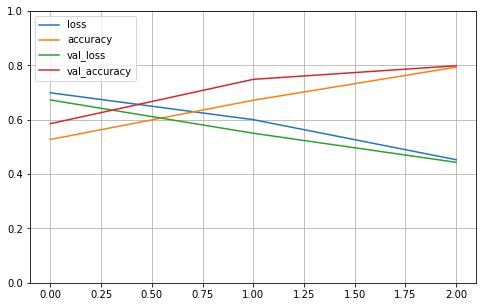

Train set ones/size 2392 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 283 / 521
Range of scores: 0.009652355 to 0.9964528
Score threshold 0.5
Prediction set ones/size 280 / 521


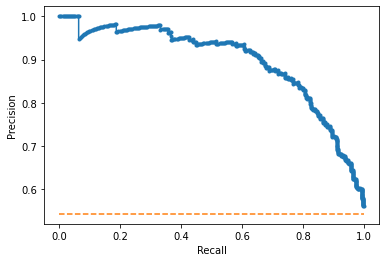

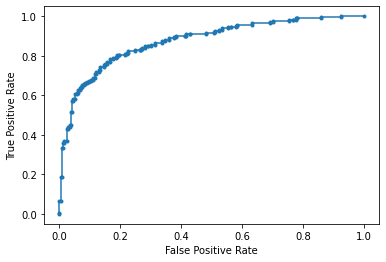

Accuracy: 79.85% Precision: 81.79% Recall: 80.92%
F1: 81.35% AUPRC: 89.66% AUROC: 87.52%
2023-02-07 15:34:50.868732

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.68% +/- 3.43
 precision mean 76.95% +/- 6.89
 recall mean 79.83% +/- 8.26
 F1 mean 77.74% +/- 3.02
 AUPRC mean 86.60% +/- 2.13
 AUROC mean 86.15% +/- 1.64
Finished cell Line 7 NCI.H460

2023-02-07 15:34:52.299940
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-07 15:35:04.622315
splitting
Fold 1
RCI mean derived from training set: -0.653079659387811
RCI threshold derived from training set: -0.653079659387811
FIT
2023-02-07 15:35:08.048814
PREDICT
2023-02-07 15:35:19.321947


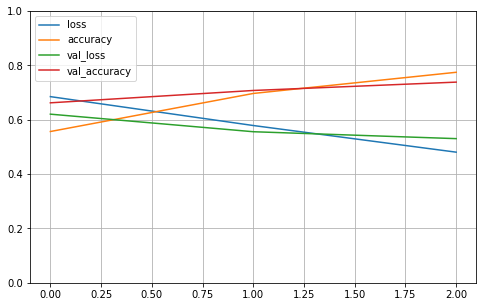

Train set ones/size 3732 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 432 / 814
Range of scores: 0.00083174574 to 0.99729294
Score threshold 0.5
Prediction set ones/size 545 / 814


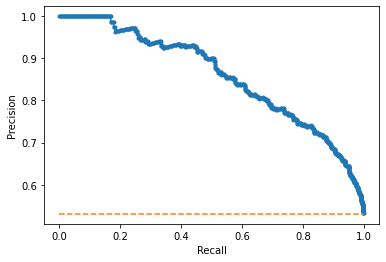

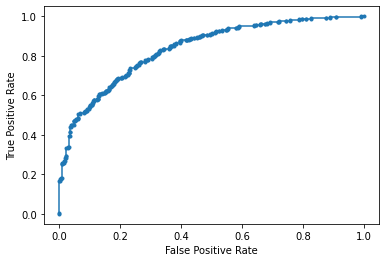

Accuracy: 73.83% Precision: 70.09% Recall: 88.43%
F1: 78.20% AUPRC: 85.89% AUROC: 83.60%
2023-02-07 15:35:19.999055
Fold 2
RCI mean derived from training set: -0.6412958734216999
RCI threshold derived from training set: -0.6412958734216999
FIT
2023-02-07 15:35:23.451444
PREDICT
2023-02-07 15:35:31.429453


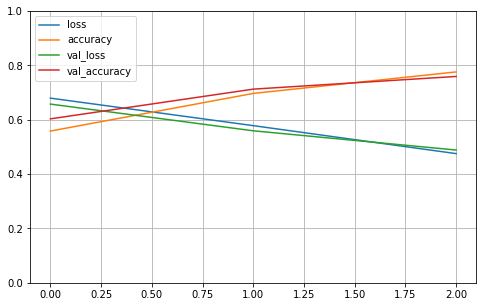

Train set ones/size 3723 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 417 / 814
Range of scores: 0.0026540905 to 0.99793833
Score threshold 0.5
Prediction set ones/size 435 / 814


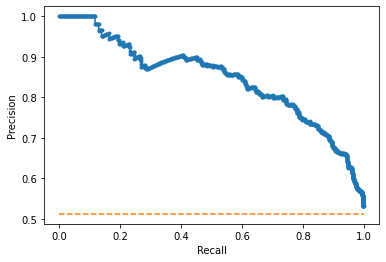

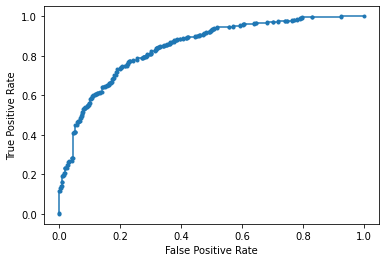

Accuracy: 75.92% Precision: 75.40% Recall: 78.66%
F1: 77.00% AUPRC: 84.56% AUROC: 84.40%
2023-02-07 15:35:32.286285
Fold 3
RCI mean derived from training set: -0.6430724309195246
RCI threshold derived from training set: -0.6430724309195246
FIT
2023-02-07 15:35:35.887684
PREDICT
2023-02-07 15:35:43.874007


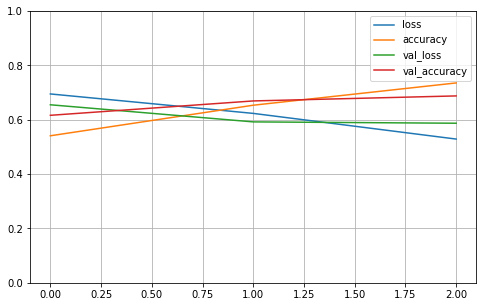

Train set ones/size 3731 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 409 / 813
Range of scores: 0.0030044713 to 0.98399806
Score threshold 0.5
Prediction set ones/size 231 / 813


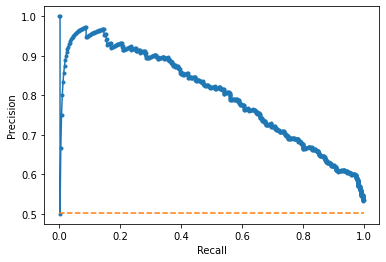

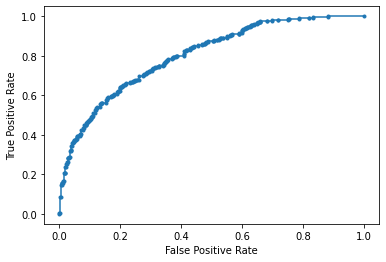

Accuracy: 68.76% Precision: 83.55% Recall: 47.19%
F1: 60.31% AUPRC: 80.08% AUROC: 80.28%
2023-02-07 15:35:44.707192
Fold 4
RCI mean derived from training set: -0.6520008468916518
RCI threshold derived from training set: -0.6520008468916518
FIT
2023-02-07 15:35:48.339964
PREDICT
2023-02-07 15:35:56.118265


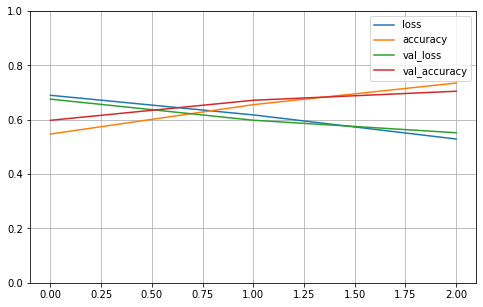

Train set ones/size 3748 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 415 / 813
Range of scores: 0.0059557986 to 0.9491768
Score threshold 0.5
Prediction set ones/size 261 / 813


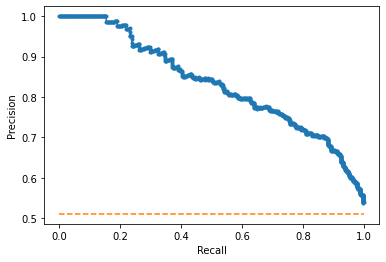

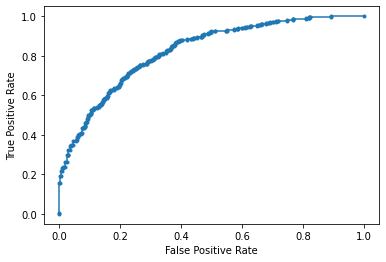

Accuracy: 70.48% Precision: 83.52% Recall: 52.53%
F1: 64.50% AUPRC: 83.33% AUROC: 82.49%
2023-02-07 15:35:56.968026
Fold 5
RCI mean derived from training set: -0.6458179012979914
RCI threshold derived from training set: -0.6458179012979914
FIT
2023-02-07 15:36:00.796662
PREDICT
2023-02-07 15:36:08.576871


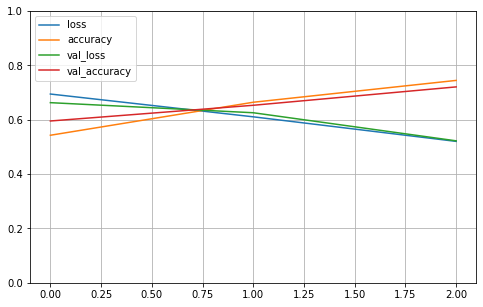

Train set ones/size 3752 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 406 / 813
Range of scores: 0.008850571 to 0.96886003
Score threshold 0.5
Prediction set ones/size 361 / 813


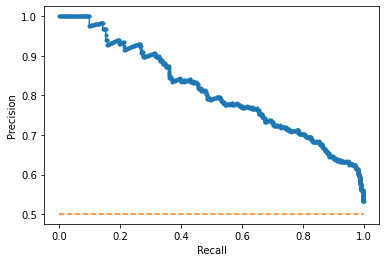

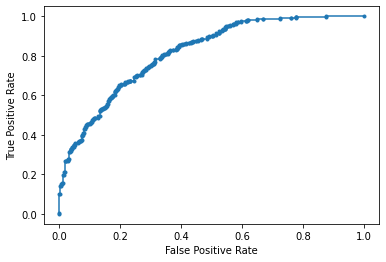

Accuracy: 72.08% Precision: 74.79% Recall: 66.50%
F1: 70.40% AUPRC: 81.18% AUROC: 81.64%
2023-02-07 15:36:09.354504
Fold 6
RCI mean derived from training set: -0.6456534287470966
RCI threshold derived from training set: -0.6456534287470966
FIT
2023-02-07 15:36:13.468619
PREDICT
2023-02-07 15:36:21.212537


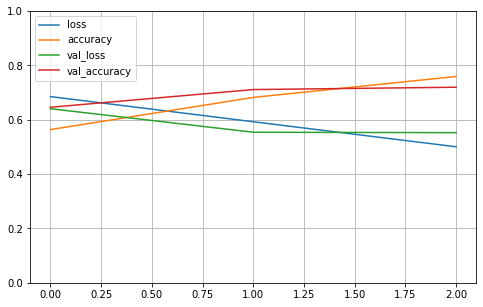

Train set ones/size 3736 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 422 / 813
Range of scores: 0.013776065 to 0.9936085
Score threshold 0.5
Prediction set ones/size 552 / 813


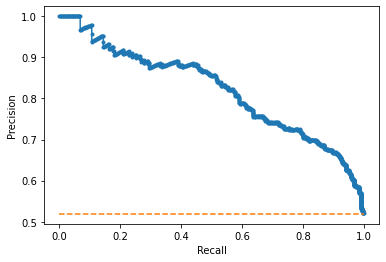

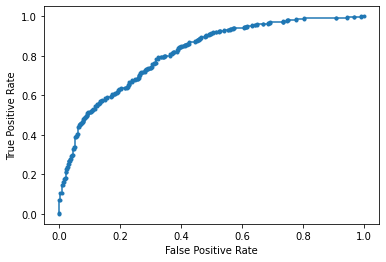

Accuracy: 71.96% Precision: 67.57% Recall: 88.39%
F1: 76.59% AUPRC: 82.05% AUROC: 81.26%
2023-02-07 15:36:21.835923
Fold 7
RCI mean derived from training set: -0.662971660841645
RCI threshold derived from training set: -0.662971660841645
FIT
2023-02-07 15:36:26.090973
PREDICT
2023-02-07 15:36:33.859209


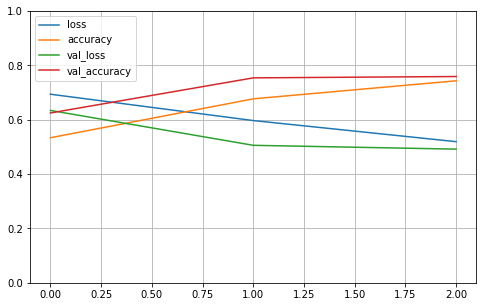

Train set ones/size 3729 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 439 / 813
Range of scores: 0.008318528 to 0.98828286
Score threshold 0.5
Prediction set ones/size 549 / 813


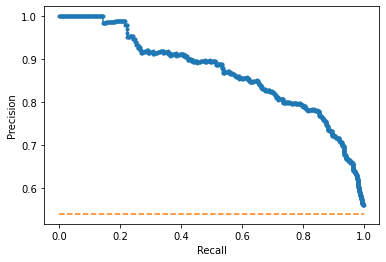

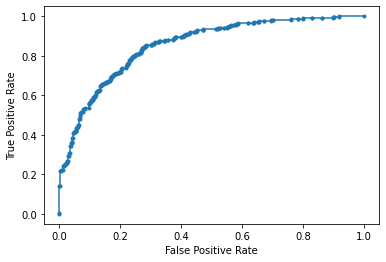

Accuracy: 75.89% Precision: 72.13% Recall: 90.21%
F1: 80.16% AUPRC: 86.96% AUROC: 85.35%
2023-02-07 15:36:34.560044
Fold 8
RCI mean derived from training set: -0.6438629646946304
RCI threshold derived from training set: -0.6438629646946304
FIT
2023-02-07 15:36:38.864856
PREDICT
2023-02-07 15:36:50.145173


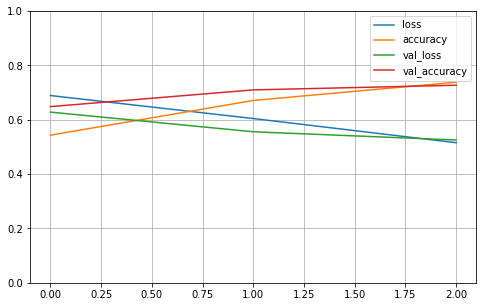

Train set ones/size 3737 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 405 / 813
Range of scores: 0.0025798646 to 0.9746919
Score threshold 0.5
Prediction set ones/size 363 / 813


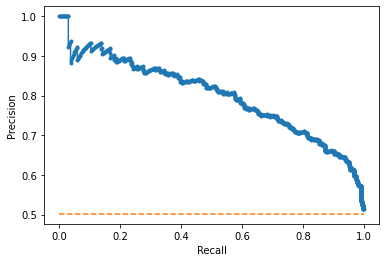

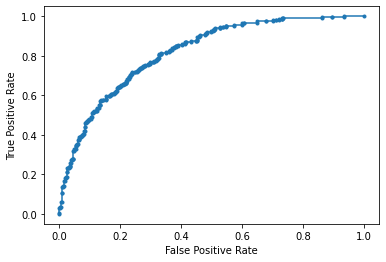

Accuracy: 72.69% Precision: 75.21% Recall: 67.41%
F1: 71.09% AUPRC: 80.06% AUROC: 81.88%
2023-02-07 15:36:50.816222
Fold 9
RCI mean derived from training set: -0.6443524139226671
RCI threshold derived from training set: -0.6443524139226671
FIT
2023-02-07 15:36:54.318030
PREDICT
2023-02-07 15:37:05.592031


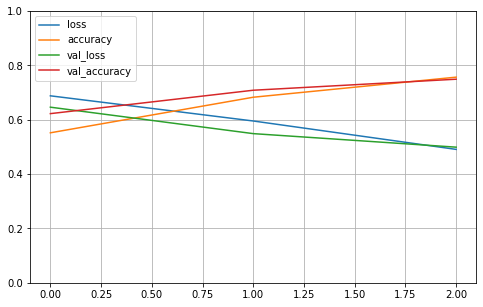

Train set ones/size 3731 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 411 / 813
Range of scores: 0.0022259736 to 0.9950433
Score threshold 0.5
Prediction set ones/size 437 / 813


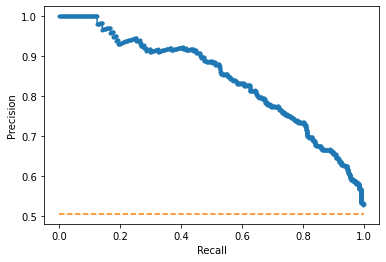

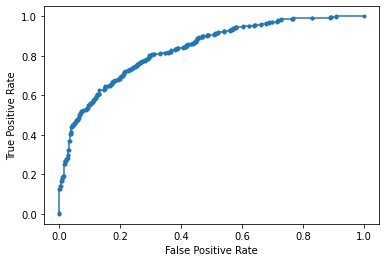

Accuracy: 74.91% Precision: 73.68% Recall: 78.35%
F1: 75.94% AUPRC: 84.29% AUROC: 83.40%
2023-02-07 15:37:06.257770
Fold 10
RCI mean derived from training set: -0.6487705280639432
RCI threshold derived from training set: -0.6487705280639432
FIT
2023-02-07 15:37:09.695303
PREDICT
2023-02-07 15:37:17.892908


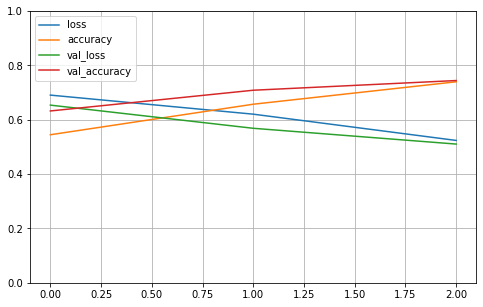

Train set ones/size 3759 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 399 / 813
Range of scores: 0.011009089 to 0.98170966
Score threshold 0.5
Prediction set ones/size 339 / 813


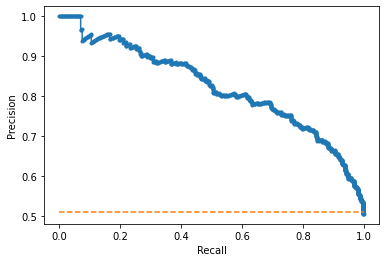

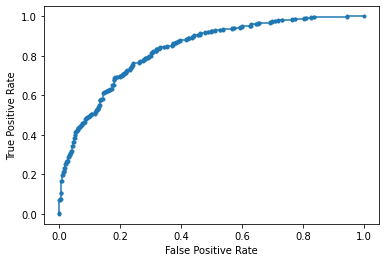

Accuracy: 74.42% Precision: 78.17% Recall: 66.42%
F1: 71.82% AUPRC: 82.28% AUROC: 83.28%
2023-02-07 15:37:18.566629

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.09% +/- 2.35
 precision mean 75.41% +/- 5.20
 recall mean 72.41% +/- 15.02
 F1 mean 72.60% +/- 6.32
 AUPRC mean 83.07% +/- 2.36
 AUROC mean 82.76% +/- 1.54
Finished cell Line 8 NHEK

2023-02-07 15:37:19.954377
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-07 15:37:28.210120
splitting
Fold 1
RCI mean derived from training set: -1.6097299827669693
RCI threshold derived from training set: -1.6097299827669693
FIT
2023-02-07 15:37:30.238815
PREDICT
2023-02-07 15:37:35.606754


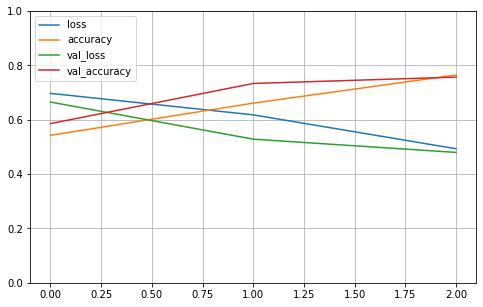

Train set ones/size 2434 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 260 / 514
Range of scores: 0.0011143204 to 0.99478745
Score threshold 0.5
Prediction set ones/size 247 / 514


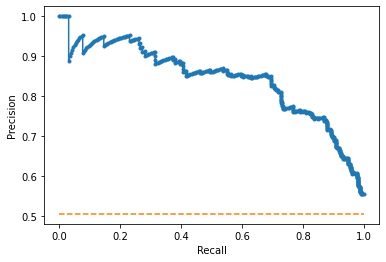

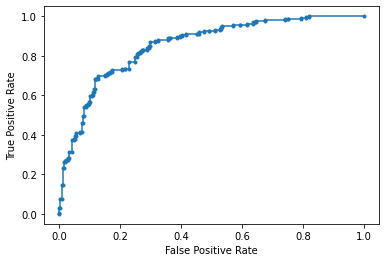

Accuracy: 75.68% Precision: 77.33% Recall: 73.46%
F1: 75.35% AUPRC: 84.33% AUROC: 85.32%
2023-02-07 15:37:36.249077
Fold 2
RCI mean derived from training set: -1.6072797641763945
RCI threshold derived from training set: -1.6072797641763945
FIT
2023-02-07 15:37:38.901755
PREDICT
2023-02-07 15:37:45.022717


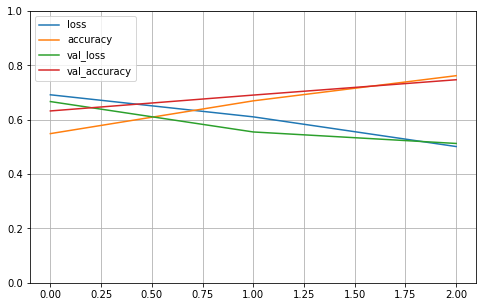

Train set ones/size 2414 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 279 / 514
Range of scores: 0.003312802 to 0.9910019
Score threshold 0.5
Prediction set ones/size 319 / 514


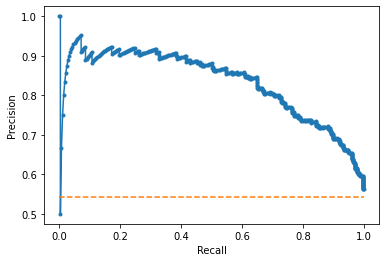

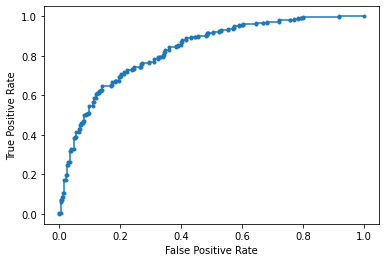

Accuracy: 74.71% Precision: 73.35% Recall: 83.87%
F1: 78.26% AUPRC: 83.24% AUROC: 82.90%
2023-02-07 15:37:45.622373
Fold 3
RCI mean derived from training set: -1.6086752521141374
RCI threshold derived from training set: -1.6086752521141374
FIT
2023-02-07 15:37:48.272768
PREDICT
2023-02-07 15:37:53.690232


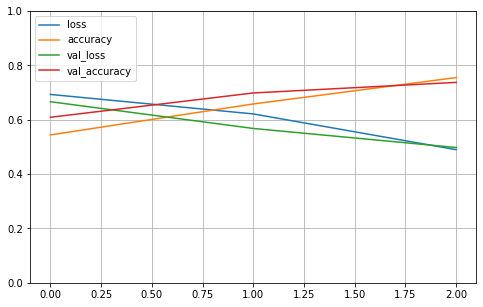

Train set ones/size 2427 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 266 / 514
Range of scores: 0.004143299 to 0.9914752
Score threshold 0.5
Prediction set ones/size 259 / 514


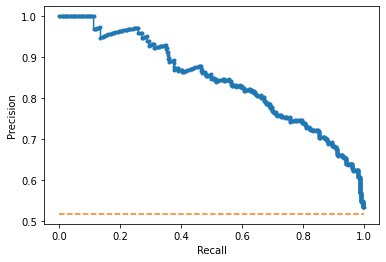

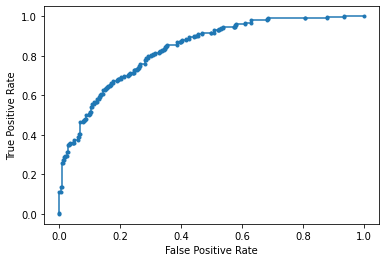

Accuracy: 73.74% Precision: 75.29% Recall: 73.31%
F1: 74.29% AUPRC: 84.44% AUROC: 83.58%
2023-02-07 15:37:54.461534
Fold 4
RCI mean derived from training set: -1.6067064599610894
RCI threshold derived from training set: -1.6067064599610894
FIT
2023-02-07 15:37:57.222870
PREDICT
2023-02-07 15:38:02.421493


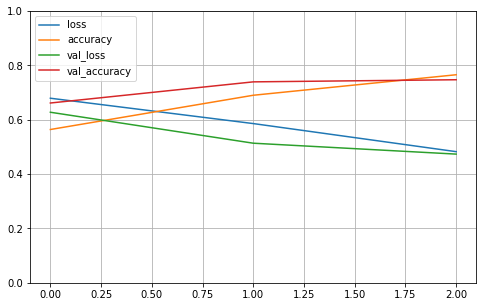

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 265 / 514
Range of scores: 0.002474156 to 0.9858225
Score threshold 0.5
Prediction set ones/size 253 / 514


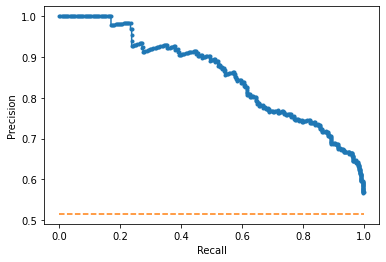

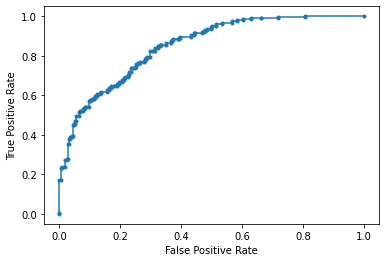

Accuracy: 74.71% Precision: 76.68% Recall: 73.21%
F1: 74.90% AUPRC: 85.71% AUROC: 84.98%
2023-02-07 15:38:03.024112
Fold 5
RCI mean derived from training set: -1.6148654526329445
RCI threshold derived from training set: -1.6148654526329445
FIT
2023-02-07 15:38:05.686252
PREDICT
2023-02-07 15:38:11.947640


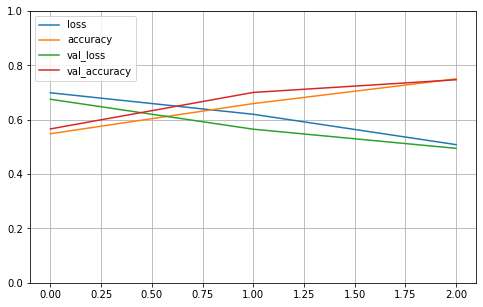

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 275 / 514
Range of scores: 0.008552579 to 0.9957638
Score threshold 0.5
Prediction set ones/size 295 / 514


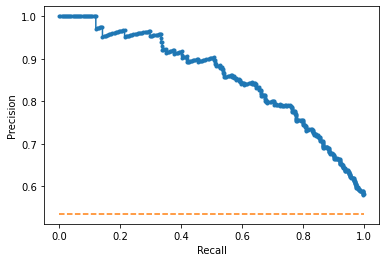

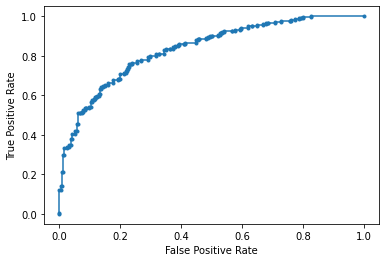

Accuracy: 74.71% Precision: 74.58% Recall: 80.00%
F1: 77.19% AUPRC: 85.76% AUROC: 83.46%
2023-02-07 15:38:12.579970
Fold 6
RCI mean derived from training set: -1.6097505674102894
RCI threshold derived from training set: -1.6097505674102894
FIT
2023-02-07 15:38:15.238900
PREDICT
2023-02-07 15:38:20.685940


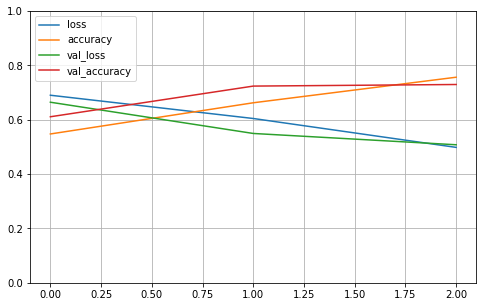

Train set ones/size 2424 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 270 / 514
Range of scores: 0.0064293267 to 0.9965365
Score threshold 0.5
Prediction set ones/size 303 / 514


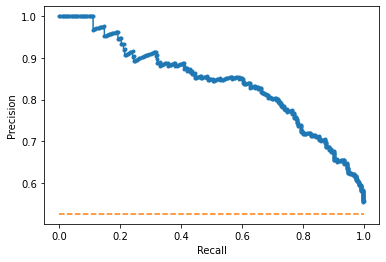

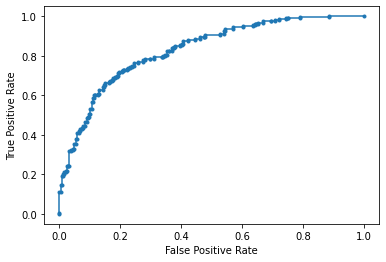

Accuracy: 72.96% Precision: 71.62% Recall: 80.37%
F1: 75.74% AUPRC: 84.08% AUROC: 83.06%
2023-02-07 15:38:21.584891
Fold 7
RCI mean derived from training set: -1.625522115170774
RCI threshold derived from training set: -1.625522115170774
FIT
2023-02-07 15:38:24.364638
PREDICT
2023-02-07 15:38:30.352750


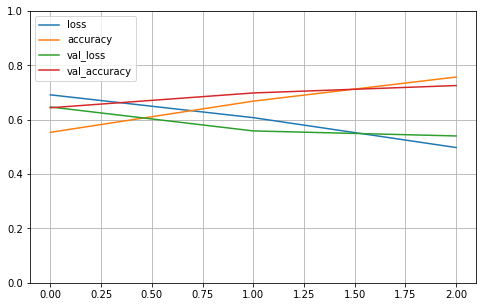

Train set ones/size 2421 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 282 / 514
Range of scores: 0.0020265132 to 0.98871607
Score threshold 0.5
Prediction set ones/size 251 / 514


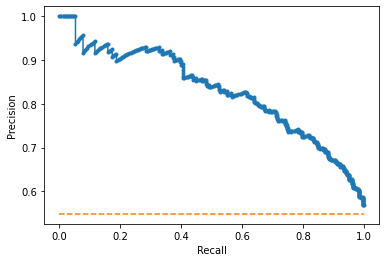

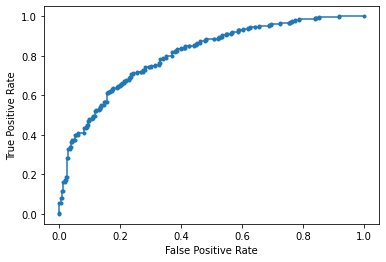

Accuracy: 72.57% Precision: 78.09% Recall: 69.50%
F1: 73.55% AUPRC: 83.04% AUROC: 80.69%
2023-02-07 15:38:30.964265
Fold 8
RCI mean derived from training set: -1.6139277325940338
RCI threshold derived from training set: -1.6139277325940338
FIT
2023-02-07 15:38:34.539957
PREDICT
2023-02-07 15:38:40.881372


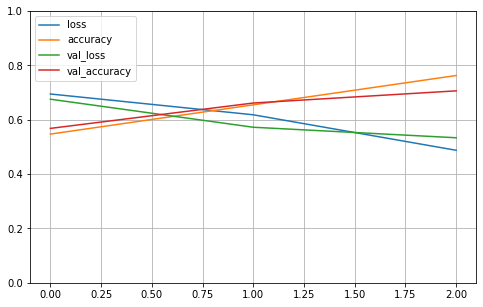

Train set ones/size 2442 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 261 / 514
Range of scores: 0.0035676246 to 0.9907342
Score threshold 0.5
Prediction set ones/size 240 / 514


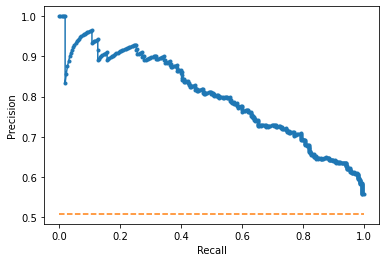

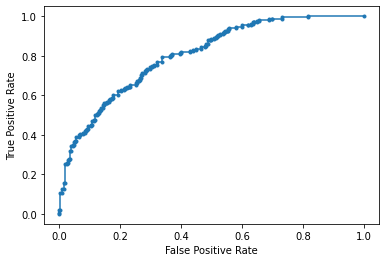

Accuracy: 70.62% Precision: 72.92% Recall: 67.05%
F1: 69.86% AUPRC: 79.99% AUROC: 80.42%
2023-02-07 15:38:41.527584
Fold 9
RCI mean derived from training set: -1.6240643330393427
RCI threshold derived from training set: -1.6240643330393427
FIT
2023-02-07 15:38:44.189745
PREDICT
2023-02-07 15:38:50.184085


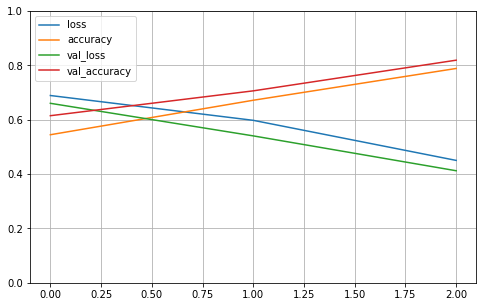

Train set ones/size 2415 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 288 / 514
Range of scores: 0.0003936816 to 0.9970294
Score threshold 0.5
Prediction set ones/size 277 / 514


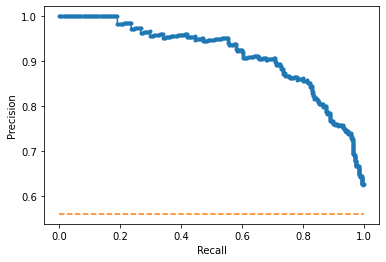

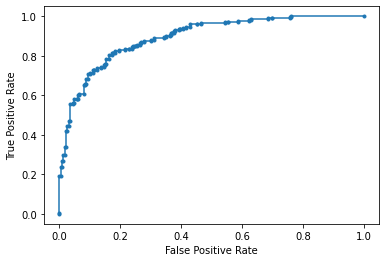

Accuracy: 81.91% Precision: 85.20% Recall: 81.94%
F1: 83.54% AUPRC: 91.39% AUROC: 89.42%
2023-02-07 15:38:50.802558
Fold 10
RCI mean derived from training set: -1.5917950430134025
RCI threshold derived from training set: -1.5917950430134025
FIT
2023-02-07 15:38:53.441671
PREDICT
2023-02-07 15:38:59.421334


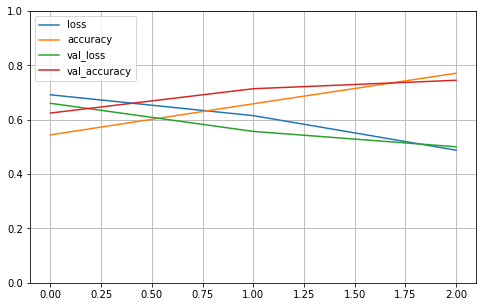

Train set ones/size 2403 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 250 / 514
Range of scores: 0.0044237887 to 0.99403024
Score threshold 0.5
Prediction set ones/size 295 / 514


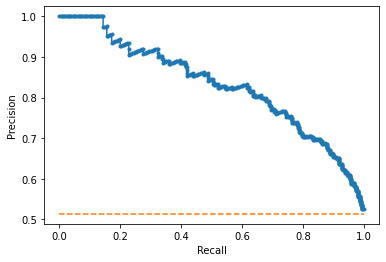

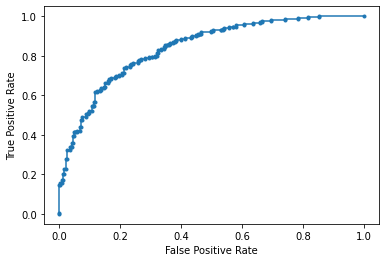

Accuracy: 74.51% Precision: 70.17% Recall: 82.80%
F1: 75.96% AUPRC: 83.23% AUROC: 84.05%
2023-02-07 15:39:00.312197

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.61% +/- 2.94
 precision mean 75.52% +/- 4.23
 recall mean 76.55% +/- 5.96
 F1 mean 75.86% +/- 3.52
 AUPRC mean 84.52% +/- 2.91
 AUROC mean 83.79% +/- 2.54
Finished cell Line 9 SK.MEL.5

2023-02-07 15:39:01.754622
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-07 15:39:09.850949
splitting
Fold 1
RCI mean derived from training set: -0.6281296777050442
RCI threshold derived from training set: -0.6281296777050442
FIT
2023-02-07 15:39:11.432488
PREDICT
2023-02-07 15:39:17.922188


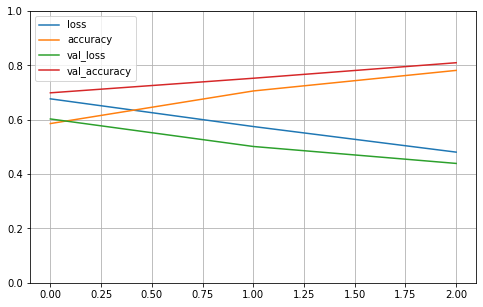

Train set ones/size 2971 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 334 / 578
Range of scores: 0.033602696 to 0.997042
Score threshold 0.5
Prediction set ones/size 390 / 578


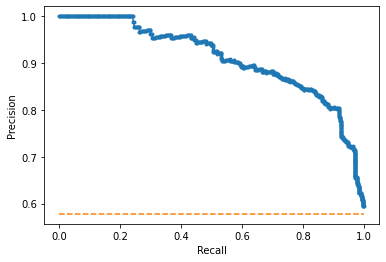

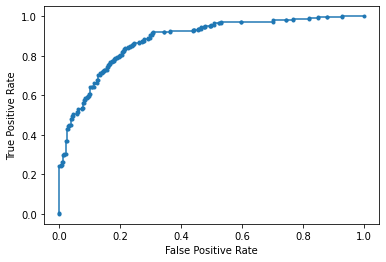

Accuracy: 80.97% Precision: 78.72% Recall: 91.92%
F1: 84.81% AUPRC: 90.99% AUROC: 88.16%
2023-02-07 15:39:18.604199
Fold 2
RCI mean derived from training set: -0.6153963924797844
RCI threshold derived from training set: -0.6153963924797844
FIT
2023-02-07 15:39:21.451312
PREDICT
2023-02-07 15:39:27.630691


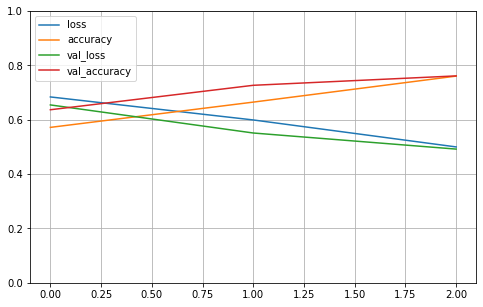

Train set ones/size 2979 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 324 / 578
Range of scores: 0.005710438 to 0.9964257
Score threshold 0.5
Prediction set ones/size 348 / 578


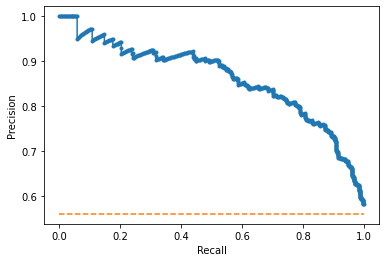

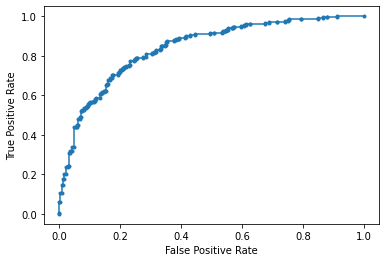

Accuracy: 76.12% Precision: 76.72% Recall: 82.41%
F1: 79.46% AUPRC: 86.24% AUROC: 84.04%
2023-02-07 15:39:28.431098
Fold 3
RCI mean derived from training set: -0.6143647613782484
RCI threshold derived from training set: -0.6143647613782484
FIT
2023-02-07 15:39:31.267319
PREDICT
2023-02-07 15:39:37.322166


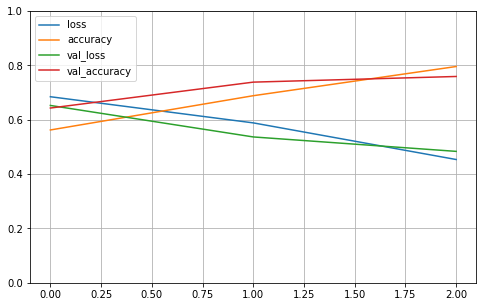

Train set ones/size 2976 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 326 / 577
Range of scores: 0.00350401 to 0.9990307
Score threshold 0.5
Prediction set ones/size 413 / 577


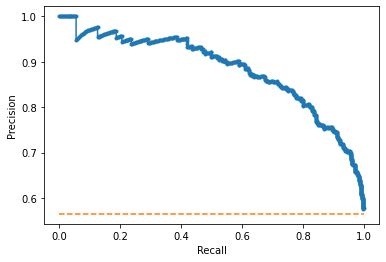

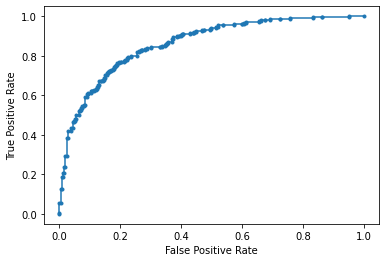

Accuracy: 75.91% Precision: 72.64% Recall: 92.02%
F1: 81.19% AUPRC: 88.47% AUROC: 86.19%
2023-02-07 15:39:37.952832
Fold 4
RCI mean derived from training set: -0.6185031523464869
RCI threshold derived from training set: -0.6185031523464869
FIT
2023-02-07 15:39:41.598413
PREDICT
2023-02-07 15:39:47.616830


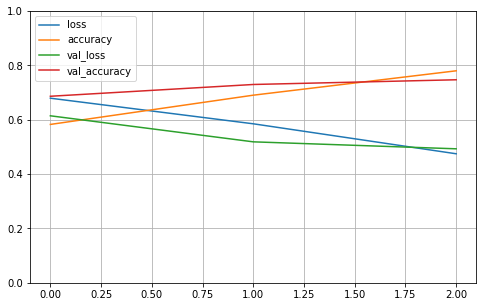

Train set ones/size 2970 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 334 / 577
Range of scores: 0.0036698177 to 0.9984831
Score threshold 0.5
Prediction set ones/size 420 / 577


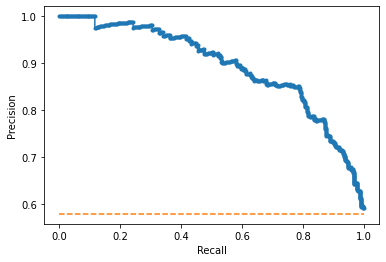

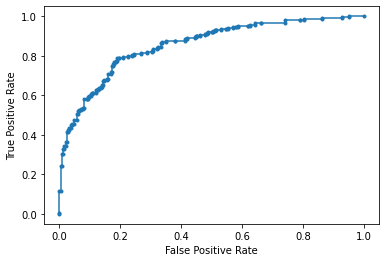

Accuracy: 74.70% Precision: 72.38% Recall: 91.02%
F1: 80.64% AUPRC: 89.43% AUROC: 85.55%
2023-02-07 15:39:48.271662
Fold 5
RCI mean derived from training set: -0.6135521460789221
RCI threshold derived from training set: -0.6135521460789221
FIT
2023-02-07 15:39:51.261402
PREDICT
2023-02-07 15:39:57.701256


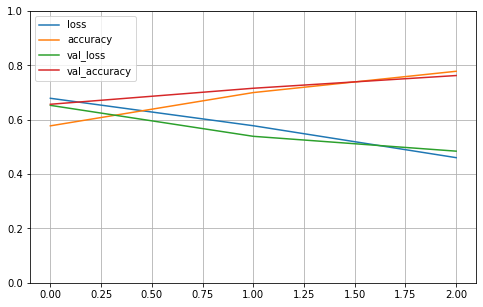

Train set ones/size 2978 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 314 / 577
Range of scores: 0.00379766 to 0.9996182
Score threshold 0.5
Prediction set ones/size 377 / 577


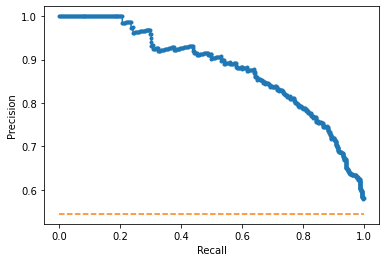

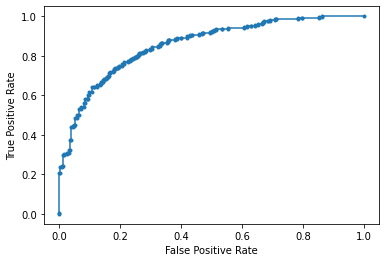

Accuracy: 76.26% Precision: 73.47% Recall: 88.22%
F1: 80.17% AUPRC: 88.02% AUROC: 85.67%
2023-02-07 15:39:58.330715
Fold 6
RCI mean derived from training set: -0.6120151131145332
RCI threshold derived from training set: -0.6120151131145332
FIT
2023-02-07 15:40:01.114898
PREDICT
2023-02-07 15:40:12.243863


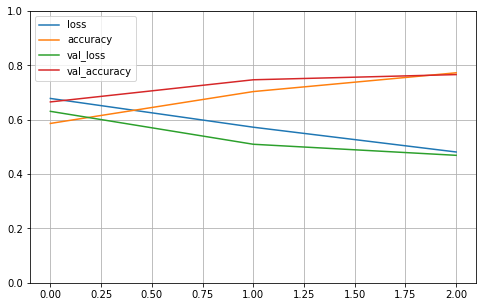

Train set ones/size 2974 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 318 / 577
Range of scores: 0.035162088 to 0.9978561
Score threshold 0.5
Prediction set ones/size 377 / 577


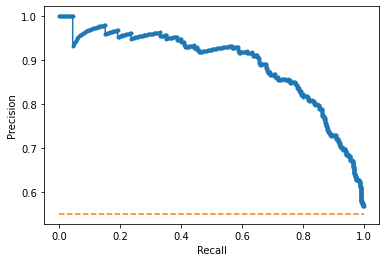

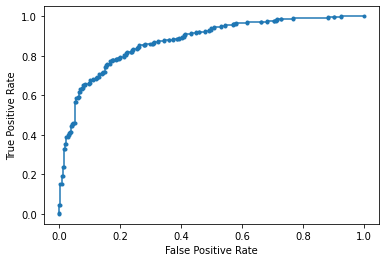

Accuracy: 76.60% Precision: 74.27% Recall: 88.05%
F1: 80.58% AUPRC: 89.18% AUROC: 87.35%
2023-02-07 15:40:12.919788
Fold 7
RCI mean derived from training set: -0.6226585323926853
RCI threshold derived from training set: -0.6226585323926853
FIT
2023-02-07 15:40:15.762386
PREDICT
2023-02-07 15:40:22.020800


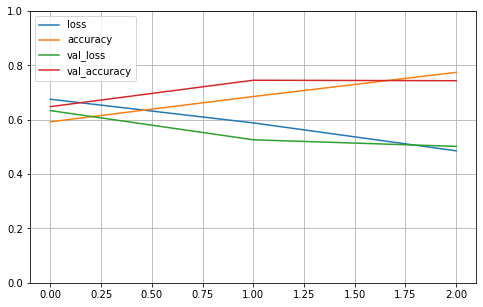

Train set ones/size 2978 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 327 / 577
Range of scores: 0.0029249792 to 0.9988826
Score threshold 0.5
Prediction set ones/size 441 / 577


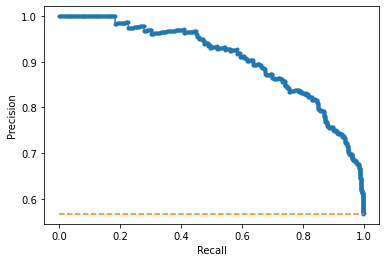

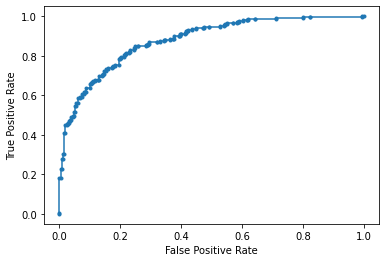

Accuracy: 74.35% Precision: 70.29% Recall: 94.80%
F1: 80.73% AUPRC: 90.64% AUROC: 87.89%
2023-02-07 15:40:22.646868
Fold 8
RCI mean derived from training set: -0.6264152809682387
RCI threshold derived from training set: -0.6264152809682387
FIT
2023-02-07 15:40:25.464747
PREDICT
2023-02-07 15:40:31.417243


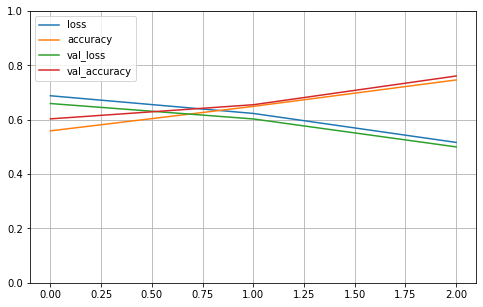

Train set ones/size 2957 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 348 / 577
Range of scores: 0.03133368 to 0.9934651
Score threshold 0.5
Prediction set ones/size 412 / 577


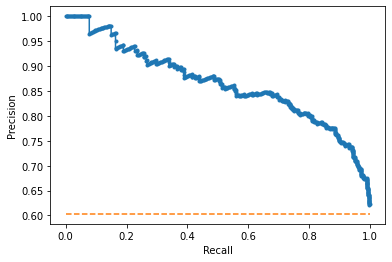

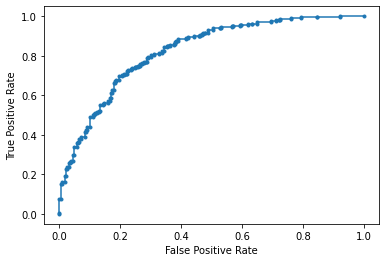

Accuracy: 76.08% Precision: 75.49% Recall: 89.37%
F1: 81.84% AUPRC: 86.55% AUROC: 82.50%
2023-02-07 15:40:32.356610
Fold 9
RCI mean derived from training set: -0.6273904246448507
RCI threshold derived from training set: -0.6273904246448507
FIT
2023-02-07 15:40:35.301947
PREDICT
2023-02-07 15:40:41.091286


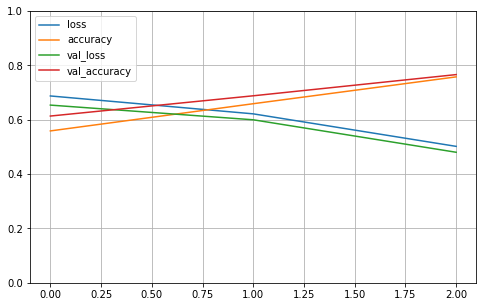

Train set ones/size 2965 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 340 / 577
Range of scores: 0.0003897025 to 0.9970475
Score threshold 0.5
Prediction set ones/size 411 / 577


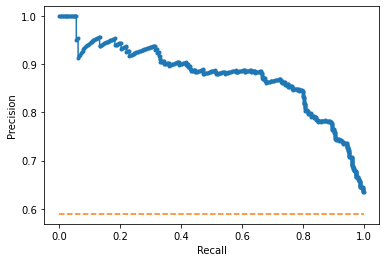

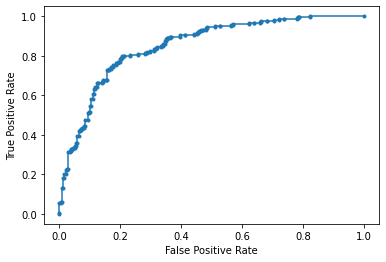

Accuracy: 76.60% Precision: 74.94% Recall: 90.59%
F1: 82.02% AUPRC: 87.66% AUROC: 85.18%
2023-02-07 15:40:41.705631
Fold 10
RCI mean derived from training set: -0.6130283155322426
RCI threshold derived from training set: -0.6130283155322426
FIT
2023-02-07 15:40:45.237962
PREDICT
2023-02-07 15:40:51.635887


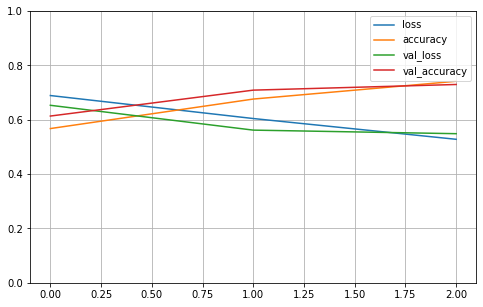

Train set ones/size 2958 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 334 / 577
Range of scores: 0.068386704 to 0.99681693
Score threshold 0.5
Prediction set ones/size 446 / 577


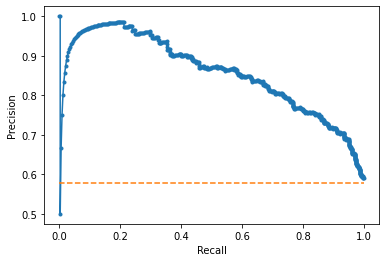

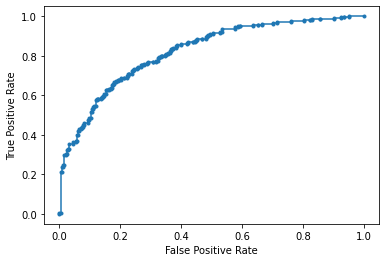

Accuracy: 72.96% Precision: 69.96% Recall: 93.41%
F1: 80.00% AUPRC: 85.69% AUROC: 82.20%
2023-02-07 15:40:52.310864

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.06% +/- 2.08
 precision mean 73.89% +/- 2.74
 recall mean 90.18% +/- 3.47
 F1 mean 81.14% +/- 1.51
 AUPRC mean 88.29% +/- 1.81
 AUROC mean 85.47% +/- 2.08
Finished cell Line 10 SK.N.DZ

2023-02-07 15:40:53.651187
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-07 15:41:09.736741
splitting
Fold 1
RCI mean derived from training set: -0.9625358854186823
RCI threshold derived from training set: -0.9625358854186823
FIT
2023-02-07 15:41:13.547713
PREDICT
2023-02-07 15:41:25.093104


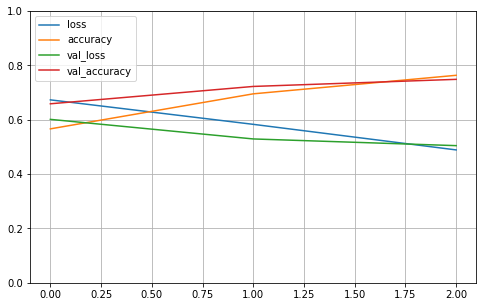

Train set ones/size 4791 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 542 / 1034
Range of scores: 0.003080204 to 0.99631244
Score threshold 0.5
Prediction set ones/size 474 / 1034


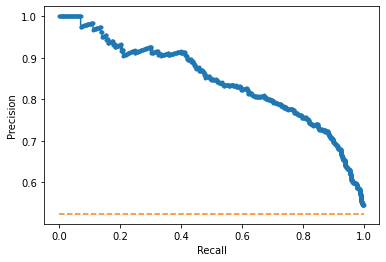

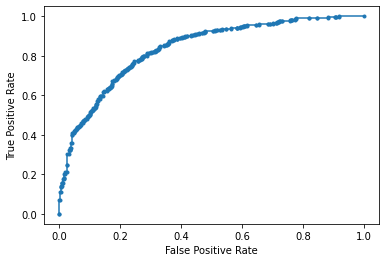

Accuracy: 74.85% Precision: 79.75% Recall: 69.74%
F1: 74.41% AUPRC: 84.40% AUROC: 83.63%
2023-02-07 15:41:26.135899
Fold 2
RCI mean derived from training set: -0.9590621364119102
RCI threshold derived from training set: -0.9590621364119102
FIT
2023-02-07 15:41:30.347548
PREDICT
2023-02-07 15:41:41.750182


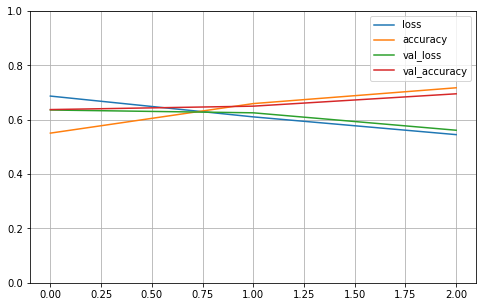

Train set ones/size 4809 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 524 / 1034
Range of scores: 0.01056829 to 0.9954781
Score threshold 0.5
Prediction set ones/size 751 / 1034


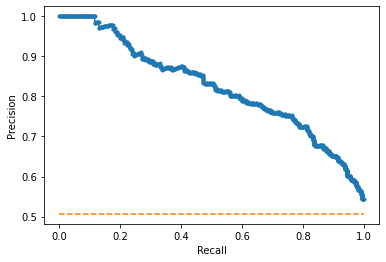

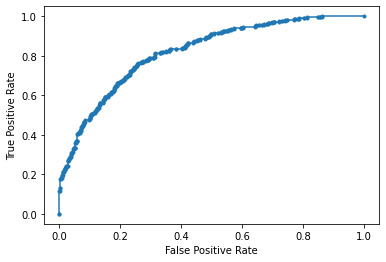

Accuracy: 69.54% Precision: 63.91% Recall: 91.60%
F1: 75.29% AUPRC: 82.43% AUROC: 82.05%
2023-02-07 15:41:42.447634
Fold 3
RCI mean derived from training set: -0.9621559835676664
RCI threshold derived from training set: -0.9621559835676664
FIT
2023-02-07 15:41:46.507386
PREDICT
2023-02-07 15:41:57.924081


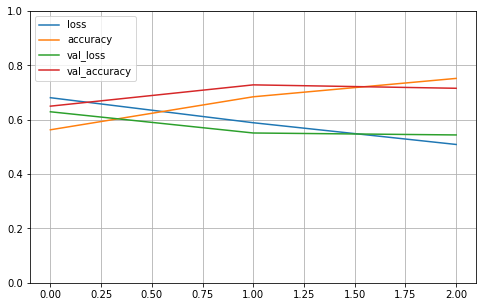

Train set ones/size 4773 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 560 / 1034
Range of scores: 0.010807468 to 0.99797624
Score threshold 0.5
Prediction set ones/size 500 / 1034


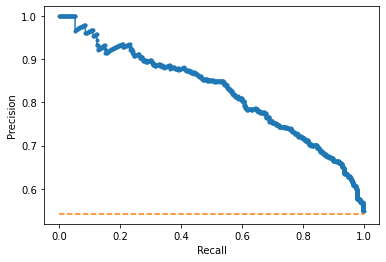

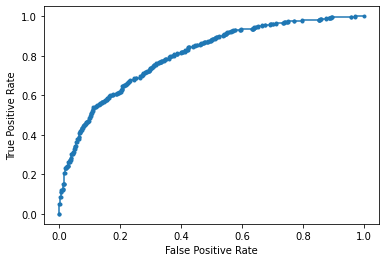

Accuracy: 71.57% Precision: 76.60% Recall: 68.39%
F1: 72.26% AUPRC: 82.49% AUROC: 80.18%
2023-02-07 15:41:58.620451
Fold 4
RCI mean derived from training set: -0.958191079807589
RCI threshold derived from training set: -0.958191079807589
FIT
2023-02-07 15:42:02.732444
PREDICT
2023-02-07 15:42:12.711174


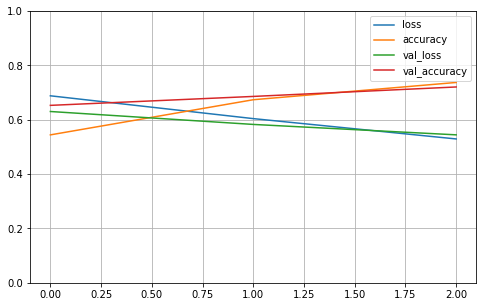

Train set ones/size 4790 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 543 / 1034
Range of scores: 0.0059439875 to 0.9887221
Score threshold 0.5
Prediction set ones/size 496 / 1034


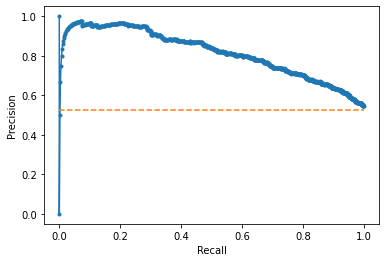

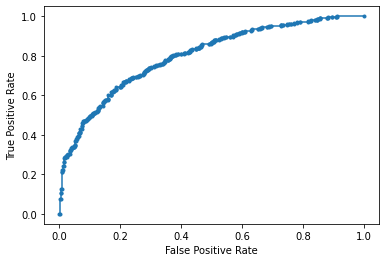

Accuracy: 72.05% Precision: 75.60% Recall: 69.06%
F1: 72.18% AUPRC: 81.63% AUROC: 79.99%
2023-02-07 15:42:13.419423
Fold 5
RCI mean derived from training set: -0.9628417059926905
RCI threshold derived from training set: -0.9628417059926905
FIT
2023-02-07 15:42:17.972814
PREDICT
2023-02-07 15:42:27.990259


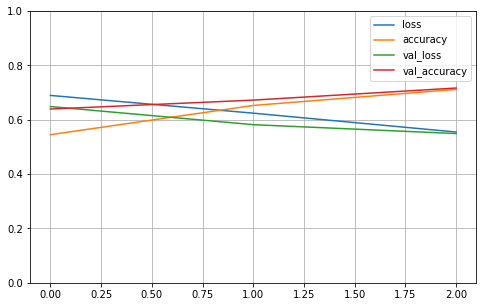

Train set ones/size 4792 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 541 / 1034
Range of scores: 0.018814094 to 0.96959937
Score threshold 0.5
Prediction set ones/size 478 / 1034


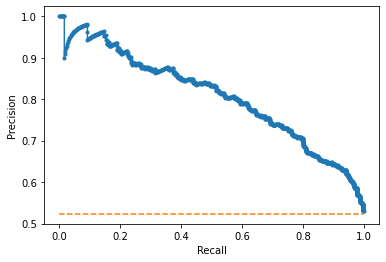

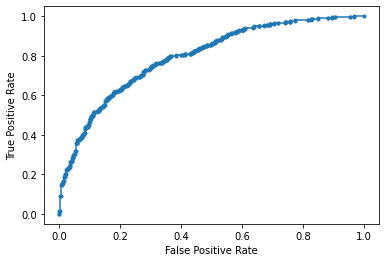

Accuracy: 71.66% Precision: 75.94% Recall: 67.10%
F1: 71.25% AUPRC: 80.77% AUROC: 79.60%
2023-02-07 15:42:28.672129
Fold 6
RCI mean derived from training set: -0.9595112937514781
RCI threshold derived from training set: -0.9595112937514781
FIT
2023-02-07 15:42:34.335281
PREDICT
2023-02-07 15:42:45.734639


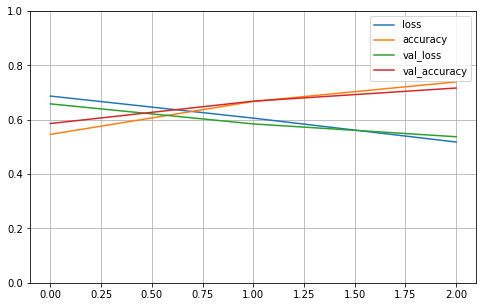

Train set ones/size 4793 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 540 / 1034
Range of scores: 0.0040576663 to 0.9960956
Score threshold 0.5
Prediction set ones/size 679 / 1034


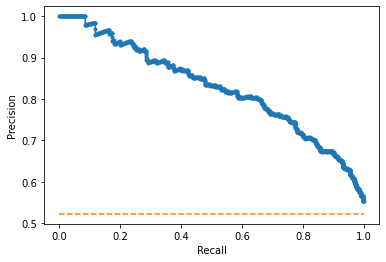

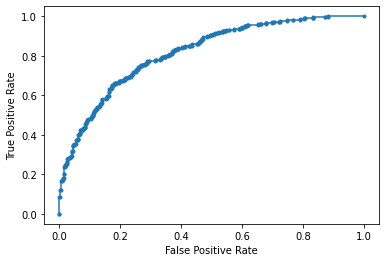

Accuracy: 71.66% Precision: 68.19% Recall: 85.74%
F1: 75.96% AUPRC: 82.84% AUROC: 81.69%
2023-02-07 15:42:46.624276
Fold 7
RCI mean derived from training set: -0.9601035896538751
RCI threshold derived from training set: -0.9601035896538751
FIT
2023-02-07 15:42:50.724381
PREDICT
2023-02-07 15:43:00.782761


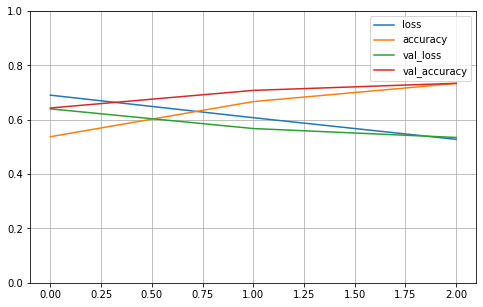

Train set ones/size 4806 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 527 / 1034
Range of scores: 0.003833802 to 0.9957008
Score threshold 0.5
Prediction set ones/size 490 / 1034


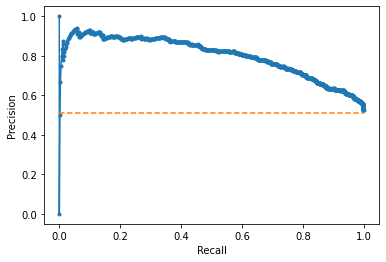

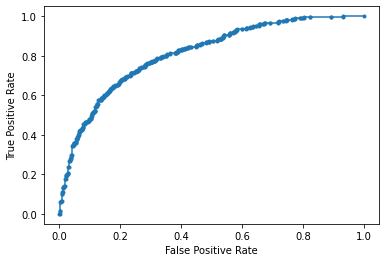

Accuracy: 73.40% Precision: 75.71% Recall: 70.40%
F1: 72.96% AUPRC: 80.07% AUROC: 81.13%
2023-02-07 15:43:01.494033
Fold 8
RCI mean derived from training set: -0.9442116707889081
RCI threshold derived from training set: -0.9442116707889081
FIT
2023-02-07 15:43:05.564767
PREDICT
2023-02-07 15:43:15.686693


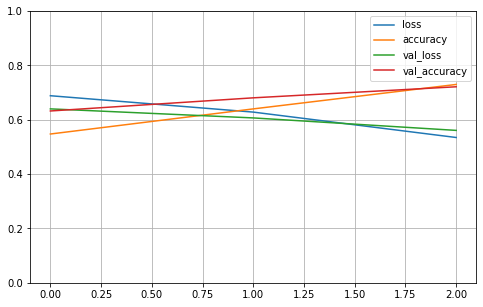

Train set ones/size 4799 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 517 / 1033
Range of scores: 0.003981139 to 0.98689425
Score threshold 0.5
Prediction set ones/size 591 / 1033


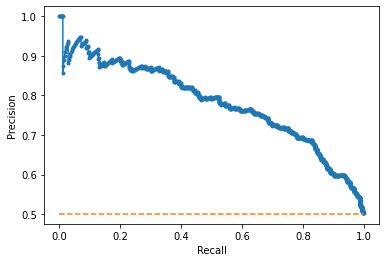

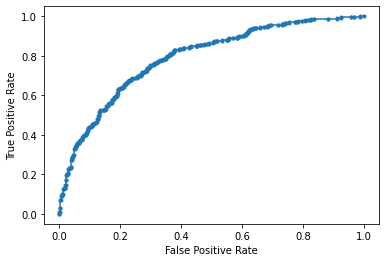

Accuracy: 72.12% Precision: 69.37% Recall: 79.30%
F1: 74.01% AUPRC: 78.18% AUROC: 79.12%
2023-02-07 15:43:16.380328
Fold 9
RCI mean derived from training set: -0.9603716917605332
RCI threshold derived from training set: -0.9603716917605332
FIT
2023-02-07 15:43:20.453499
PREDICT
2023-02-07 15:43:31.856076


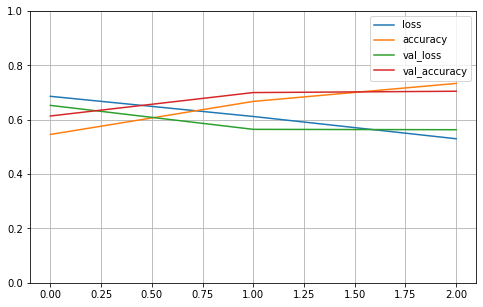

Train set ones/size 4799 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 534 / 1033
Range of scores: 0.008693585 to 0.9876265
Score threshold 0.5
Prediction set ones/size 397 / 1033


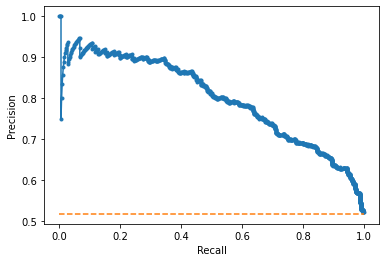

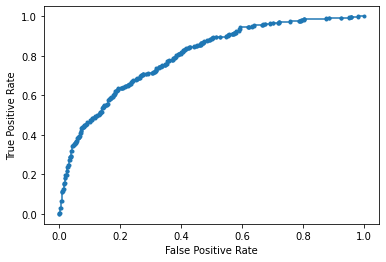

Accuracy: 70.47% Precision: 78.84% Recall: 58.61%
F1: 67.24% AUPRC: 79.90% AUROC: 79.70%
2023-02-07 15:43:32.555451
Fold 10
RCI mean derived from training set: -0.9432120966089854
RCI threshold derived from training set: -0.9432120966089854
FIT
2023-02-07 15:43:37.533653
PREDICT
2023-02-07 15:43:49.241558


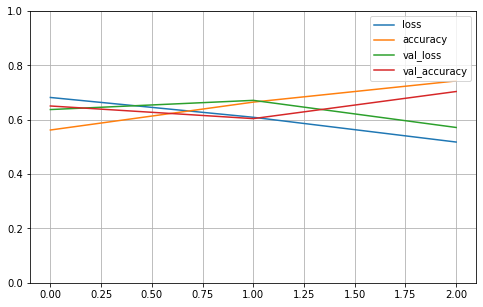

Train set ones/size 4814 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 502 / 1033
Range of scores: 0.00036304627 to 0.98329663
Score threshold 0.5
Prediction set ones/size 400 / 1033


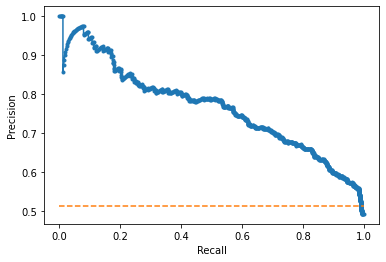

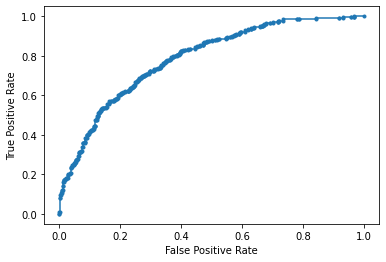

Accuracy: 70.38% Precision: 74.50% Recall: 59.36%
F1: 66.08% AUPRC: 76.66% AUROC: 78.64%
2023-02-07 15:43:50.264036

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.77% +/- 1.53
 precision mean 73.84% +/- 5.05
 recall mean 71.93% +/- 10.64
 F1 mean 72.16% +/- 3.26
 AUPRC mean 80.94% +/- 2.32
 AUROC mean 80.57% +/- 1.53
Finished cell Line 11 SK.N.SH

2023-02-07 15:43:51.847952
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-07 15:44:07.223939
splitting
Fold 1
RCI mean derived from training set: -0.7917608026152975
RCI threshold derived from training set: -0.7917608026152975
FIT
2023-02-07 15:44:09.808170
PREDICT
2023-02-07 15:44:19.393471


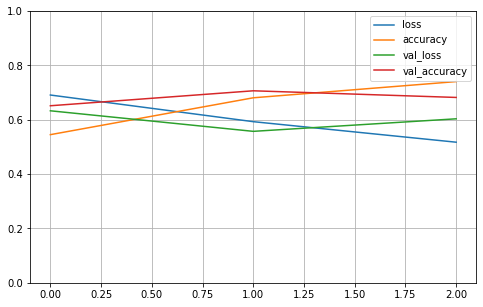

Train set ones/size 4450 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 528 / 981
Range of scores: 0.0023707242 to 0.9930194
Score threshold 0.5
Prediction set ones/size 270 / 981


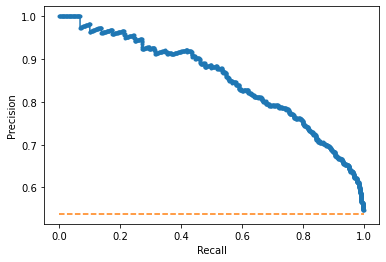

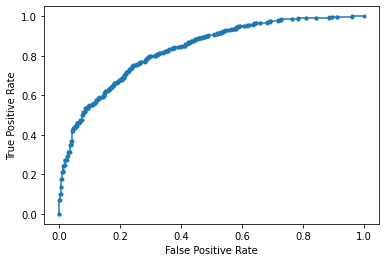

Accuracy: 68.20% Precision: 90.00% Recall: 46.02%
F1: 60.90% AUPRC: 85.23% AUROC: 83.14%
2023-02-07 15:44:20.122004
Fold 2
RCI mean derived from training set: -0.7848096078186968
RCI threshold derived from training set: -0.7848096078186968
FIT
2023-02-07 15:44:24.105772
PREDICT
2023-02-07 15:44:33.786999


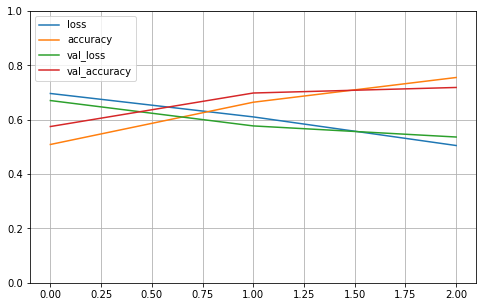

Train set ones/size 4476 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 496 / 981
Range of scores: 0.0012210651 to 0.9969152
Score threshold 0.5
Prediction set ones/size 370 / 981


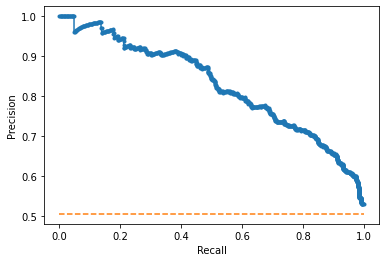

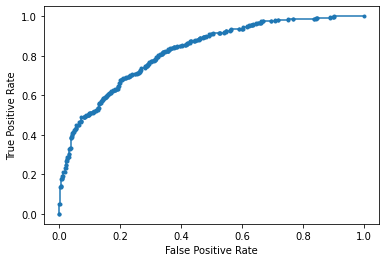

Accuracy: 71.87% Precision: 79.73% Recall: 59.48%
F1: 68.13% AUPRC: 82.77% AUROC: 82.28%
2023-02-07 15:44:34.504184
Fold 3
RCI mean derived from training set: -0.7932426588759207
RCI threshold derived from training set: -0.7932426588759207
FIT
2023-02-07 15:44:38.445721
PREDICT
2023-02-07 15:44:48.240604


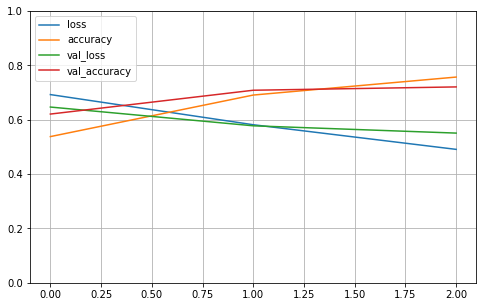

Train set ones/size 4464 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 514 / 981
Range of scores: 0.0018859843 to 0.9902104
Score threshold 0.5
Prediction set ones/size 344 / 981


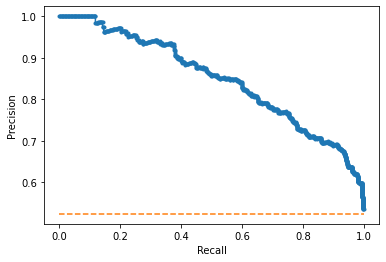

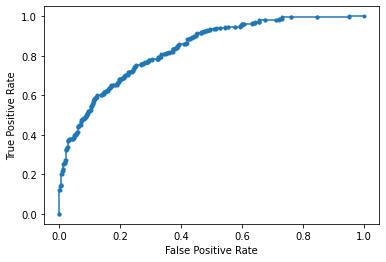

Accuracy: 72.07% Precision: 84.88% Recall: 56.81%
F1: 68.07% AUPRC: 84.92% AUROC: 83.51%
2023-02-07 15:44:48.971179
Fold 4
RCI mean derived from training set: -0.7787853194719547
RCI threshold derived from training set: -0.7787853194719547
FIT
2023-02-07 15:44:52.898768
PREDICT
2023-02-07 15:45:02.657924


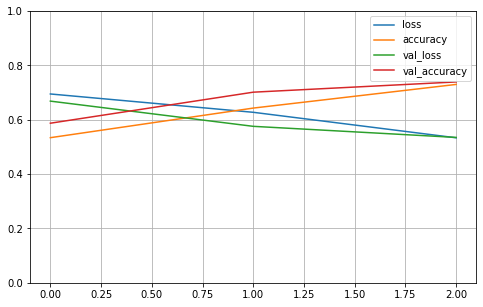

Train set ones/size 4487 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 475 / 981
Range of scores: 0.009502008 to 0.9929263
Score threshold 0.5
Prediction set ones/size 367 / 981


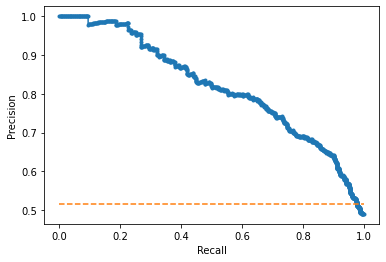

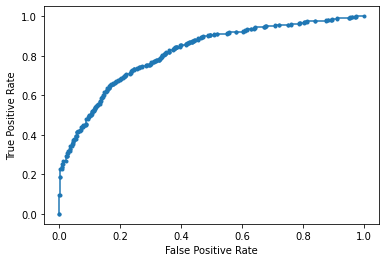

Accuracy: 73.90% Precision: 79.84% Recall: 61.68%
F1: 69.60% AUPRC: 81.98% AUROC: 81.70%
2023-02-07 15:45:03.398549
Fold 5
RCI mean derived from training set: -0.7845497024022663
RCI threshold derived from training set: -0.7845497024022663
FIT
2023-02-07 15:45:07.369272
PREDICT
2023-02-07 15:45:18.931190


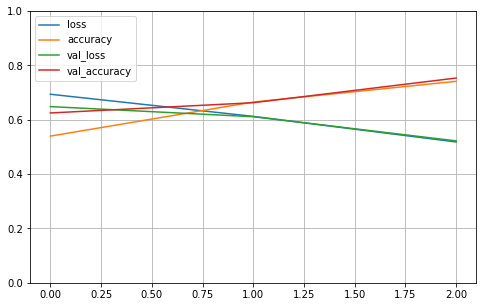

Train set ones/size 4472 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 500 / 981
Range of scores: 0.0041063707 to 0.99689627
Score threshold 0.5
Prediction set ones/size 410 / 981


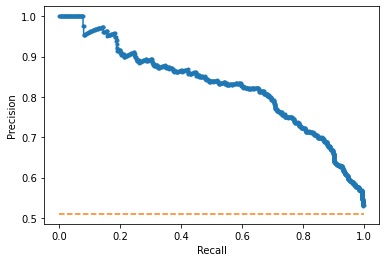

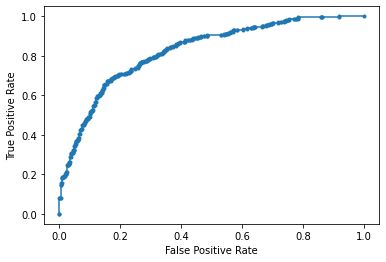

Accuracy: 75.33% Precision: 81.46% Recall: 66.80%
F1: 73.41% AUPRC: 82.72% AUROC: 82.56%
2023-02-07 15:45:19.836256
Fold 6
RCI mean derived from training set: -0.791977157883286
RCI threshold derived from training set: -0.791977157883286
FIT
2023-02-07 15:45:25.383100
PREDICT
2023-02-07 15:45:36.753813


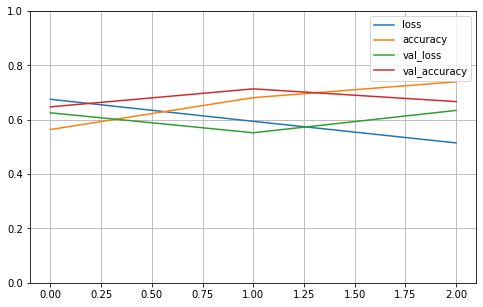

Train set ones/size 4463 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 515 / 981
Range of scores: 0.005060783 to 0.9873541
Score threshold 0.5
Prediction set ones/size 234 / 981


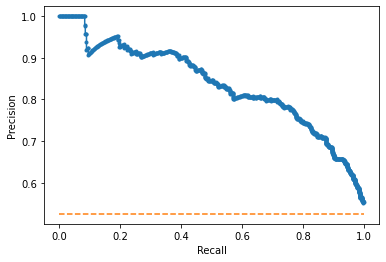

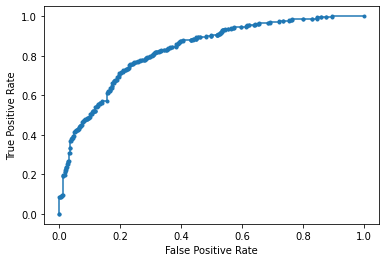

Accuracy: 66.67% Precision: 90.17% Recall: 40.97%
F1: 56.34% AUPRC: 83.69% AUROC: 82.89%
2023-02-07 15:45:37.704320
Fold 7
RCI mean derived from training set: -0.7820942513777476
RCI threshold derived from training set: -0.7820942513777476
FIT
2023-02-07 15:45:41.641301
PREDICT
2023-02-07 15:45:53.015390


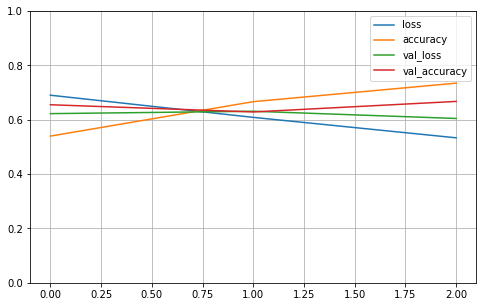

Train set ones/size 4495 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 477 / 980
Range of scores: 0.02108708 to 0.996061
Score threshold 0.5
Prediction set ones/size 707 / 980


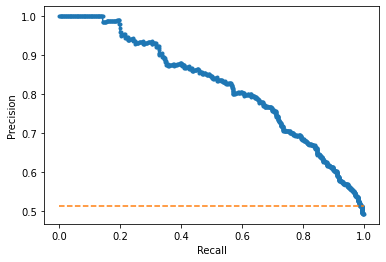

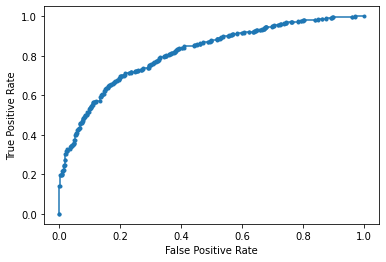

Accuracy: 66.73% Precision: 60.68% Recall: 89.94%
F1: 72.47% AUPRC: 82.18% AUROC: 81.47%
2023-02-07 15:45:53.920740
Fold 8
RCI mean derived from training set: -0.7733633923476094
RCI threshold derived from training set: -0.7733633923476094
FIT
2023-02-07 15:45:57.886781
PREDICT
2023-02-07 15:46:09.266286


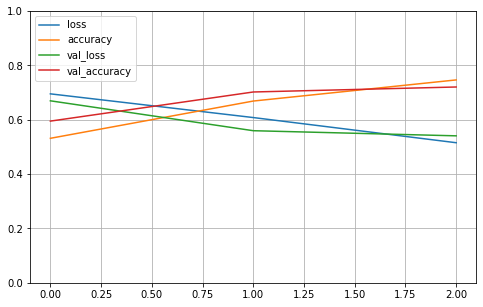

Train set ones/size 4495 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 459 / 980
Range of scores: 0.0022720646 to 0.9938261
Score threshold 0.5
Prediction set ones/size 377 / 980


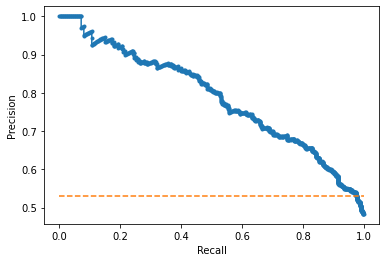

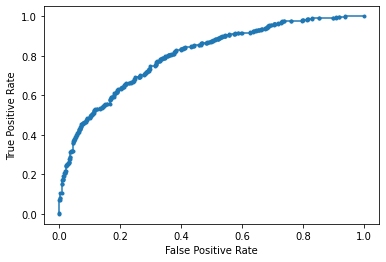

Accuracy: 72.04% Precision: 74.54% Recall: 61.22%
F1: 67.22% AUPRC: 78.80% AUROC: 80.21%
2023-02-07 15:46:10.152899
Fold 9
RCI mean derived from training set: -0.7889935849399501
RCI threshold derived from training set: -0.7889935849399501
FIT
2023-02-07 15:46:14.421321
PREDICT
2023-02-07 15:46:26.190851


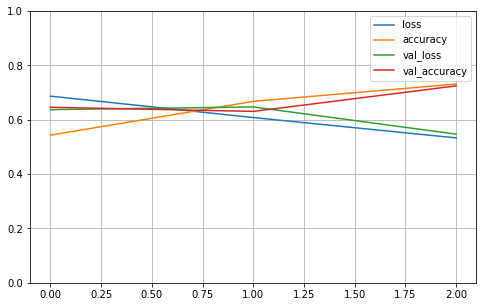

Train set ones/size 4471 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 502 / 980
Range of scores: 0.012482703 to 0.9920488
Score threshold 0.5
Prediction set ones/size 612 / 980


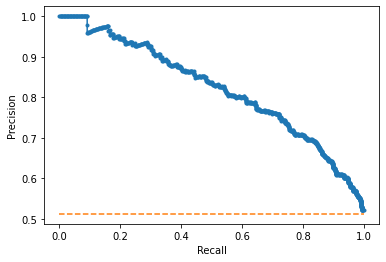

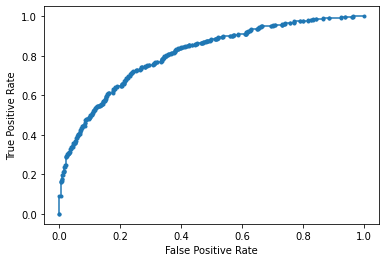

Accuracy: 72.45% Precision: 68.95% Recall: 84.06%
F1: 75.76% AUPRC: 82.23% AUROC: 80.81%
2023-02-07 15:46:26.928923
Fold 10
RCI mean derived from training set: -0.7912181729707681
RCI threshold derived from training set: -0.7912181729707681
FIT
2023-02-07 15:46:31.643208
PREDICT
2023-02-07 15:46:41.090262


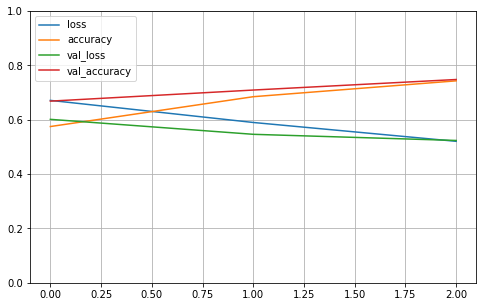

Train set ones/size 4471 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 506 / 980
Range of scores: 0.014057255 to 0.9949595
Score threshold 0.5
Prediction set ones/size 449 / 980


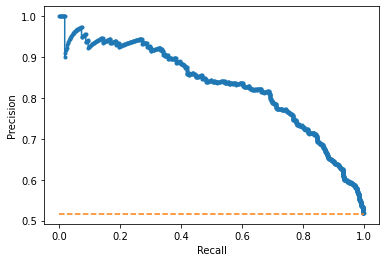

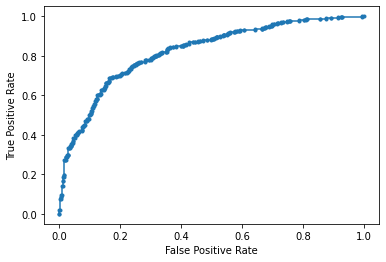

Accuracy: 74.80% Precision: 78.84% Recall: 69.96%
F1: 74.14% AUPRC: 82.99% AUROC: 82.25%
2023-02-07 15:46:42.153247

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.41% +/- 3.16
 precision mean 78.91% +/- 9.09
 recall mean 63.69% +/- 15.12
 F1 mean 68.60% +/- 6.08
 AUPRC mean 82.75% +/- 1.78
 AUROC mean 82.08% +/- 1.04
Finished cell Line 12 GM12878

2023-02-07 15:46:43.749187
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-07 15:46:52.285675
splitting
Fold 1
RCI mean derived from training set: -0.6713087291342756
RCI threshold derived from training set: -0.6713087291342756
FIT
2023-02-07 15:46:54.588863
PREDICT
2023-02-07 15:47:06.139899


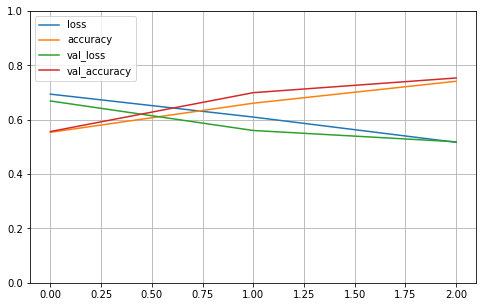

Train set ones/size 3179 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 339 / 629
Range of scores: 0.006234278 to 0.9878155
Score threshold 0.5
Prediction set ones/size 320 / 629


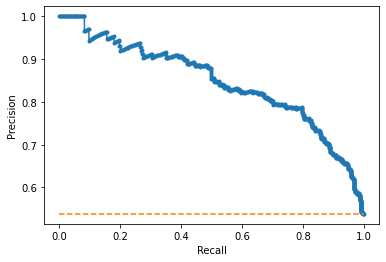

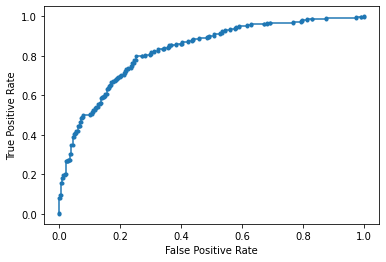

Accuracy: 75.36% Precision: 78.75% Recall: 74.34%
F1: 76.48% AUPRC: 84.64% AUROC: 82.85%
2023-02-07 15:47:06.932933
Fold 2
RCI mean derived from training set: -0.6737843573215548
RCI threshold derived from training set: -0.6737843573215548
FIT
2023-02-07 15:47:10.594898
PREDICT
2023-02-07 15:47:21.774374


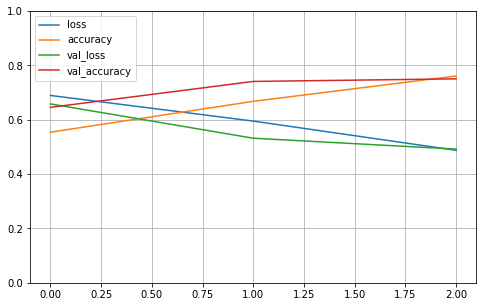

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.004679621 to 0.9984425
Score threshold 0.5
Prediction set ones/size 357 / 629


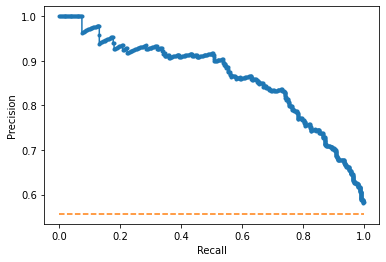

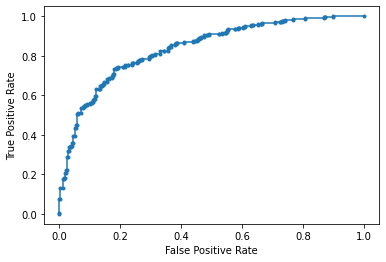

Accuracy: 75.04% Precision: 77.03% Recall: 78.57%
F1: 77.79% AUPRC: 86.34% AUROC: 83.82%
2023-02-07 15:47:22.430126
Fold 3
RCI mean derived from training set: -0.6784838250318022
RCI threshold derived from training set: -0.6784838250318022
FIT
2023-02-07 15:47:25.403833
PREDICT
2023-02-07 15:47:31.748472


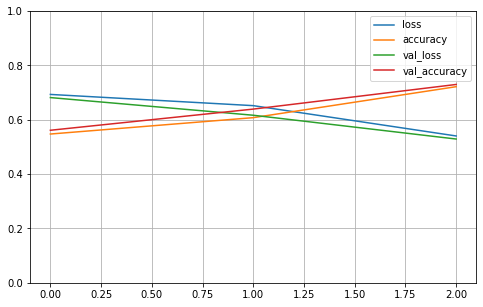

Train set ones/size 3212 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.015358973 to 0.9903853
Score threshold 0.5
Prediction set ones/size 374 / 629


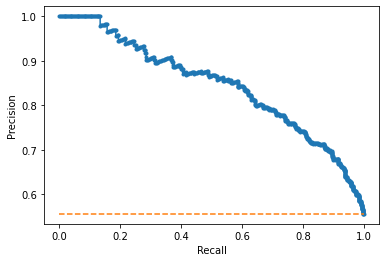

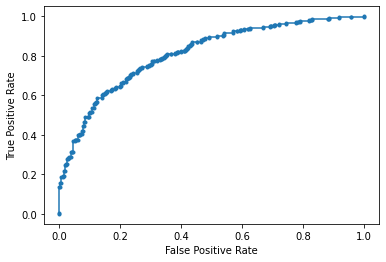

Accuracy: 72.97% Precision: 74.06% Recall: 79.14%
F1: 76.52% AUPRC: 84.58% AUROC: 81.04%
2023-02-07 15:47:32.593696
Fold 4
RCI mean derived from training set: -0.6876066247208481
RCI threshold derived from training set: -0.6876066247208481
FIT
2023-02-07 15:47:35.962331
PREDICT
2023-02-07 15:47:42.176213


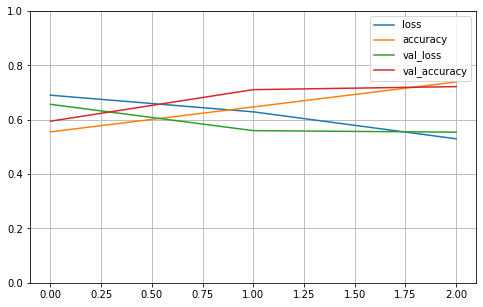

Train set ones/size 3192 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 372 / 629
Range of scores: 0.02152074 to 0.99853885
Score threshold 0.5
Prediction set ones/size 507 / 629


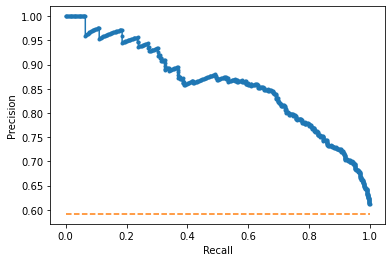

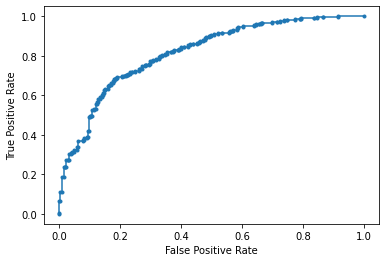

Accuracy: 72.18% Precision: 69.43% Recall: 94.62%
F1: 80.09% AUPRC: 85.94% AUROC: 81.70%
2023-02-07 15:47:42.845910
Fold 5
RCI mean derived from training set: -0.6696898698833923
RCI threshold derived from training set: -0.6696898698833923
FIT
2023-02-07 15:47:46.721223
PREDICT
2023-02-07 15:47:58.302142


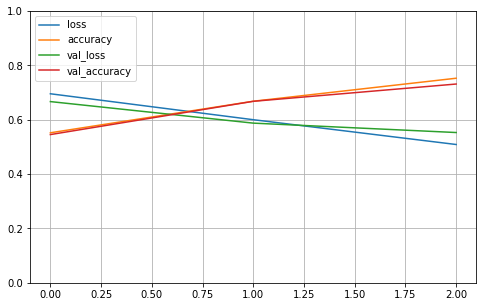

Train set ones/size 3174 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 343 / 629
Range of scores: 0.020241827 to 0.99801254
Score threshold 0.5
Prediction set ones/size 448 / 629


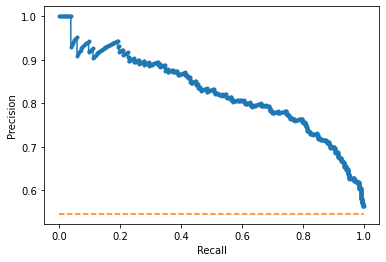

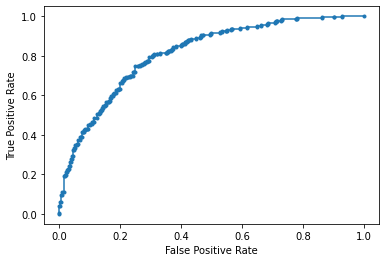

Accuracy: 73.13% Precision: 69.42% Recall: 90.67%
F1: 78.63% AUPRC: 82.58% AUROC: 81.37%
2023-02-07 15:47:59.183443
Fold 6
RCI mean derived from training set: -0.6754036411201414
RCI threshold derived from training set: -0.6754036411201414
FIT
2023-02-07 15:48:02.566533
PREDICT
2023-02-07 15:48:13.739201


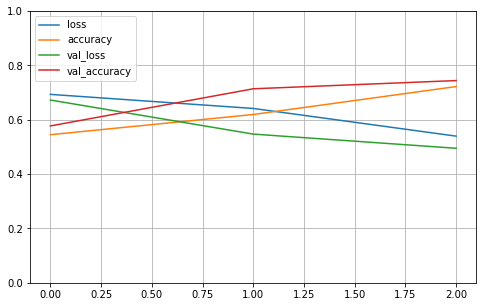

Train set ones/size 3187 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 363 / 629
Range of scores: 0.009603877 to 0.98775756
Score threshold 0.5
Prediction set ones/size 326 / 629


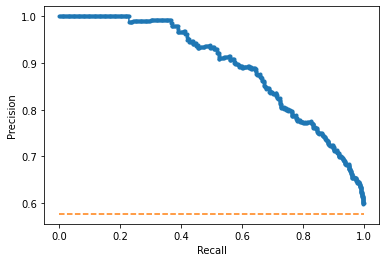

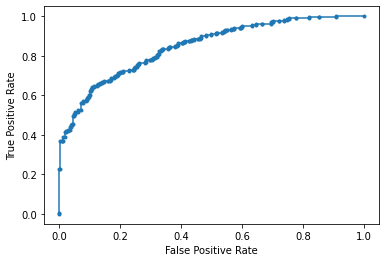

Accuracy: 74.40% Precision: 80.98% Recall: 72.73%
F1: 76.63% AUPRC: 89.32% AUROC: 84.71%
2023-02-07 15:48:14.399259
Fold 7
RCI mean derived from training set: -0.6775167190000001
RCI threshold derived from training set: -0.6775167190000001
FIT
2023-02-07 15:48:17.395869
PREDICT
2023-02-07 15:48:28.586260


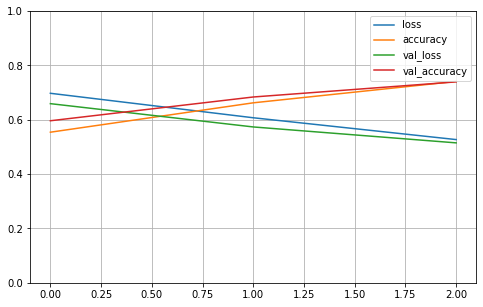

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.012647378 to 0.99482346
Score threshold 0.5
Prediction set ones/size 412 / 629


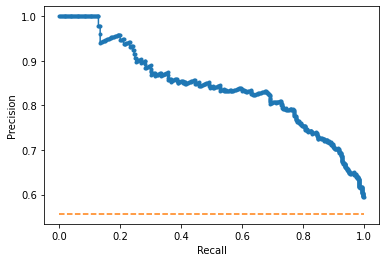

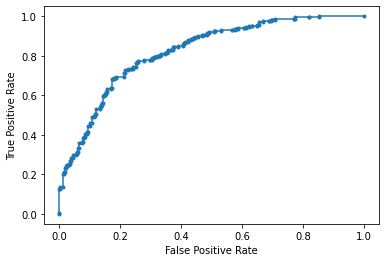

Accuracy: 73.93% Precision: 72.57% Recall: 85.43%
F1: 78.48% AUPRC: 84.39% AUROC: 82.19%
2023-02-07 15:48:29.276410
Fold 8
RCI mean derived from training set: -0.6808395354416962
RCI threshold derived from training set: -0.6808395354416962
FIT
2023-02-07 15:48:32.284164
PREDICT
2023-02-07 15:48:43.476871


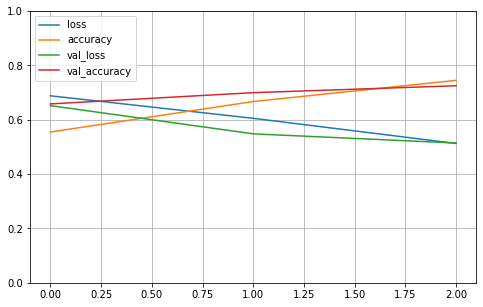

Train set ones/size 3198 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 364 / 629
Range of scores: 0.045554794 to 0.99410546
Score threshold 0.5
Prediction set ones/size 443 / 629


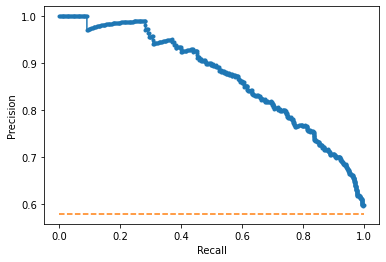

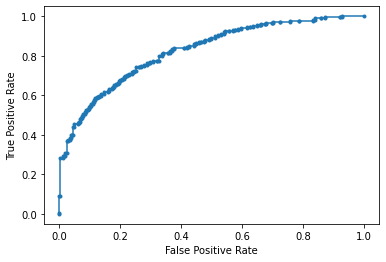

Accuracy: 72.50% Precision: 71.56% Recall: 87.09%
F1: 78.56% AUPRC: 87.22% AUROC: 82.46%
2023-02-07 15:48:44.153286
Fold 9
RCI mean derived from training set: -0.6768322222844524
RCI threshold derived from training set: -0.6768322222844524
FIT
2023-02-07 15:48:47.165754
PREDICT
2023-02-07 15:48:53.965286


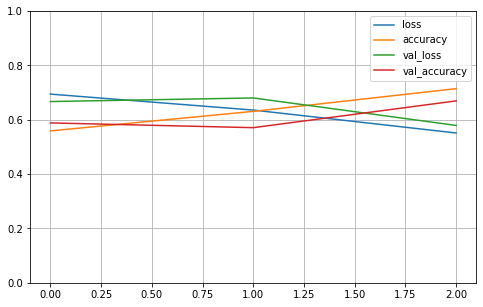

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.060559884 to 0.99667066
Score threshold 0.5
Prediction set ones/size 530 / 629


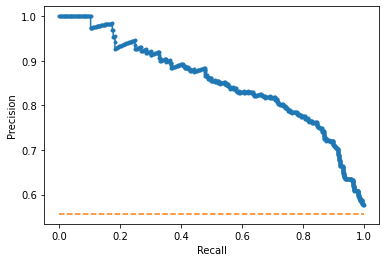

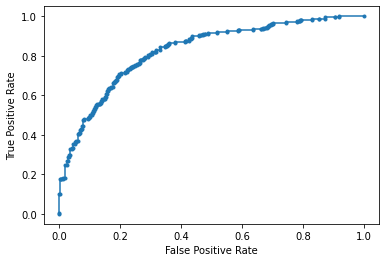

Accuracy: 66.93% Precision: 63.40% Recall: 96.00%
F1: 76.36% AUPRC: 85.32% AUROC: 82.54%
2023-02-07 15:48:54.618953
Fold 10
RCI mean derived from training set: -0.6857367733633634
RCI threshold derived from training set: -0.6857367733633634
FIT
2023-02-07 15:48:57.650304
PREDICT
2023-02-07 15:49:08.866565


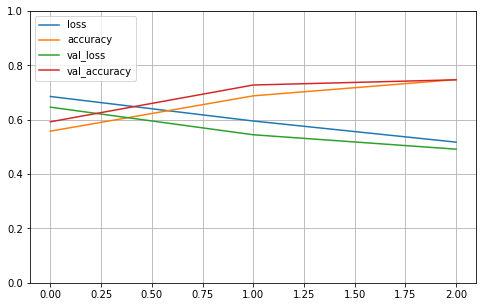

Train set ones/size 3197 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 365 / 628
Range of scores: 0.013262132 to 0.9940644
Score threshold 0.5
Prediction set ones/size 380 / 628


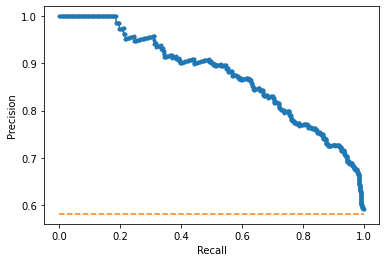

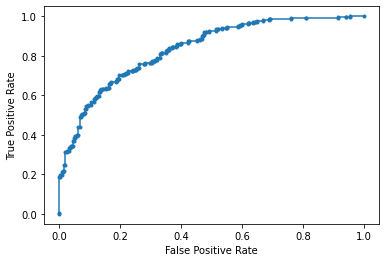

Accuracy: 74.68% Precision: 77.11% Recall: 80.27%
F1: 78.66% AUPRC: 87.52% AUROC: 83.46%
2023-02-07 15:49:09.556089

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.11% +/- 2.43
 precision mean 73.43% +/- 5.26
 recall mean 83.89% +/- 8.17
 F1 mean 77.82% +/- 1.27
 AUPRC mean 85.78% +/- 1.92
 AUROC mean 82.62% +/- 1.14
Finished cell Line 13 K562

2023-02-07 15:49:10.910008
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-07 15:49:14.401141
splitting
Fold 1
RCI mean derived from training set: -0.7940587397297298
RCI threshold derived from training set: -0.7940587397297298
FIT
2023-02-07 15:49:15.219447
PREDICT
2023-02-07 15:49:18.792093


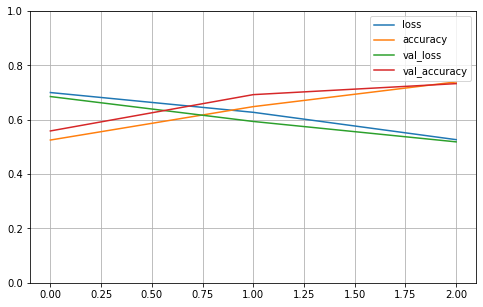

Train set ones/size 1095 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 110 / 247
Range of scores: 0.01635726 to 0.9445711
Score threshold 0.5
Prediction set ones/size 126 / 247


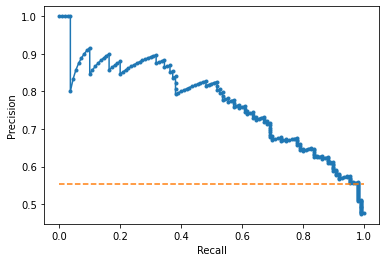

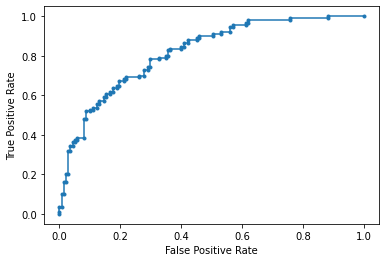

Accuracy: 73.28% Precision: 67.46% Recall: 77.27%
F1: 72.03% AUPRC: 77.09% AUROC: 81.84%
2023-02-07 15:49:19.406278
Fold 2
RCI mean derived from training set: -0.792873576036036
RCI threshold derived from training set: -0.792873576036036
FIT
2023-02-07 15:49:21.393636
PREDICT
2023-02-07 15:49:24.357414


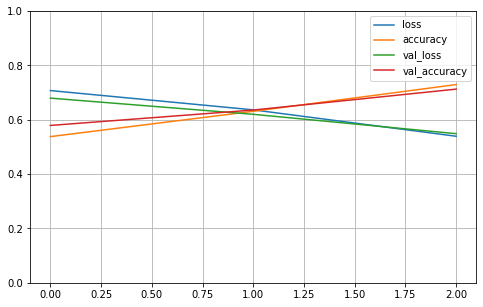

Train set ones/size 1085 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 120 / 247
Range of scores: 0.006571635 to 0.97529364
Score threshold 0.5
Prediction set ones/size 87 / 247


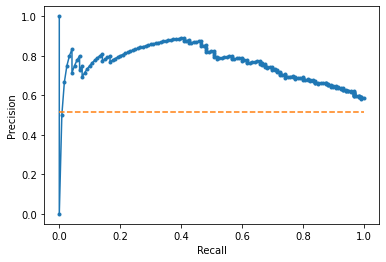

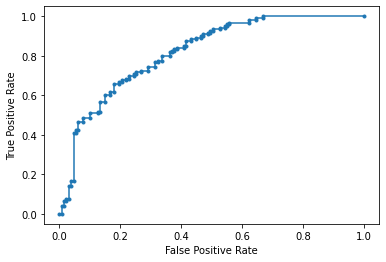

Accuracy: 71.26% Precision: 78.16% Recall: 56.67%
F1: 65.70% AUPRC: 75.85% AUROC: 81.85%
2023-02-07 15:49:24.987409
Fold 3
RCI mean derived from training set: -0.8008805327927928
RCI threshold derived from training set: -0.8008805327927928
FIT
2023-02-07 15:49:26.910293
PREDICT
2023-02-07 15:49:30.172336


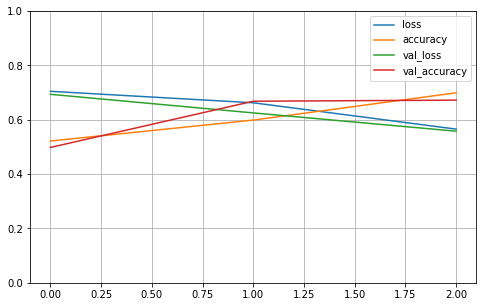

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 118 / 247
Range of scores: 0.0047866004 to 0.9274318
Score threshold 0.5
Prediction set ones/size 81 / 247


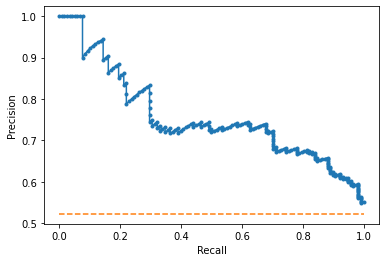

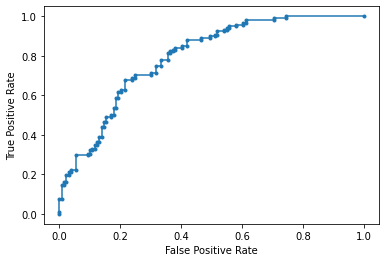

Accuracy: 67.21% Precision: 72.84% Recall: 50.00%
F1: 59.30% AUPRC: 75.59% AUROC: 79.35%
2023-02-07 15:49:30.921325
Fold 4
RCI mean derived from training set: -0.8059054895045044
RCI threshold derived from training set: -0.8059054895045044
FIT
2023-02-07 15:49:32.951216
PREDICT
2023-02-07 15:49:35.956212


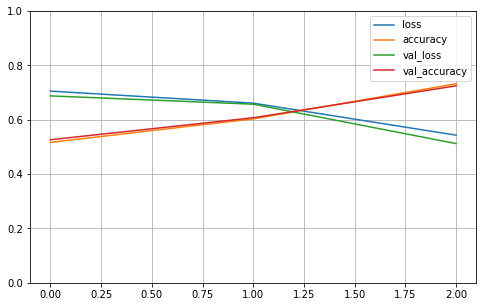

Train set ones/size 1083 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 124 / 247
Range of scores: 0.00086304883 to 0.96286887
Score threshold 0.5
Prediction set ones/size 142 / 247


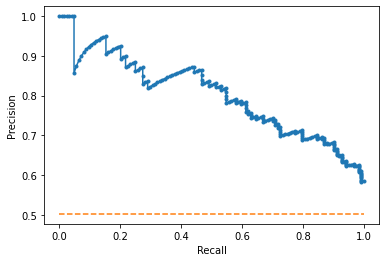

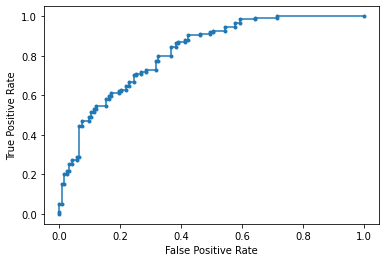

Accuracy: 72.47% Precision: 69.72% Recall: 79.84%
F1: 74.44% AUPRC: 80.25% AUROC: 81.87%
2023-02-07 15:49:36.589704
Fold 5
RCI mean derived from training set: -0.786263587027027
RCI threshold derived from training set: -0.786263587027027
FIT
2023-02-07 15:49:38.600627
PREDICT
2023-02-07 15:49:41.588694


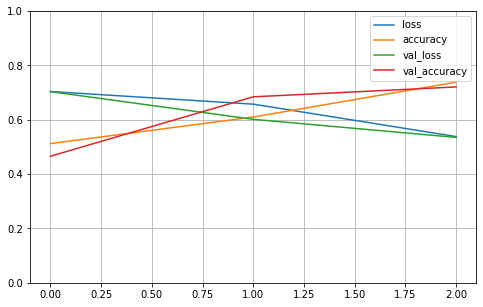

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 117 / 247
Range of scores: 0.0021612912 to 0.94418067
Score threshold 0.5
Prediction set ones/size 120 / 247


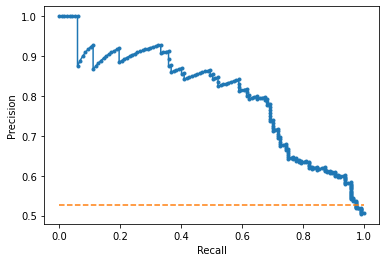

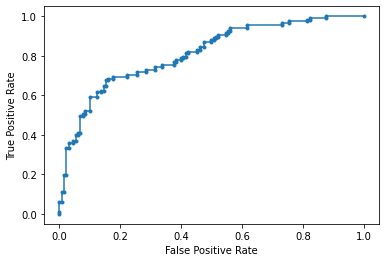

Accuracy: 72.06% Precision: 70.00% Recall: 71.79%
F1: 70.89% AUPRC: 79.98% AUROC: 81.23%
2023-02-07 15:49:42.296647
Fold 6
RCI mean derived from training set: -0.8023878546846847
RCI threshold derived from training set: -0.8023878546846847
FIT
2023-02-07 15:49:44.802252
PREDICT
2023-02-07 15:49:48.112382


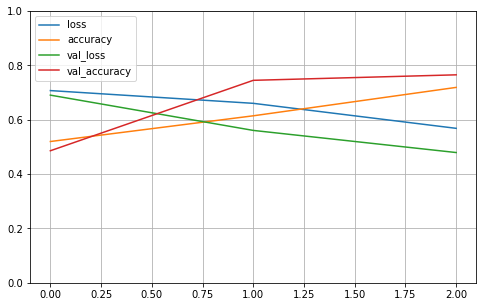

Train set ones/size 1089 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 116 / 247
Range of scores: 0.018344728 to 0.982251
Score threshold 0.5
Prediction set ones/size 130 / 247


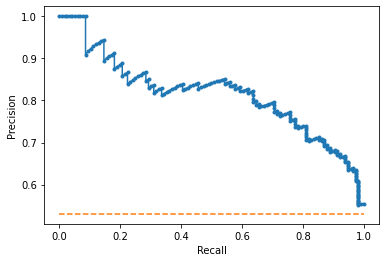

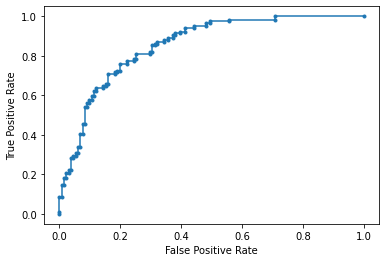

Accuracy: 76.52% Precision: 72.31% Recall: 81.03%
F1: 76.42% AUPRC: 81.60% AUROC: 85.49%
2023-02-07 15:49:48.749346
Fold 7
RCI mean derived from training set: -0.8069793445045045
RCI threshold derived from training set: -0.8069793445045045
FIT
2023-02-07 15:49:50.683182
PREDICT
2023-02-07 15:49:53.937536


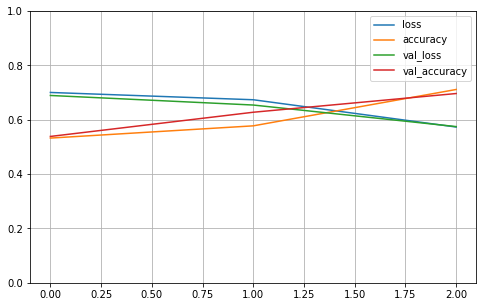

Train set ones/size 1080 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 127 / 247
Range of scores: 0.001831544 to 0.9765346
Score threshold 0.5
Prediction set ones/size 132 / 247


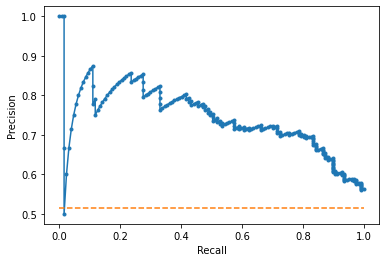

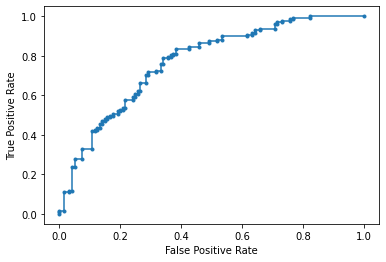

Accuracy: 69.64% Precision: 69.70% Recall: 72.44%
F1: 71.04% AUPRC: 74.14% AUROC: 76.88%
2023-02-07 15:49:54.539039
Fold 8
RCI mean derived from training set: -0.8009138882485366
RCI threshold derived from training set: -0.8009138882485366
FIT
2023-02-07 15:49:57.066482
PREDICT
2023-02-07 15:50:00.607726


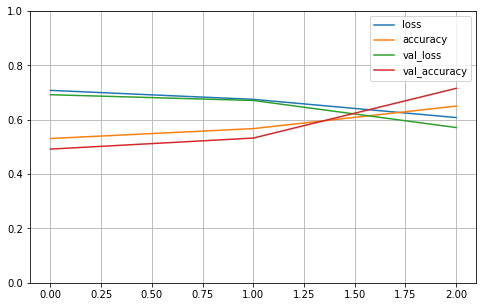

Train set ones/size 1081 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 124 / 246
Range of scores: 0.011684488 to 0.96702784
Score threshold 0.5
Prediction set ones/size 94 / 246


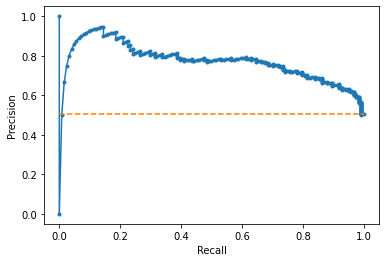

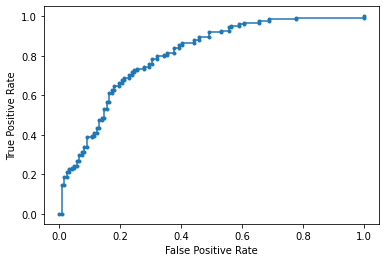

Accuracy: 71.54% Precision: 78.72% Recall: 59.68%
F1: 67.89% AUPRC: 76.99% AUROC: 80.47%
2023-02-07 15:50:01.261727
Fold 9
RCI mean derived from training set: -0.8323262177397568
RCI threshold derived from training set: -0.8323262177397568
FIT
2023-02-07 15:50:03.259818
PREDICT
2023-02-07 15:50:06.500312


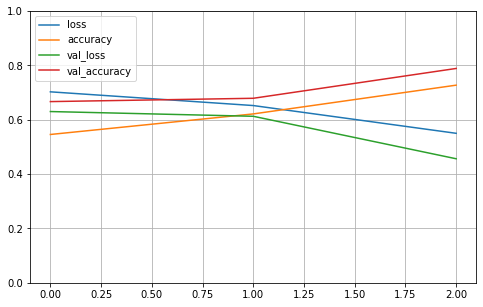

Train set ones/size 1272 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 164 / 246
Range of scores: 0.15380262 to 0.9947023
Score threshold 0.5
Prediction set ones/size 210 / 246


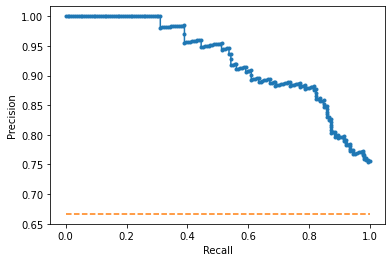

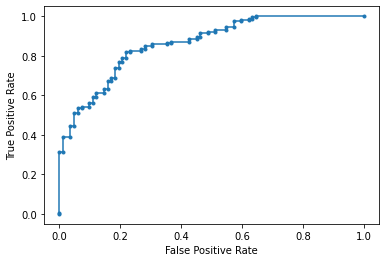

Accuracy: 78.86% Precision: 76.67% Recall: 98.17%
F1: 86.10% AUPRC: 92.58% AUROC: 86.26%
2023-02-07 15:50:07.142038
Fold 10
RCI mean derived from training set: -0.8036815406573616
RCI threshold derived from training set: -0.8036815406573616
FIT
2023-02-07 15:50:09.612696
PREDICT
2023-02-07 15:50:13.161209


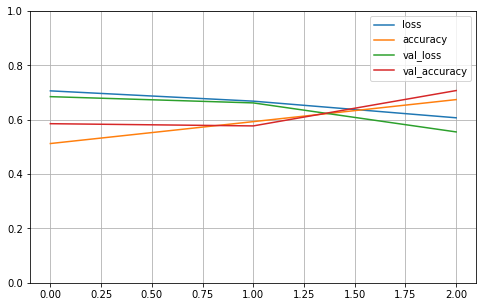

Train set ones/size 1088 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 117 / 246
Range of scores: 0.00487221 to 0.93056893
Score threshold 0.5
Prediction set ones/size 107 / 246


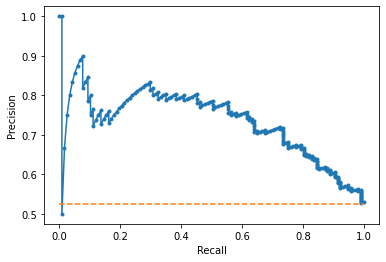

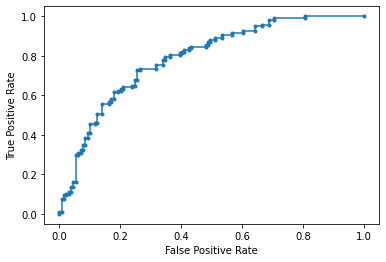

Accuracy: 70.73% Precision: 71.03% Recall: 64.96%
F1: 67.86% AUPRC: 73.32% AUROC: 78.90%
2023-02-07 15:50:13.771689

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.36% +/- 3.32
 precision mean 72.66% +/- 3.91
 recall mean 71.19% +/- 14.02
 F1 mean 71.17% +/- 7.11
 AUPRC mean 78.74% +/- 5.56
 AUROC mean 81.41% +/- 2.84
Finished cell Line 14 IMR.90

2023-02-07 15:50:15.037678


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())